## Validation of users by Income + job title regression

In this notebook, I aim to perform the final validation of the user voordinates via regression between Income and estimated SES. 
The validation includes:
- Simple linear Regression and multiple linear regression (ordinary least squares) on coordinates and income for nine different models*
- *Model comparison between nine different configurations of markers included in the network
    - Goofness of fit characteristics
- End result is identification of the best marker configuration for obtaining the best linreg fit

In [123]:
import os
import re
import sys
from collections import Counter
import importlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import FrenchStemmer
from nltk.tokenize import word_tokenize
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, GroupKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

# Local application imports
sys.path.insert(0, '../Utility files')
import utils2
from utils2 import *

from model_comparison import CrossValidation


## 1 Connect job titles and income information to all coordinate files

First and foremost, I need to add all the income + job information per user to each of the nine coordinate files m1-m9
Create a function that:
- Iterates over each file system, from n=1 to n=9
- Removes all users that do not occur in the job title file onlygreenscleaned

In [2]:
#Load the income + job title data
path= '/home/livtollanes/10.jan-thesis/Code/Validation/Data/'
file = 'onlygreens_cleaned.csv'
jobs = pd.read_csv(path + file, index_col= 0, dtype={'follower_id': str})

In total, we have 11 683 unique users with a job title after preprocessing

### some stats

In [9]:
#Some job category stats
pd.set_option('display.max_rows', None)
jobs['title'] = jobs['title'].str.strip()
print(jobs['PCS_ESE_name'].value_counts().sort_index())

jobs['PCS_ESE_name'].nunique() #111 key words/titles, and 58 job categories

PCS_ESE_name
Adjoints administratifs des collectivités locales                                                 347
Aides à domicile, aides ménagères, travailleuses familiales                                         4
Aides-soignants                                                                                    34
Allocataires de la recherche publique                                                             273
Animateurs socioculturels et de loisirs                                                             6
Architectes salariés                                                                               85
Artisans salariés de leur entreprise                                                               46
Artistes de la danse                                                                               16
Artistes de la musique et du chant                                                                355
Artistes dramatiques                                                 

58

Just to reiterate, these are the models (which markers are included?):
- m1:All
- m2: Remove party
- m3: Remove media, party, university
- m4: Remove media, party, university, football
- m5: Remove media, party, university, lux and vetements and football
- m6: Remove media, party, university, clearly lux brands, and football
- m7: Include only things you can buy (restaurants, commerce, grande distr. Luxe et vet, sport)
- m8: Magazine, media only
- m9: Education, ecole de commerce, lycees only


From these nine models, which contain coordinates for user populations of variable sizes, I am selecting the user coordinates that have job titles. I do this by looping over all nine coordinate files, and selecting only the users that also occur in the annotaed onlygreens df. Thus, the final model testing here will be on even smaller sample sizes. 

In [6]:
#Create CA job coord files
importlib.reload(utils2)

#Create the user coordinate files for all models - for users with job titles
dfs1 = []  # list to store all dataframes

for file_number in range(1, 10):  # loop over the coordinate files for models 1 to 9
    filtered_df = utils2.filter_add_jobs_coords(file_number, jobdf=jobs)
    dfs1.append(filtered_df)  # add the filtered dataframe to the list

for i, df in enumerate(dfs1):
    print(f"Shape of dataframe {i+1}: {df.shape}")


Used file path: /home/livtollanes/NewData/coordinates/m1_coords/m1_row_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m2_coords/m2_row_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m3_coords/m3_row_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m4_coords/m4_row_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m5_coords/m5_row_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m6_coords/m6_row_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m7_coords/m7_row_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m8_coords/m8_row_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m9_coords/m9_row_coordinates.csv
Shape of dataframe 1: (11678, 14)
Shape of dataframe 2: (11677, 14)
Shape of dataframe 3: (10958, 14)
Shape of dataframe 4: (10681, 14)
Shape of dataframe 5: (10621, 14)
Shape of dataframe 6: (10626, 14)
Shape of data

## 2 Assumption Checks


BEfore assessing the best dimension for describing the relationship between SES and INCOME, I must find the best model.
I will fit two multiple linear regression models on all nine model_dfs: one  classic and one heirarchical, taking PCE_ESE into account. 

- Models will be compared based on some yet to be determined goodness of fit characteristic. RMSE, R-squared, etc.
- Once the best model_df has been found, further inspection will be done on this to determine impact of dimensions. 


In [181]:
# Loading CA job coord files

importlib.reload(utils2)

dfs = utils2.load_CA_model_files(9)

for i, df in enumerate(dfs):
    print(f"Shape of dataframe {i+1}: {df.shape}")

Used file path: /home/livtollanes/NewData/job_title_coordinates/m1_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m2_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m3_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m4_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m5_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m6_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m7_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m8_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m9_jobs_rowcoords.csv
Shape of dataframe 1: (11678, 14)
Shape of dataframe 2: (11677, 14)
Shape of dataframe 3: (10958, 14)
Shape of dataframe 4: (10681, 14)
Shape of dataframe 5: (10621, 14)
Shape of dataframe 6: (10626, 14)
Shape of dataframe 7: 

Relationships between Income and SES for 

In [182]:
#Load the dfs into data frames
df1 = dfs[0]
df2 = dfs[1]
df3 = dfs[2]
df4 = dfs[3]
df5 = dfs[4]
df6 = dfs[5]
df7 = dfs[6]
df8 = dfs[7]
df9 = dfs[8]


In [220]:

#Dfs with minimum 15 uers per job category 
codes = df1.groupby('PCS_ESE').filter(lambda x: len(x) > 15)['PCS_ESE'].unique()

df_list_15 = []

for df in dfs:
    df_15 = df[df['PCS_ESE'].isin(codes)]
    df_list_15.append(df_15)

In [249]:
value_cols = ['0', '1', '2']  # replace with your column names
z_threshold = 3  # replace with your z-score threshold

outs = []  # Initialize the new list

for df in df_list_15:
    df_copy = df.copy()  # Create a copy of the DataFrame to avoid modifying the original
    for col in value_cols:
        mean = df_copy[col].mean()
        std = df_copy[col].std()
        mask_outliers = (df_copy[col] > mean + z_threshold * std) | (df_copy[col] < mean - z_threshold * std)
        df_outliers = df_copy.loc[mask_outliers]  # Create a new DataFrame with only the outliers
    outs.append(df_outliers)  # Append the outliers DataFrame to the new list

### Outlier checks

In the full df, there are 56 PCS_ESE codes. 
15 job categories have less than 15 users

In [185]:
df_list_15[0]['PCS_ESE'].value_counts()

PCS_ESE
352a    6615
375b     981
312a     617
354b     355
523c     347
372e     330
342h     273
354a     198
344b     185
478a     165
342b     145
354c     133
311d     117
382b      85
351a      79
431f      72
344d      71
465a      61
342f      59
372f      54
461d      50
354f      48
424a      48
210x      46
374b      46
372a      43
432d      42
526a      34
376g      32
632a      32
381b      29
636c      28
542a      26
533a      22
467a      21
561b      17
354e      16
342g      16
Name: count, dtype: int64

In [261]:
# pd.set_option('display.max_colwidth', None)
# outs[0][['description_cleantext', 'PCS_ESE_name', 'PCS_ESE', '0']].sort_values('PCS_ESE')

description_cleantext  \
7136                                                                                                                                    Artisan Créateur de luminaires   
3703    Artisan d'Art Créateur & fabricant de papier peint et textile d’exception depuis 2012 #papierpeint #wallpaper #textile #ecofriendly #ameublement #madeinfrance   
1710                                                                                  Artisan cordonnier qui a pensé un temps devenir sommelier, amoureux des chats...   
357                                                                                                         Artisan créateur de bijoux haute fantaisie, designer mode.   
4006                                                                                                                             #Tapissier #Décorateur #Artisan d'Art   
4107                                                                                                                                 Coiffeur Visagiste internationnal   
837                                                                   coiffeuse depuis 8 ans gerante du salon de coiffure styling c a nice , passionner par son metier   
2402                                                                                                                              Ephtée, artisan maletier depuis 2001   
7721                  Avocat - Droit du sport  Humanité, rigueur, efficacité  eSport, transfert de joueurs, mandataire sportif, accompagnement des acteurs du sport...   
5599                                                                             la liberté de l’un s’arrête lorsque commence celle des autres -   - Avocat des voyous   
7873                                  Avocat associé Moyersoen Avocats /droit du sport membre fondateur de l'AIAF & l'Association des Avocats en Droit du Sport # AADS   
11597                                                                     Avocat au Barreau de Nice. Agent sportif licencié par la F.F.FPrésident SAS @assist_and_goal   
1342                    MC Solaar a composé sa chanson en pensant à moi. Avocate dans la vraie vie, footballeuse souvent, clubbeuse hypocondriaque le reste du temps.    
6418               Avocate au barreau de Grasse #droitdesaffaires #droitcivil #droitdescontrats pereira.engel.avocat06@gmail.com #jamaissansmonavocat #droitsdesfemmes   
8077                                                                                                                  Docteur en Pharmacie - Marketing & Communication   
4859                                                                                               • Journaliste Beauté - Mode - People @PublicFr passée par @GraziaFr   
6351                                                                Rédactrice en chef du magazine de mode Vogue Paris depuis 2011.Not affiliated with Emmanuelle Alt.   
3784     Blog d'une maman journaliste spécialisée dans l'emploi @DianeDussud. La problématique de la conciliation vie professionnelle et vie personnelle me passionne.   
6145                                                      Journaliste pour @TV5Monde, #Télématin, A travaillé pour l’emission #ThéouCafé, #MidienFrance, pour @france2   
6053                                                                                                              Rédactrice en chef adjointe du magazine Marie Claire   
6036                                        Slasheuse proFondatrice de Geteatout Stras-Mulhouse,Chroniqueuse FOOD France 3 Alsace, Bénévole Street Bouche, Foodaddict    
5995                     Responsable rubriques Mode, Beauté & Mariage @madamefigaro, Journalist in love with fashion, cinema, food, people, deco... Ex @journalDfemmes   
5858                                                                           Journaliste @allodocteurs / Papa de @Metz_today / Passé par @LeParisienSport @sports_rl   
5805         Corporate Community Manager Ontex • Organisateur @Me

In [172]:
def plot_boxplot(df, category_col, value_col, df_number):
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Calculate the medians and sort the categories
    medians = df.groupby(category_col)[value_col].median().sort_values()
    order = medians.index

    # Create a color palette
    palette = sns.color_palette("hls", len(order))

    # Create a dictionary that maps each category to a color
    color_dict = dict(zip(order, palette))

    # Create a boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=category_col, y=value_col, hue=category_col, data=df, order=order, palette=color_dict, legend=False)

    plt.title(f'Coordinate outliers - Df{df_number} ')
    plt.xlabel('Job Group (PCS_ESE)')
    plt.ylabel(f'Dimension {value_col}')  # Update y-axis label to match value_col
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

    # Set the color of the x-axis labels
    for label in plt.gca().get_xticklabels():
        label.set_color(color_dict[label.get_text()])

    plt.show()

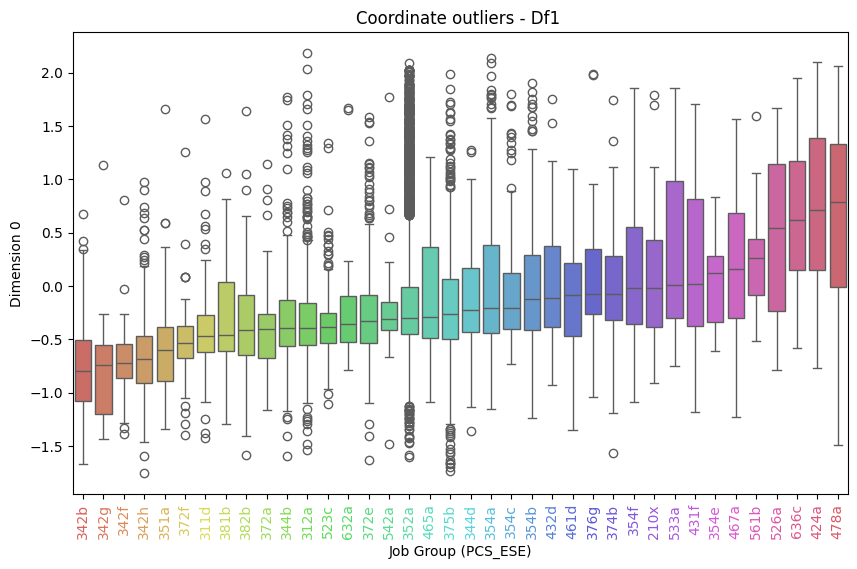

In [222]:
plot_boxplot(df_list_15[0], 'PCS_ESE', value_col='0', df_number = 1)

In [198]:
# Create a dictionary from 'PCS_ESE' to 'PCS_ESE_name'
pcs_ese_to_name = df1.set_index('PCS_ESE')['PCS_ESE_name'].to_dict()

# Function to get the name for a given code
def get_name_for_code(code):
    return pcs_ese_to_name.get(code, "Code not found")

# Test the function
code = '523c'
print(f"The name for code {code} is {get_name_for_code(code)}")

The name for code 523c is Adjoints administratifs des collectivités locales


Problematic job groups include:
- 352a Journalistes (y c. rédacteurs en chef) 
- 375b Cadres des relations publiques et de  la communication
- 312a Avocats
- 344b Médecins salariés non hospitaliers
- 372e Juristes


Outliers measured on the basis of coordinates per group. It could seem like especially these job groups are not that consistent, which might bias the estimates later on in the process.

### OLS Assumption checks for non hierarchical multiple Lin Reg

1. Linearity of outcome var and predictor vars
2. Homoscedasticity - Equal variance
3. Normality of error distribution
4. Independent observations, no autocorrelation 
5. Predictors are not correlated with each other
6. Outliers should not be present too far


https://medium.com/@shuv.sdr/multiple-linear-regression-in-python-4ee79d763e8f



Violations.
4. (observations k and n have nothing in common that the regression model is not already accounting for) - Since we're dealing with grouped data, we likely violate this assumption. 

Model formula: 

Income ~ dim1 + dim2 + dim3, data = [m1...m9]

Something to note:
"The 
𝑋s should be fixed (e. independent variables should impact dependent variables). It should not be the case that dependent variables impact independent variables. This is because, in regression models, the causal relationship is studied and there is not a correlation between the two variables. For example, if you run the regression with inflation as your dependent variable and unemployment as the independent variable, the OLS estimators are likely to be incorrect because with inflation and unemployment, we expect correlation rather than a causal relationship."

In our case, SES and Income cannot really be saparated, because income is a part of the factors used to determine someone's SES. As such, if this assumption was to hold for all regression models, we should not really do a regression, but rather do a correlation analysis. 

#### 1 Linearity of independent and dependent variables - Not really

As the value of the X increases, the value of y should also increase or decrease linearly. If there are multiple independent features, each of the independent features should have a linear relationship with the dependent feature.

I find that none of the predictors, regardless of the data frame (model) used, displays a very clear linear relationship. This is partly because of the large degree of variation within estimates for groups. However, there might be some linear tendencies, suggesting we could use regression to do the model comparison.

/tmp/ipykernel_2047392/2536189960.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(df.loc[df['color'] == color, predictor], df.loc[df['color'] == color, outcome],


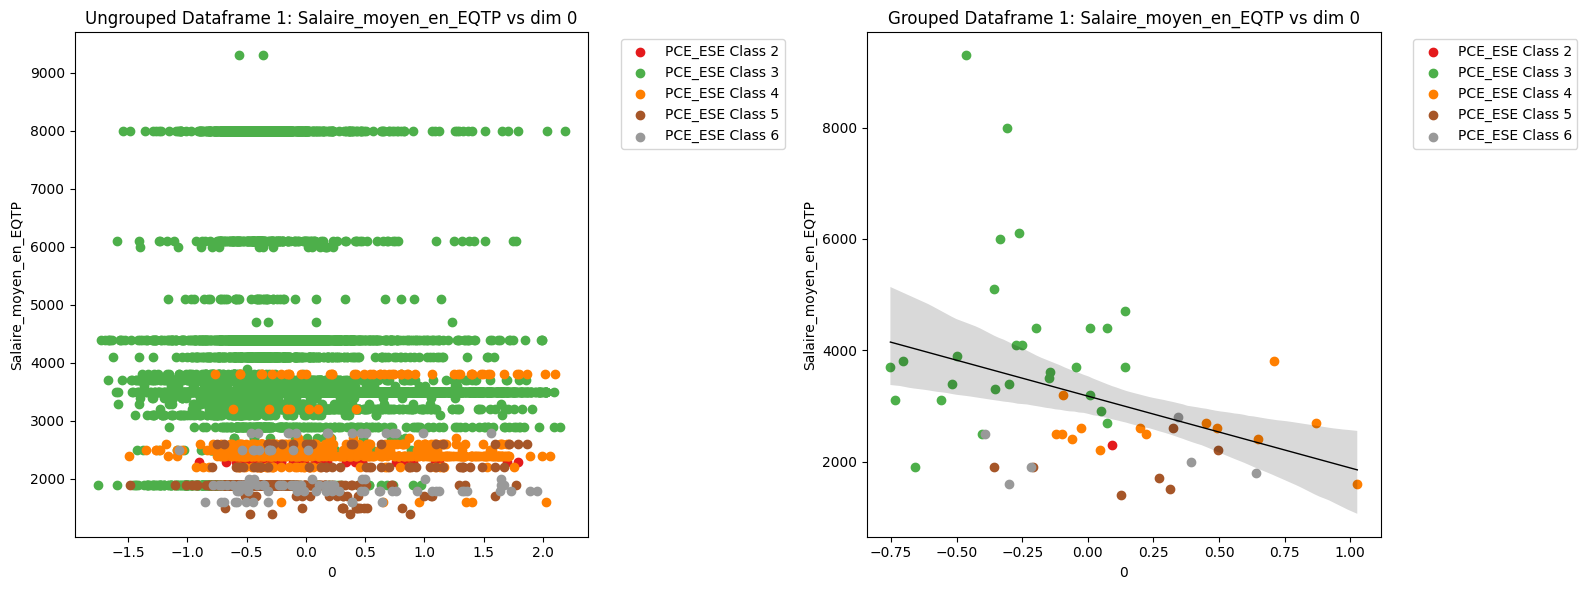

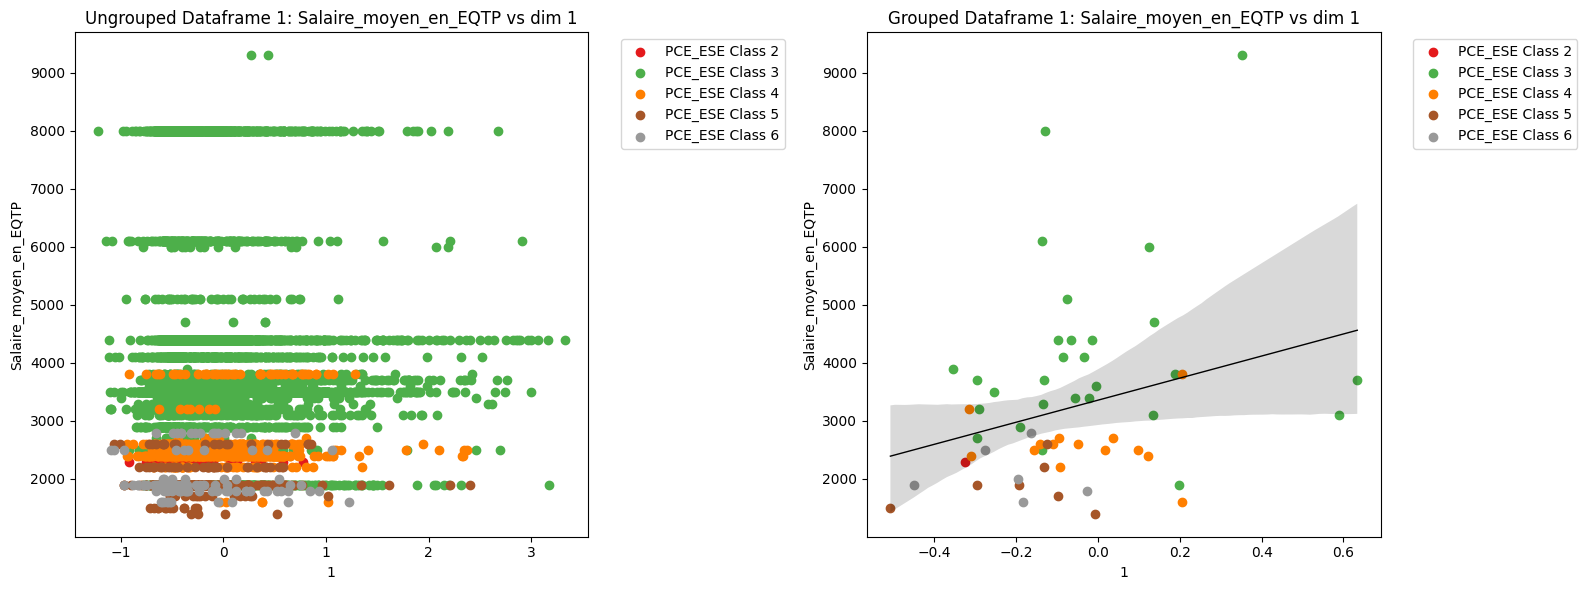

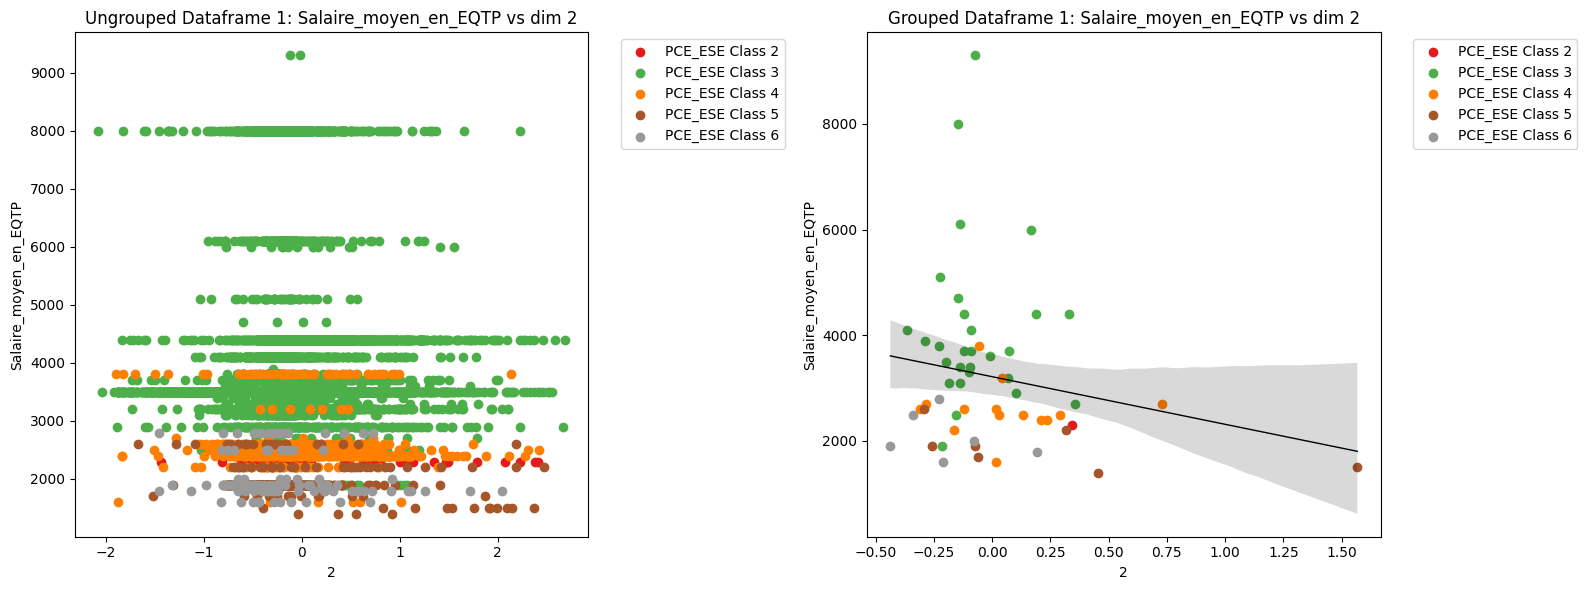

/tmp/ipykernel_2047392/2536189960.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(df.loc[df['color'] == color, predictor], df.loc[df['color'] == color, outcome],


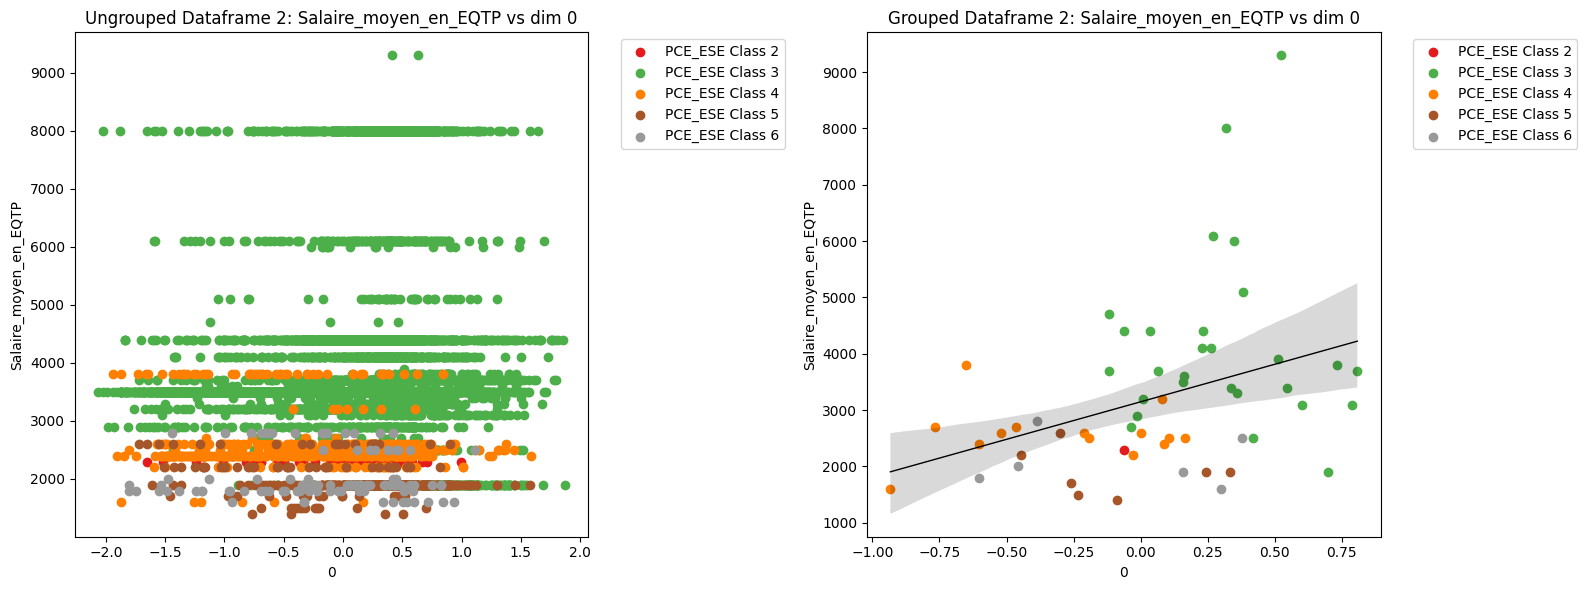

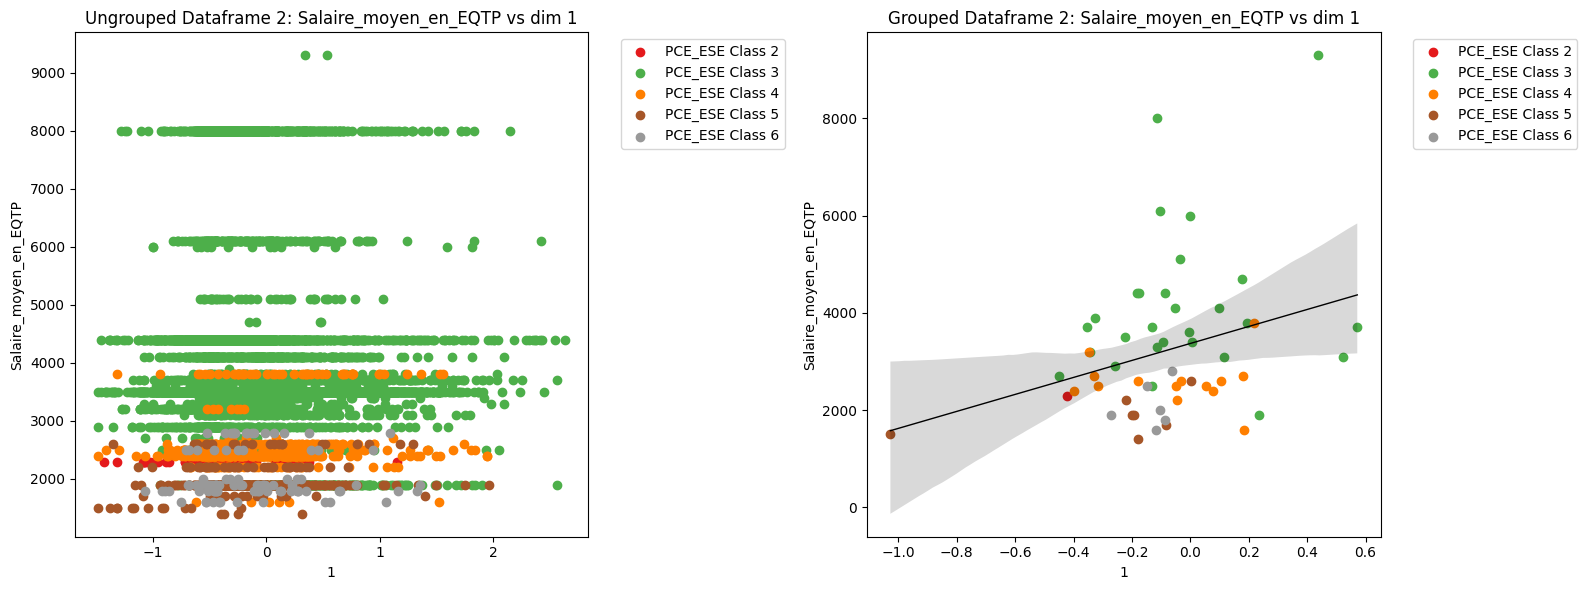

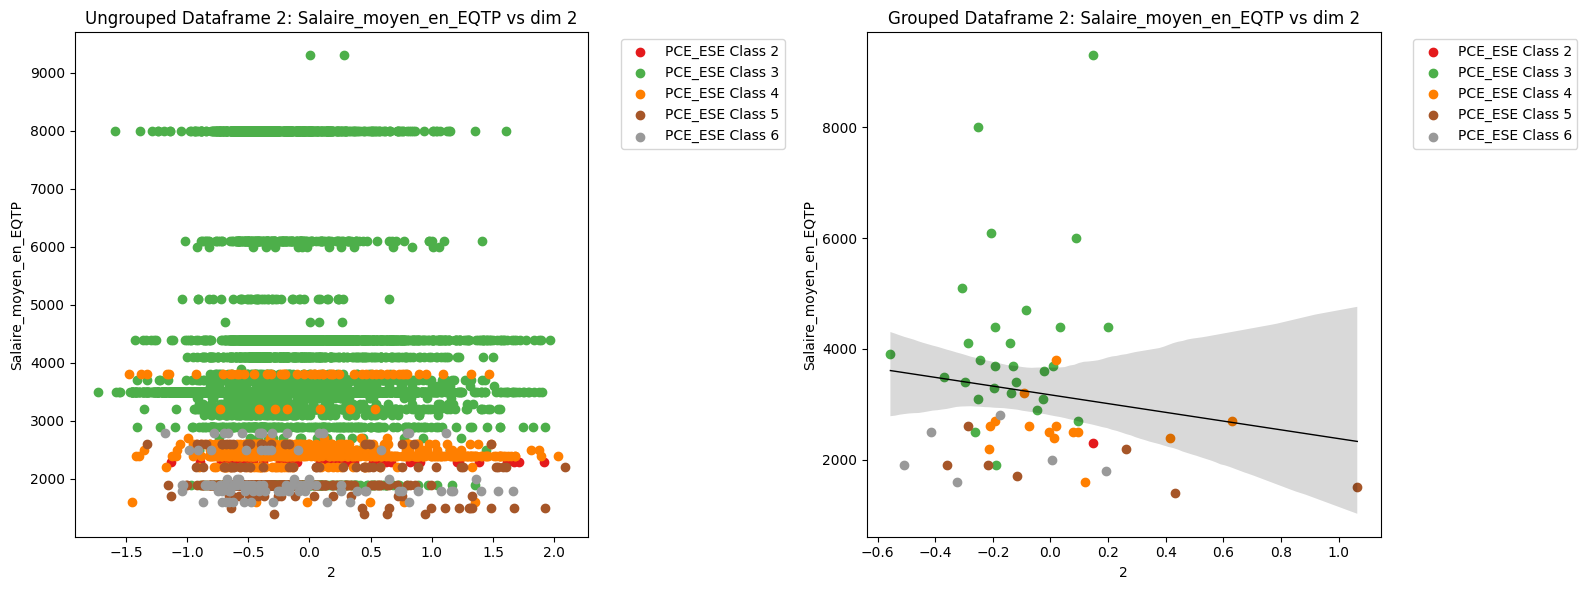

/tmp/ipykernel_2047392/2536189960.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(df.loc[df['color'] == color, predictor], df.loc[df['color'] == color, outcome],


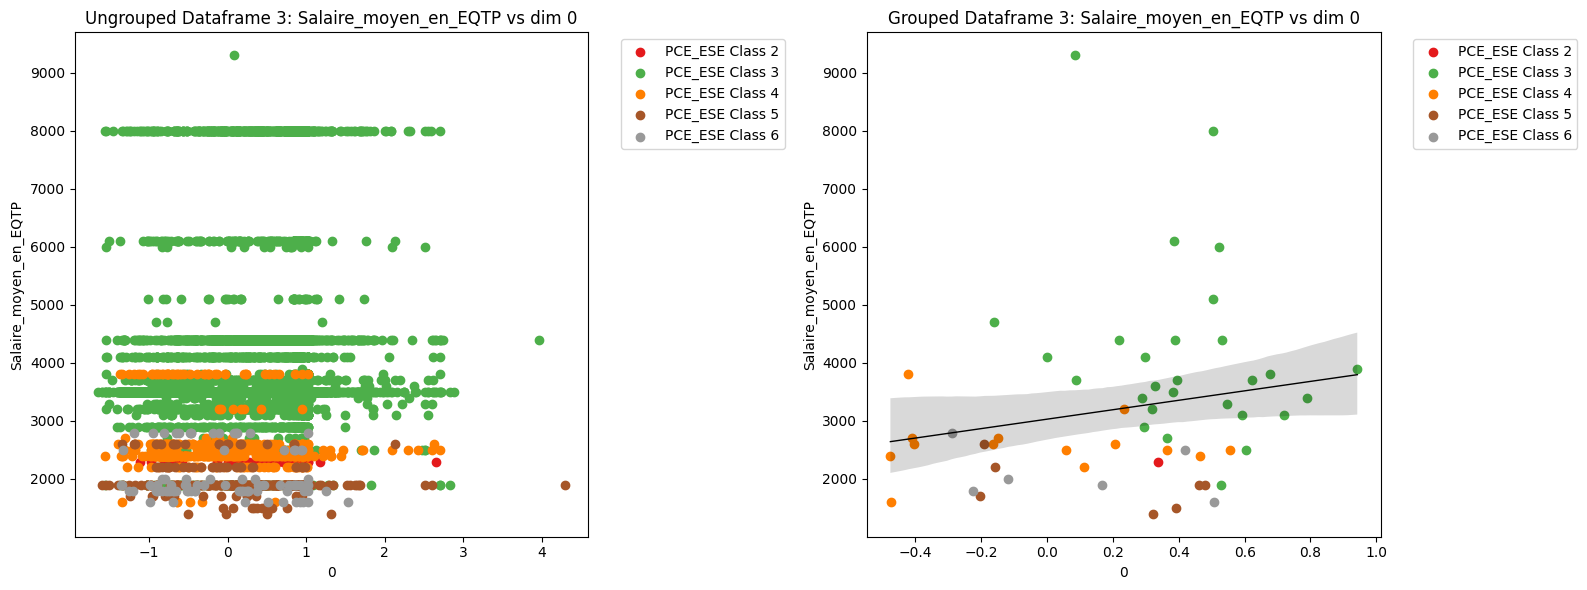

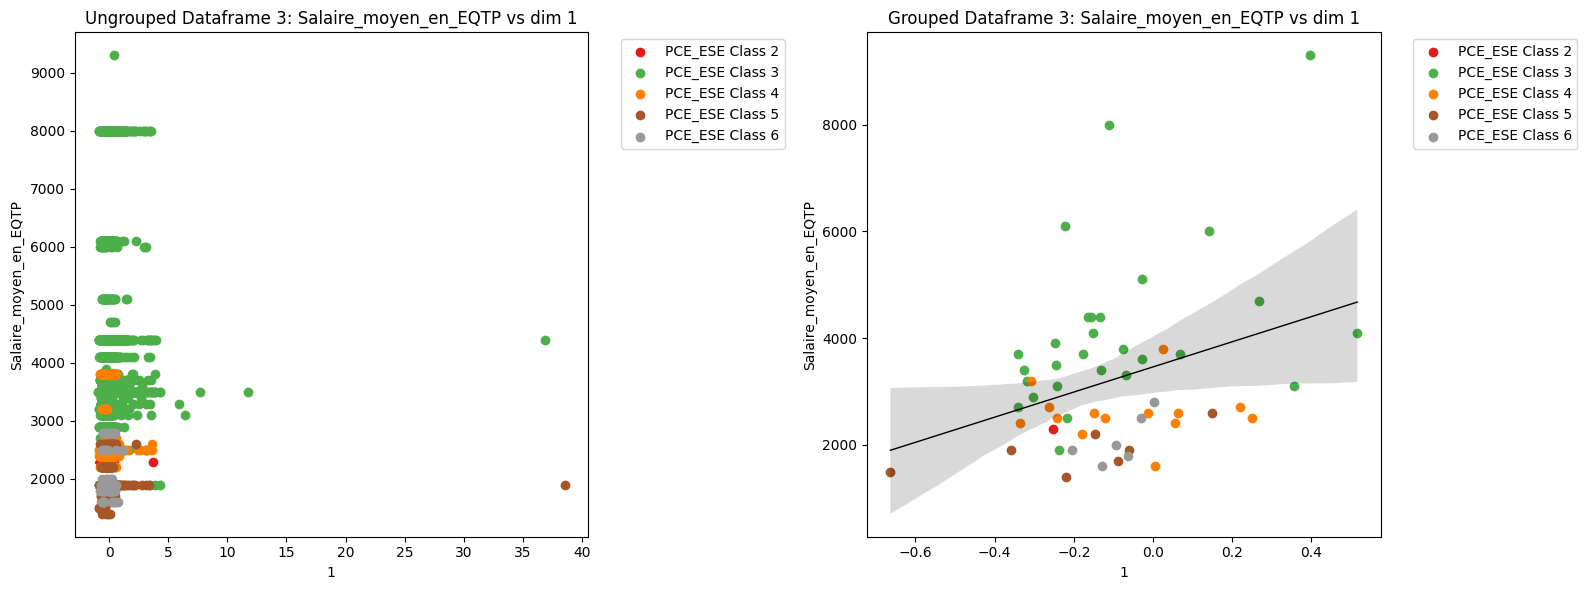

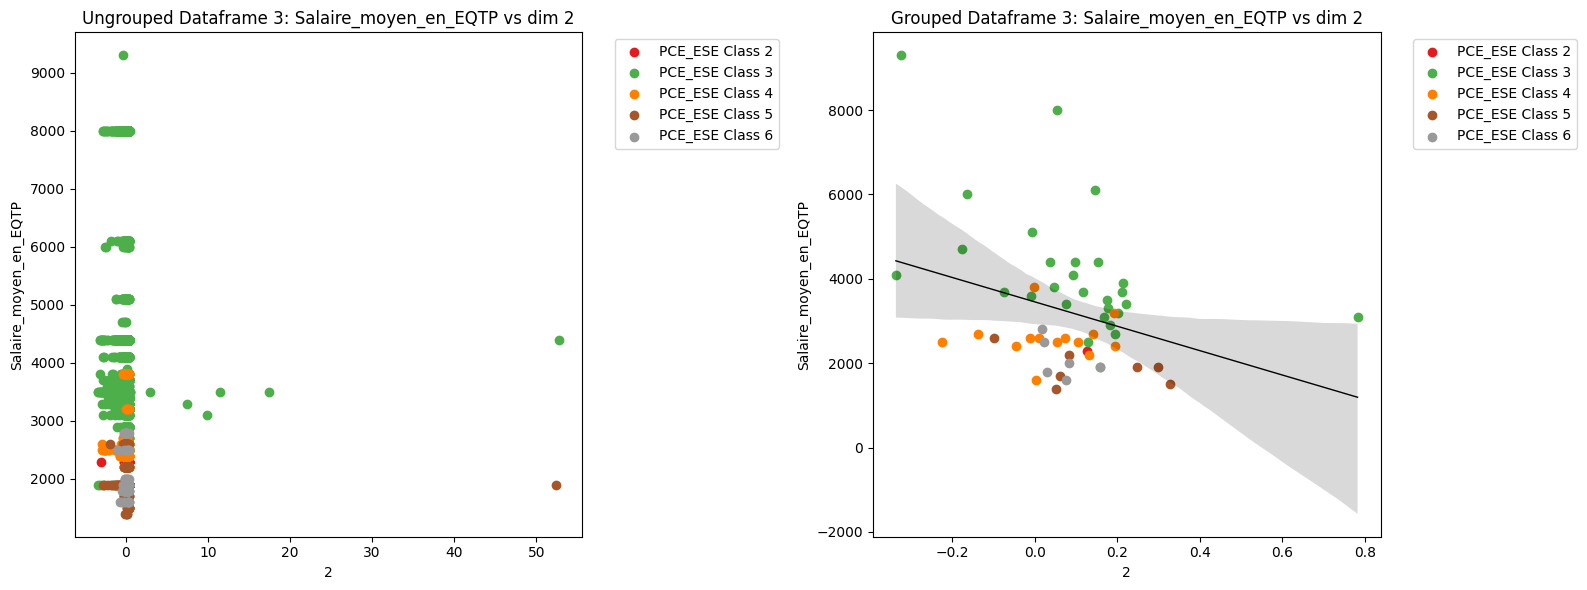

/tmp/ipykernel_2047392/2536189960.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(df.loc[df['color'] == color, predictor], df.loc[df['color'] == color, outcome],


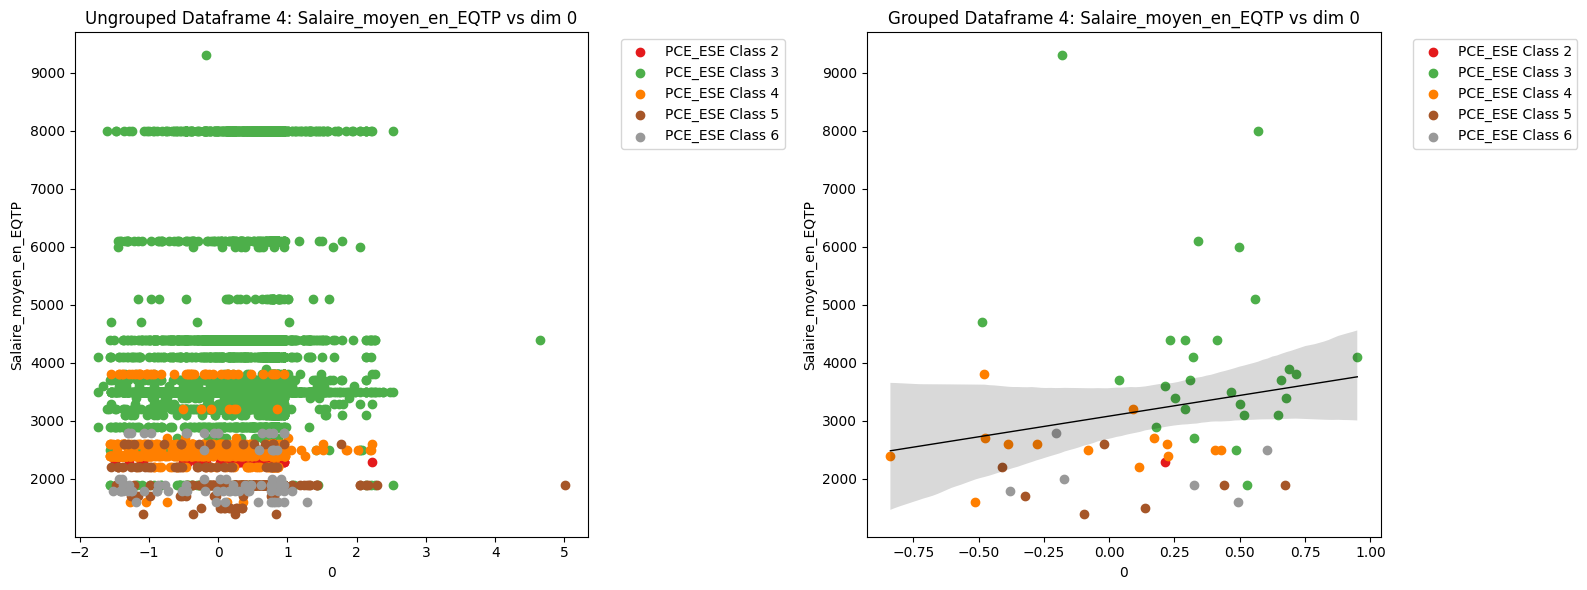

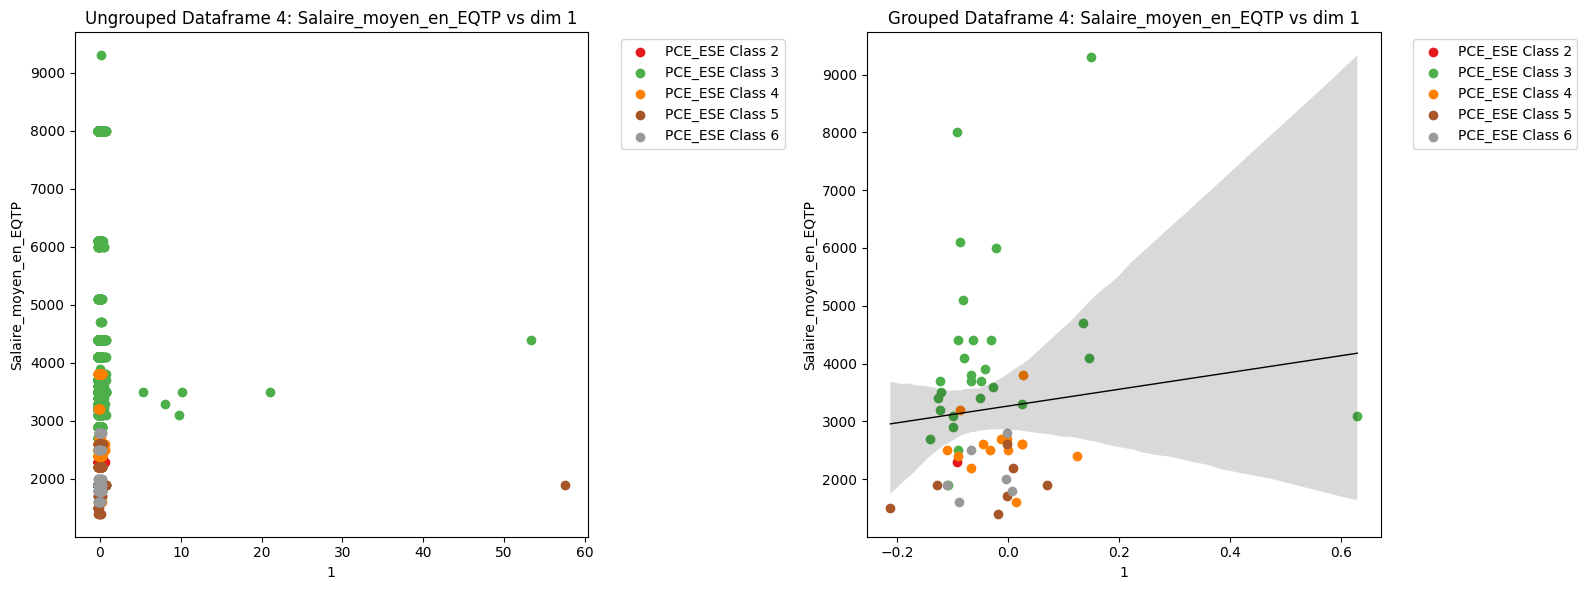

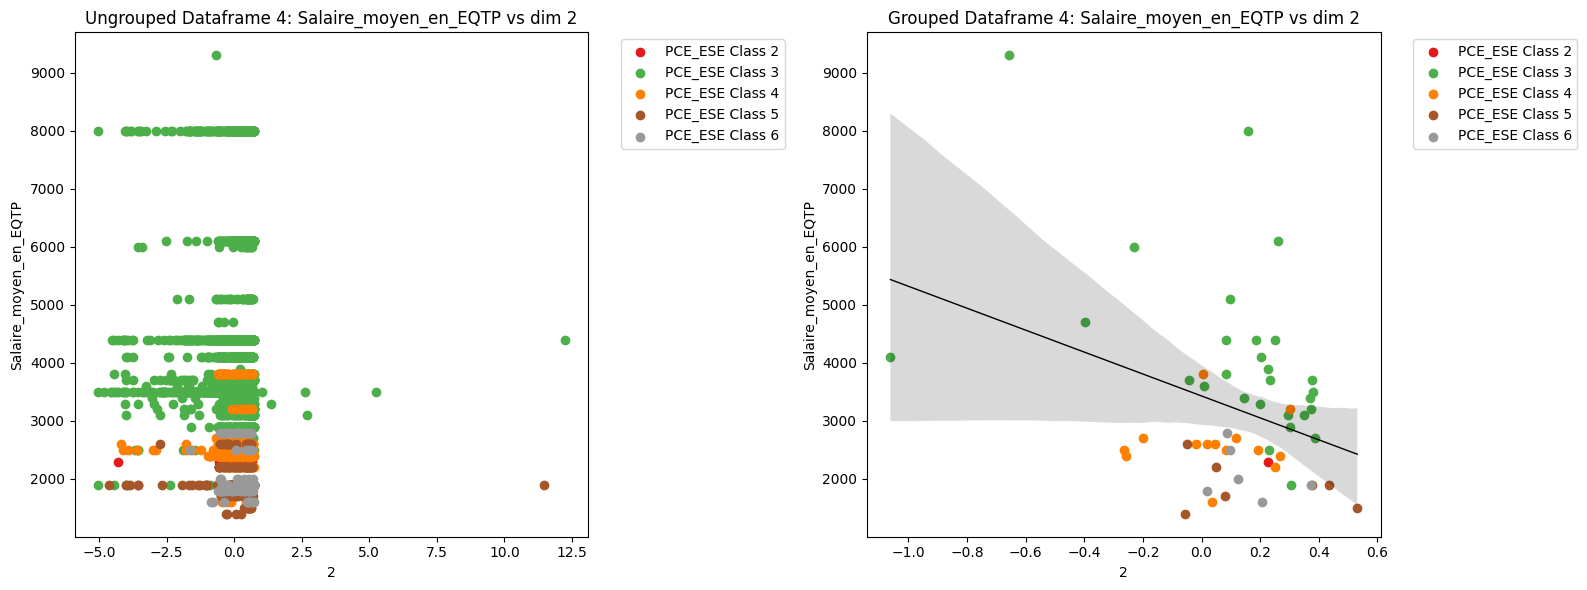

/tmp/ipykernel_2047392/2536189960.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(df.loc[df['color'] == color, predictor], df.loc[df['color'] == color, outcome],


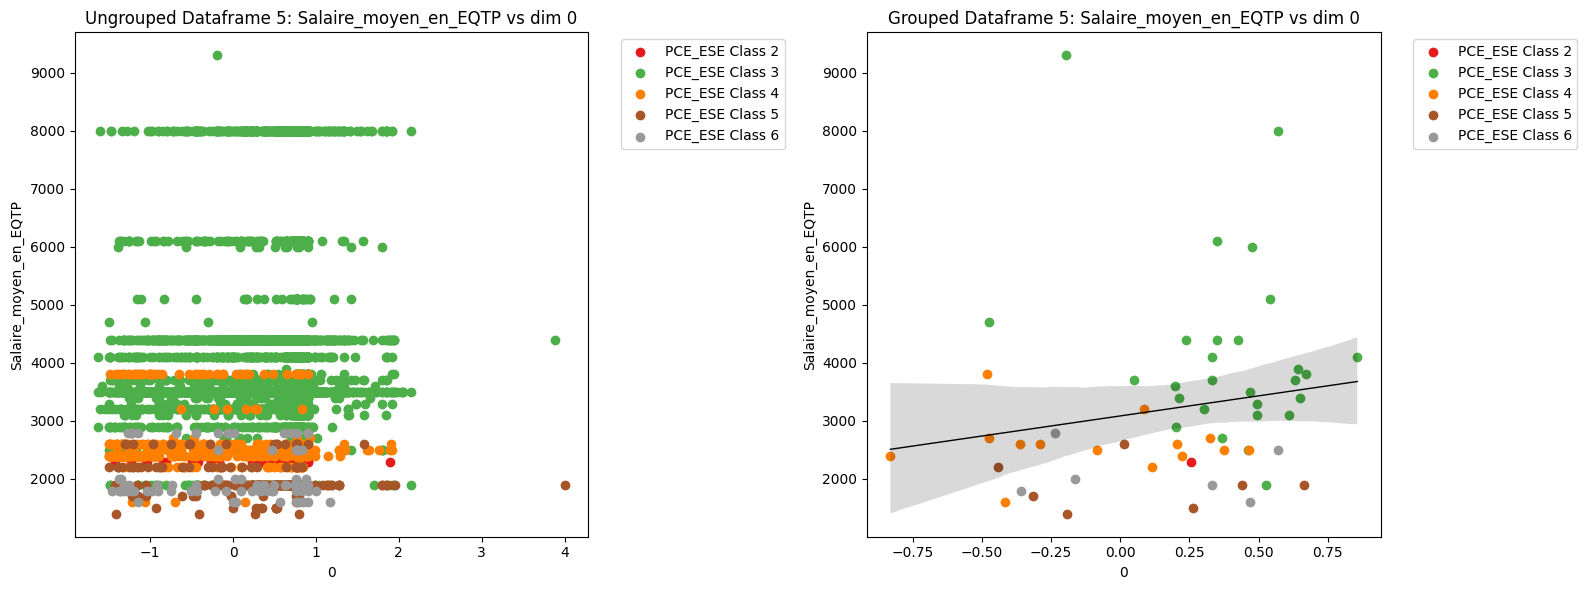

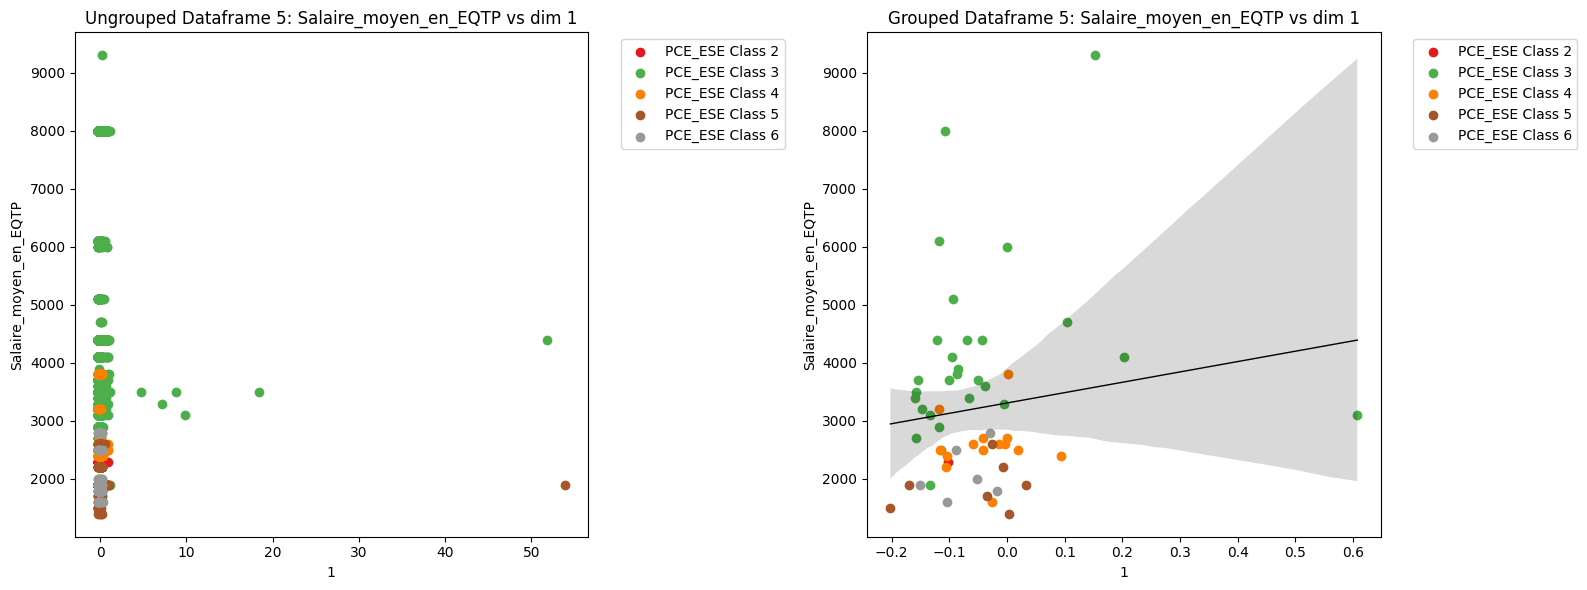

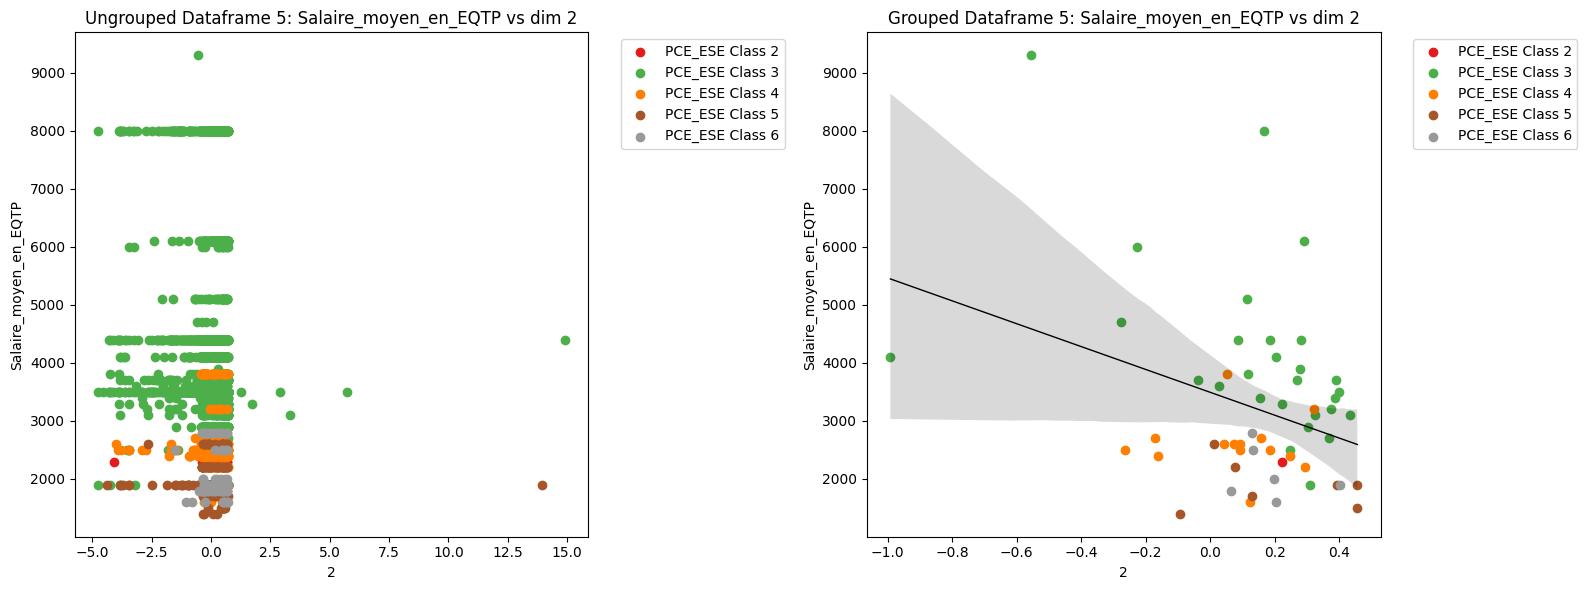

/tmp/ipykernel_2047392/2536189960.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(df.loc[df['color'] == color, predictor], df.loc[df['color'] == color, outcome],


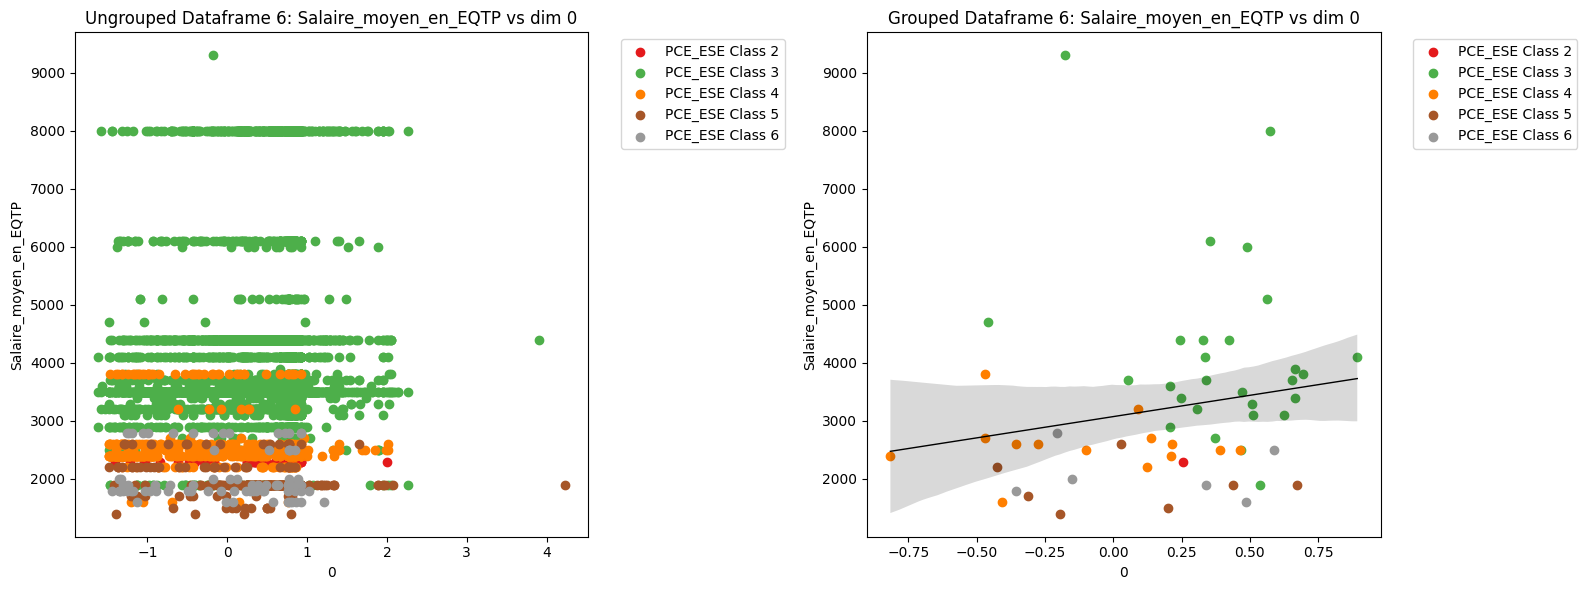

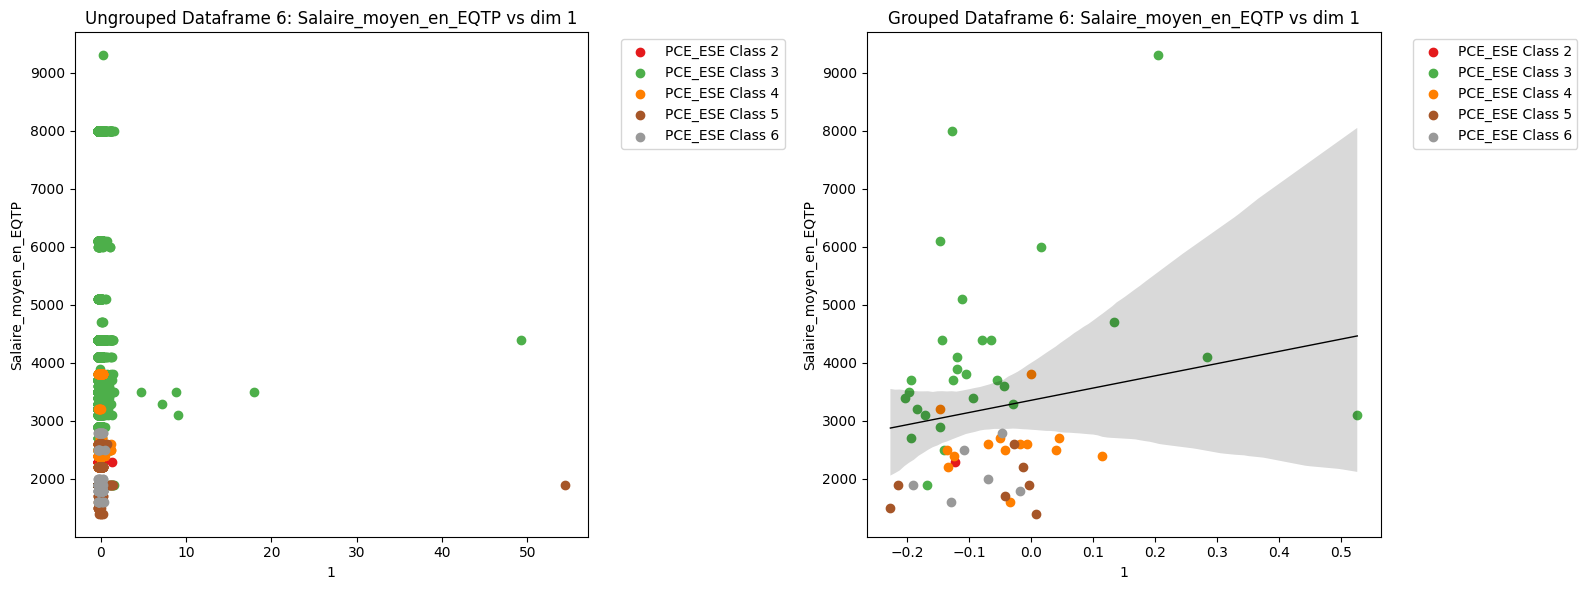

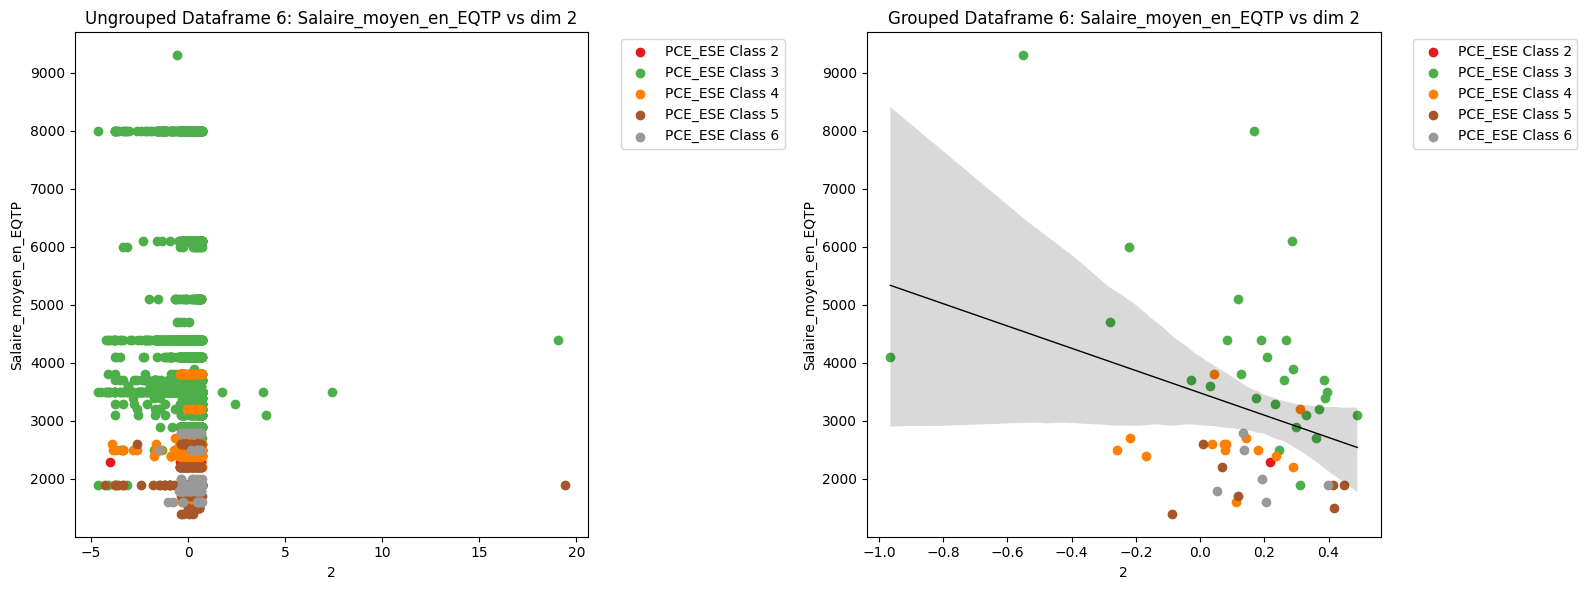

/tmp/ipykernel_2047392/2536189960.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(df.loc[df['color'] == color, predictor], df.loc[df['color'] == color, outcome],


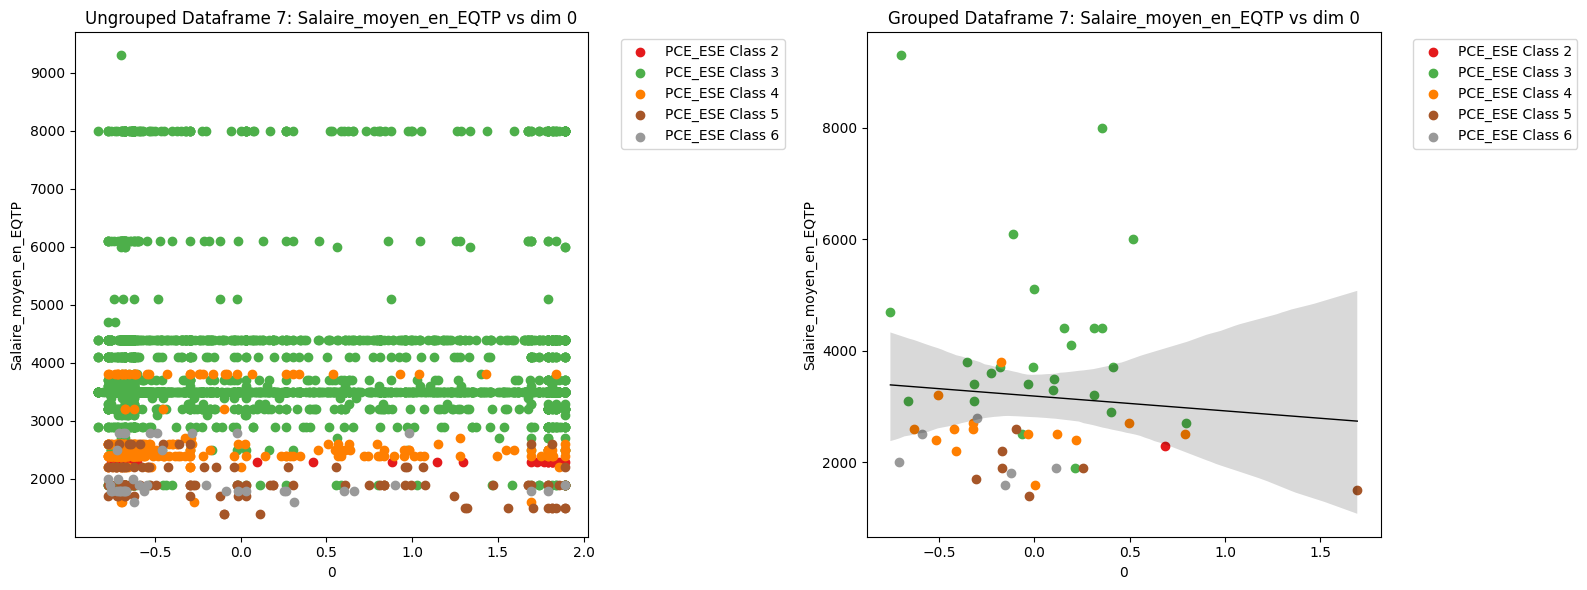

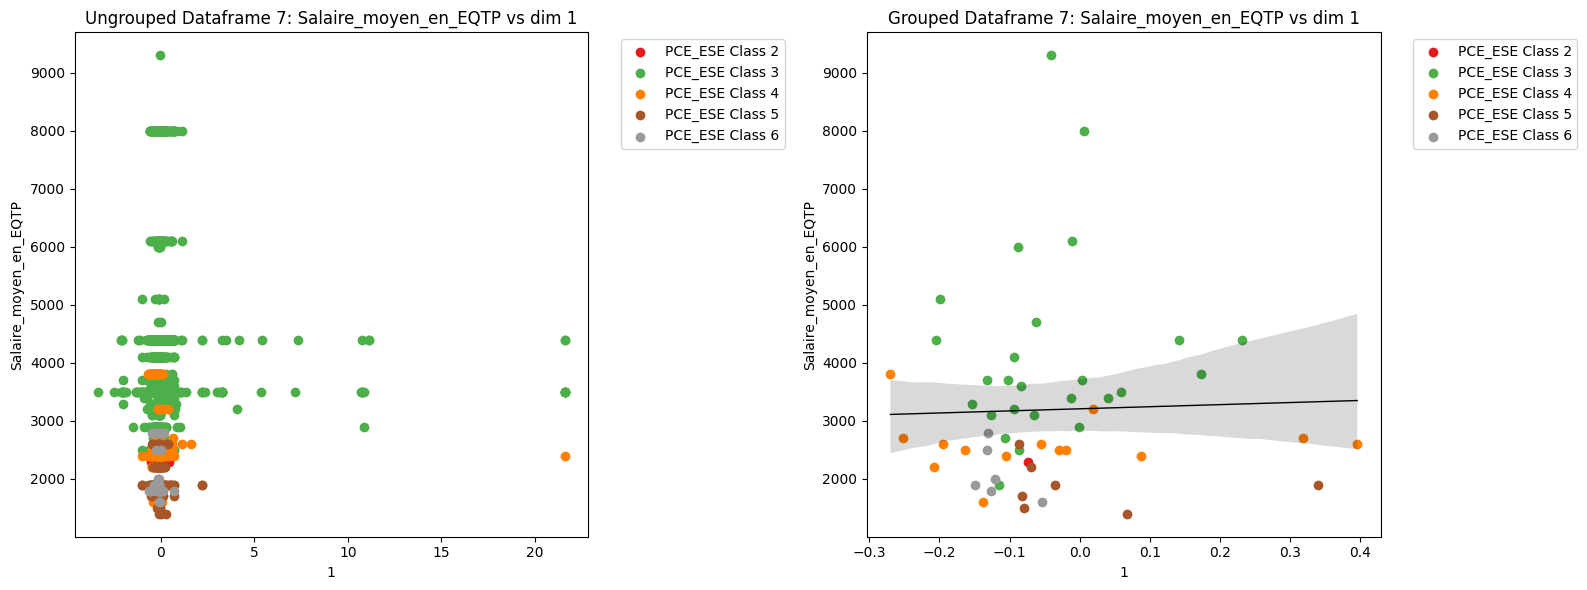

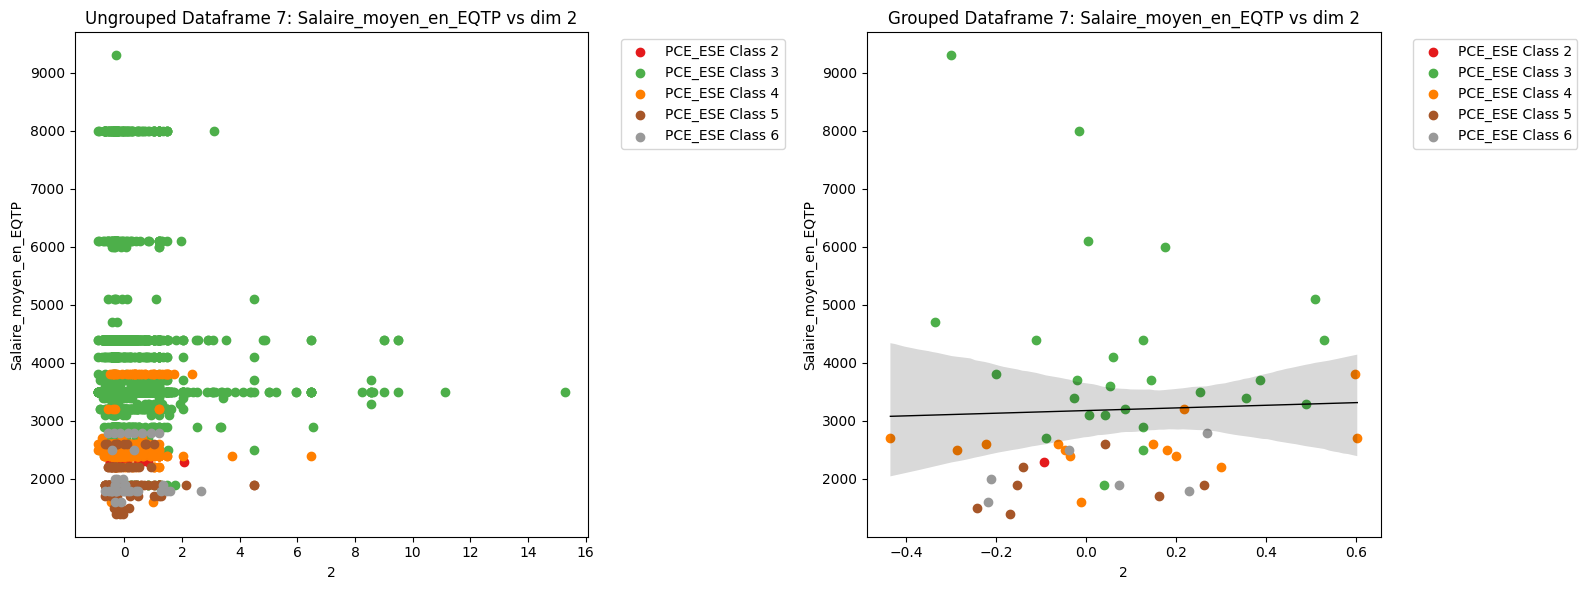

/tmp/ipykernel_2047392/2536189960.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(df.loc[df['color'] == color, predictor], df.loc[df['color'] == color, outcome],


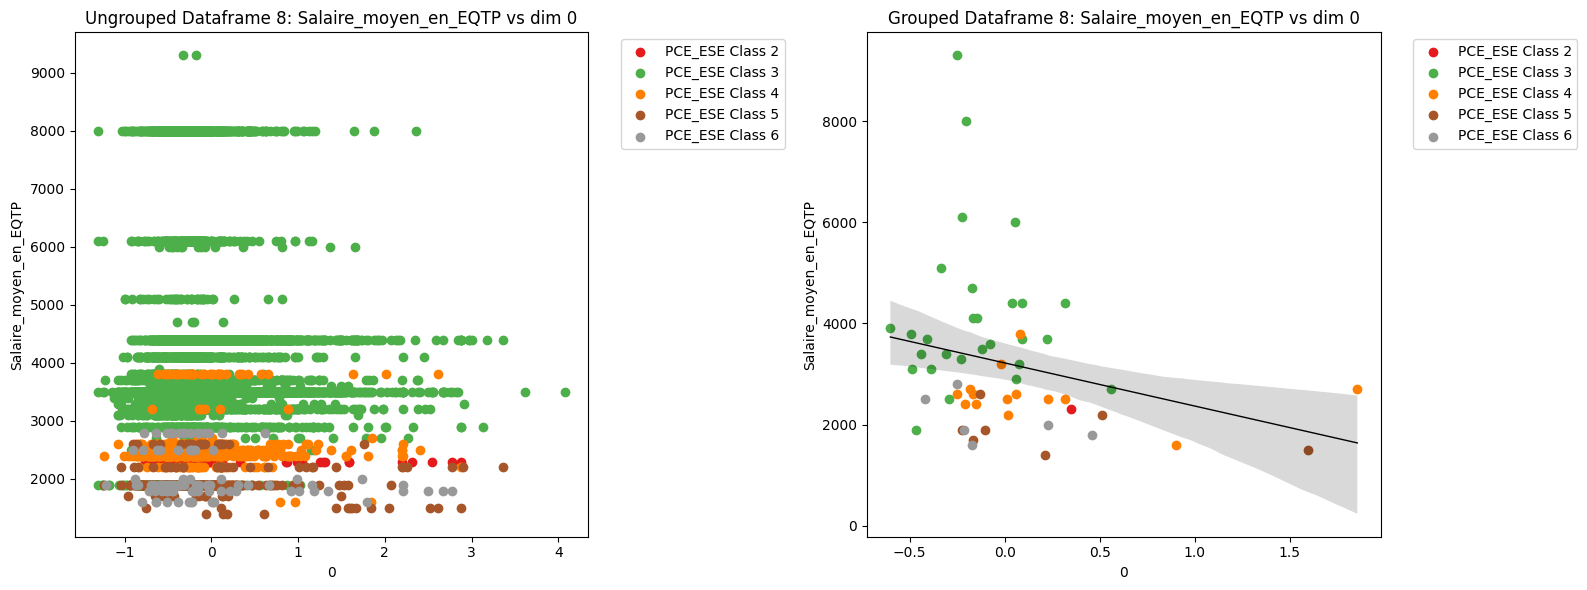

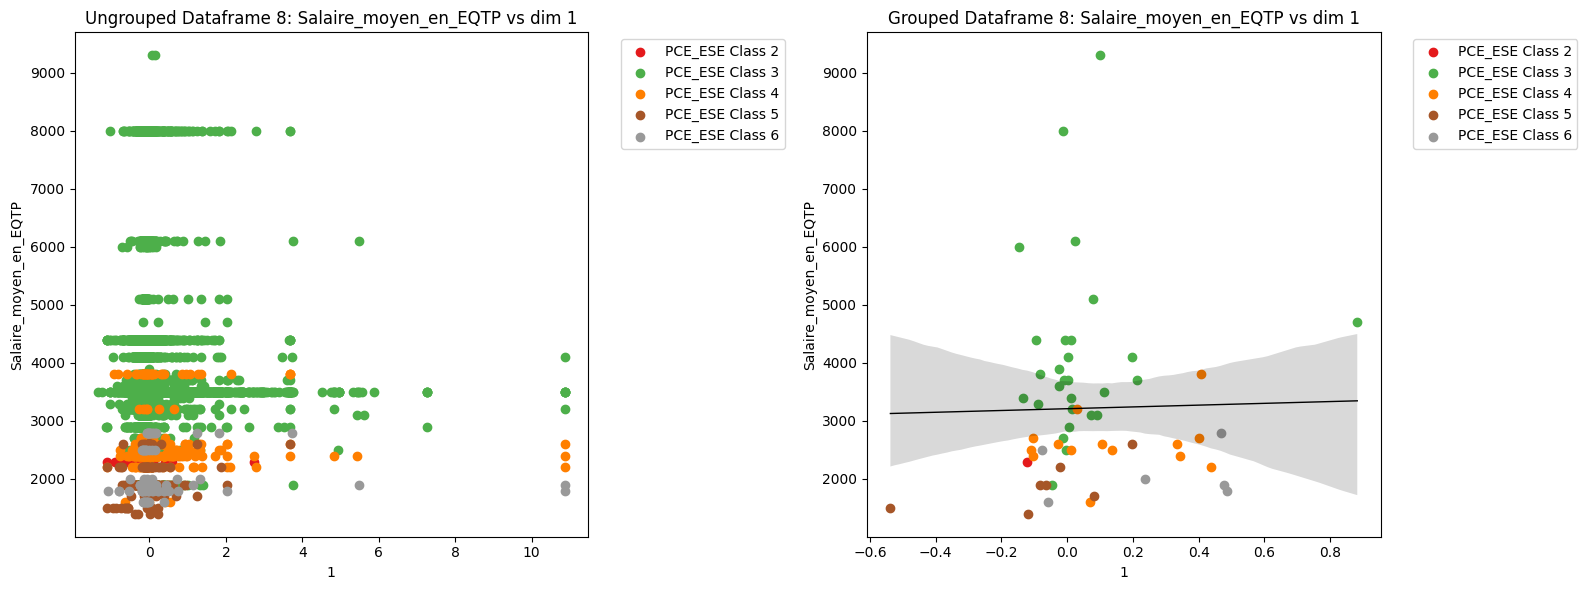

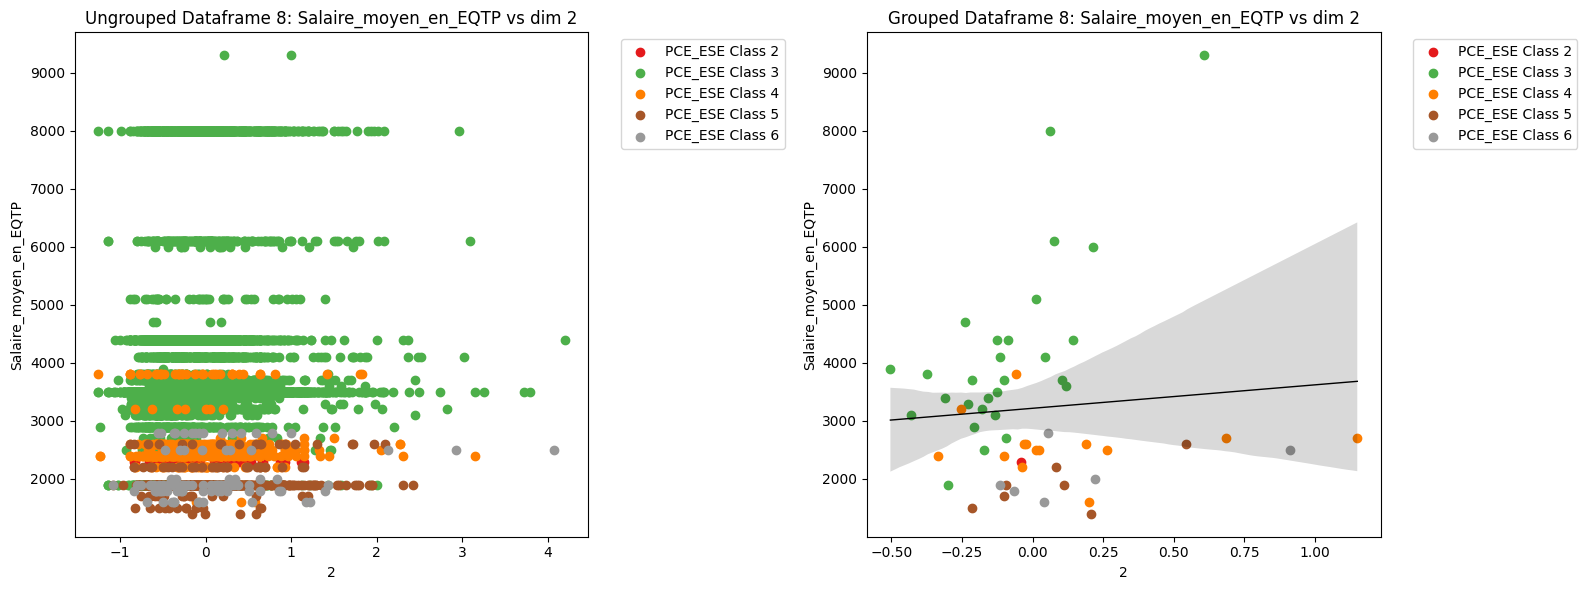

/tmp/ipykernel_2047392/2536189960.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(df.loc[df['color'] == color, predictor], df.loc[df['color'] == color, outcome],


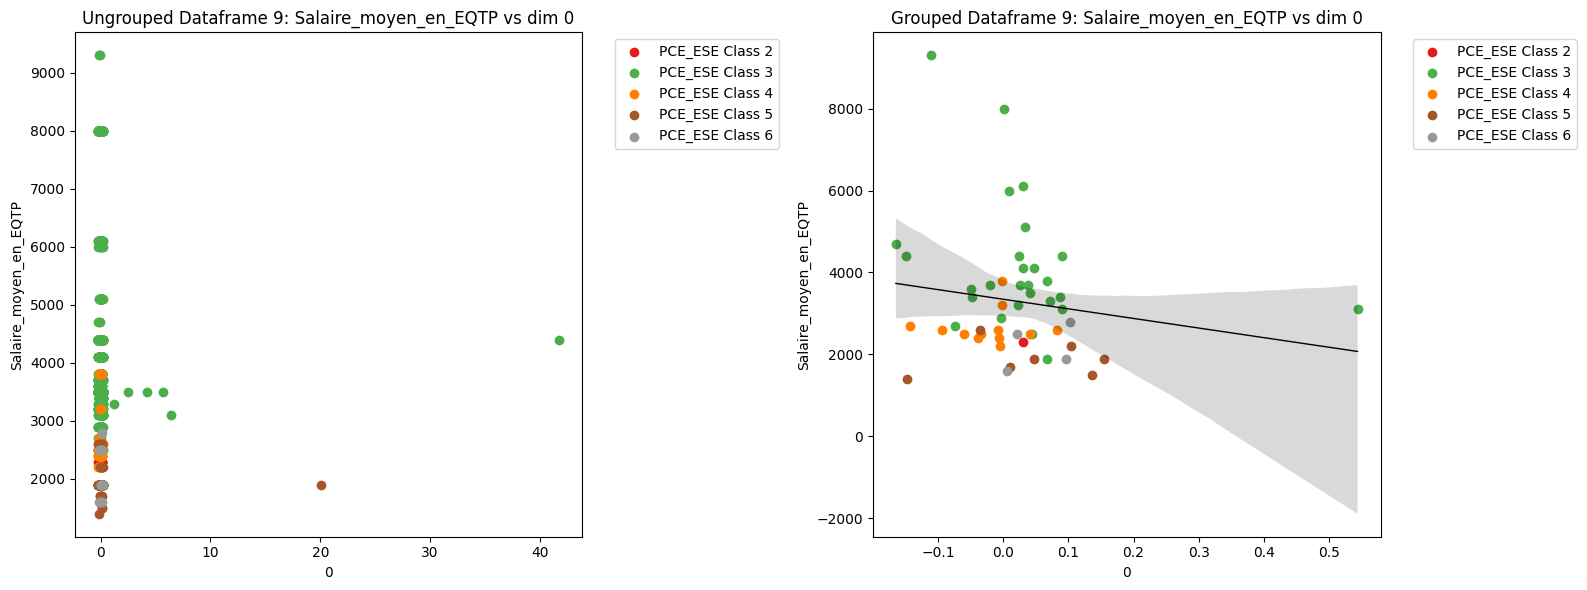

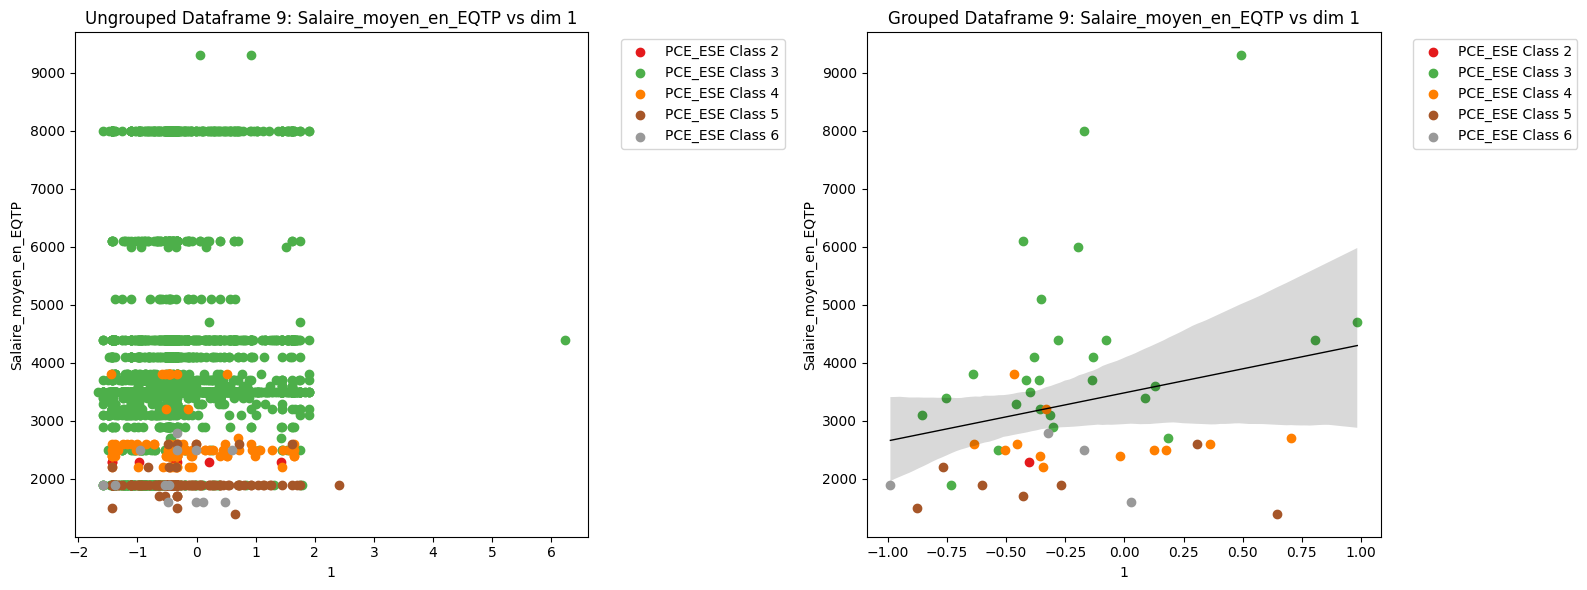

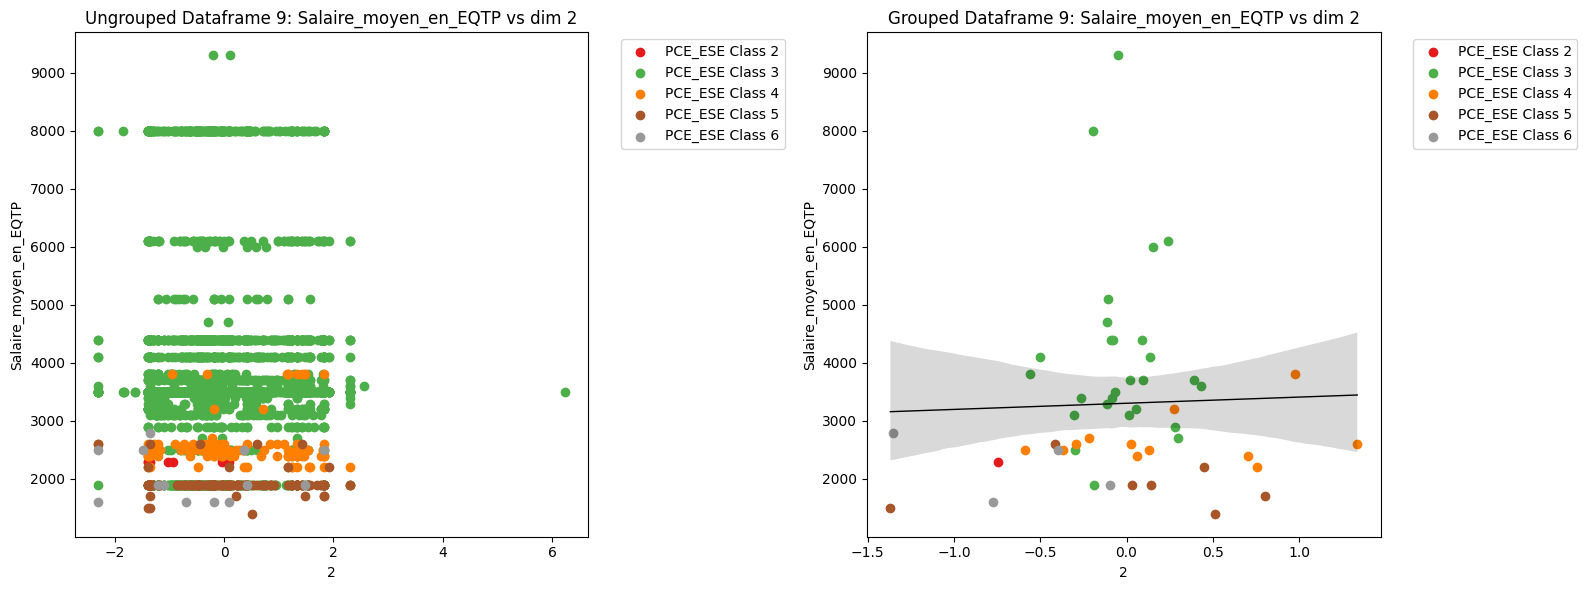

In [105]:
import seaborn as sns

## Not log transformed
outcome = 'Salaire_moyen_en_EQTP'
predictors = ['0', '1', '2']

# Define a color map
color_map = {str(i): plt.cm.Set1((i-2) / 4.) for i in range(2, 7)}

# Get unique color categories
color_categories = np.unique(np.concatenate([df['PCS_ESE'].str[0].unique() for df in dfs]))

# Plot scatter plots for each dataframe
for i, df in enumerate(dfs):
    df['color'] = df['PCS_ESE'].str[0].astype(str)  # Ungrouped data
    grouped_df = df.groupby('PCS_ESE')[predictors + [outcome]].mean()  # Grouped data
    grouped_df['color'] = grouped_df.index.str[0].astype(str)
    
    for predictor in predictors:
        plt.figure(figsize=(16, 6))
        
        # Ungrouped data
        plt.subplot(1, 2, 1)
        for color in color_categories:
            plt.scatter(df.loc[df['color'] == color, predictor], df.loc[df['color'] == color, outcome], 
                        c=color_map[color], label=f'PCE_ESE Class {color}')
        plt.xlabel(predictor)
        plt.ylabel(outcome)
        plt.title(f'Ungrouped Dataframe {i+1}: {outcome} vs dim {predictor}')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Grouped data
        plt.subplot(1, 2, 2)
        for color in color_categories:
            plt.scatter(grouped_df.loc[grouped_df['color'] == color, predictor], 
                        grouped_df.loc[grouped_df['color'] == color, outcome], 
                        color=color_map[color], label=f'PCE_ESE Class {color}')
        sns.regplot(x=grouped_df[predictor], y=grouped_df[outcome], 
                    color='black', scatter=False, ci=95, line_kws={'linewidth': '1'})
        plt.xlabel(predictor)
        plt.ylabel(outcome)
        plt.title(f'Grouped Dataframe {i+1}: {outcome} vs dim {predictor}')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        plt.show()

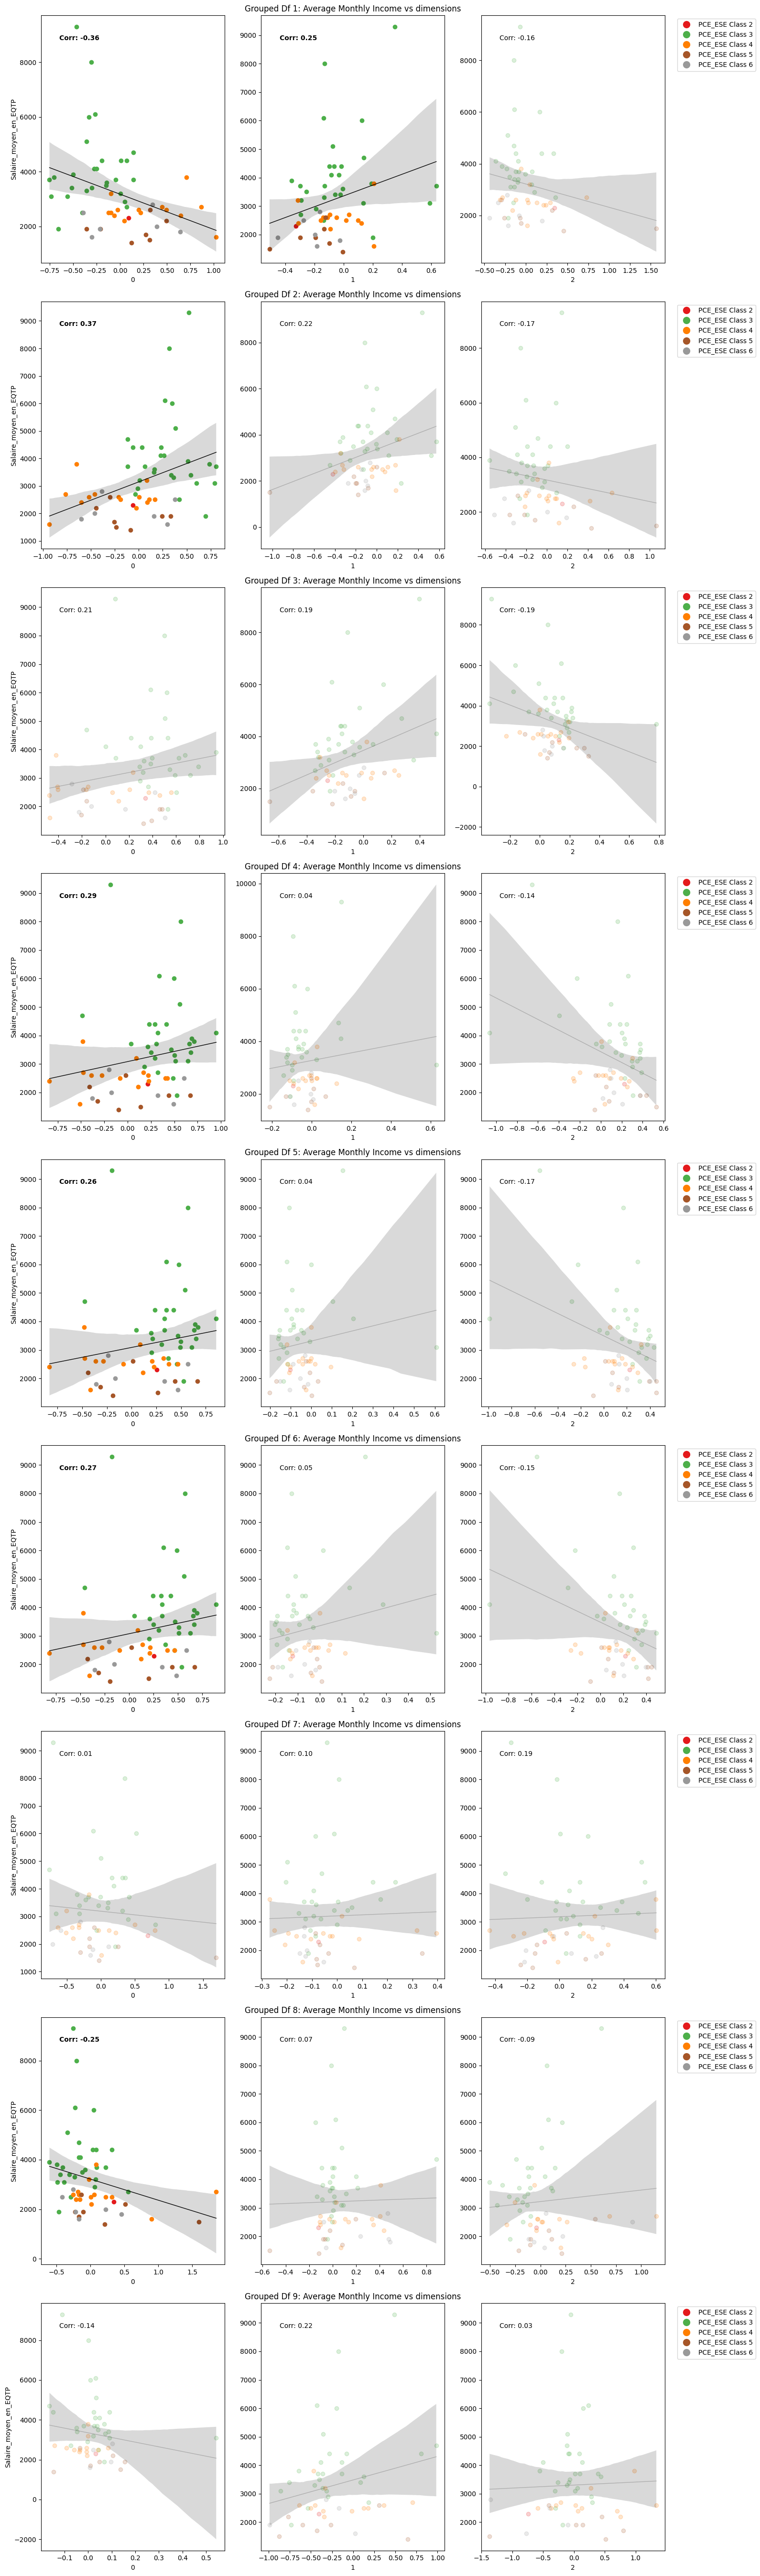

In [244]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from scipy.stats import spearmanr


outcome = 'Salaire_moyen_en_EQTP'
predictors = ['0', '1', '2']

# Define a color map
color_map = {str(i): plt.cm.Set1((i-2) / 4.) for i in range(2, 7)}

# Get unique color categories
color_categories = np.unique(np.concatenate([df['PCS_ESE'].str[0].unique() for df in dfs]))

# Create a grid of plots
fig, axes = plt.subplots(len(dfs), len(predictors), figsize=(16, 6*len(dfs)))



for i, df in enumerate(dfs):
    df = df.copy()
    df['color'] = df['PCS_ESE'].str[0].astype(str)  # Ungrouped data
    grouped_df = df.groupby('PCS_ESE')[predictors + [outcome]].mean()  # Grouped data
    grouped_df['color'] = grouped_df.index.str[0].astype(str)
    
    for j, predictor in enumerate(predictors):
        ax = axes[i][j]  # Corrected indexing here
        
        # Calculate correlation and adjust alpha based on it
        corr, _ = spearmanr(grouped_df[predictor], grouped_df[outcome])  # Use Spearman's correlation
        alpha = 1.0 if abs(corr) >= 0.25 else 0.2  # Decrease alpha for low correlation
        
        # Grouped data
        for color in color_categories:
            ax.scatter(grouped_df.loc[grouped_df['color'] == color, predictor], 
                       grouped_df.loc[grouped_df['color'] == color, outcome], 
                       color=color_map[color], alpha=alpha, label=f'PCE_ESE Class {color}')
        sns.regplot(x=grouped_df[predictor], y=grouped_df[outcome], 
                    color='black', scatter=False, ci=95, line_kws={'linewidth': '1', 'alpha': alpha}, ax=ax)
        ax.set_xlabel(predictor)
        
        # Only set y-label for the first subplot in each row
        if j == 0:
            ax.set_ylabel(outcome)
        else:
            ax.set_ylabel('')  # Set empty y-label for other subplots
        
        # Add correlation as text annotation
        if abs(corr) >= 0.25:
            ax.text(0.1, 0.9, f'Corr: {corr:.2f}', transform=ax.transAxes, weight='bold')
        else:
            ax.text(0.1, 0.9, f'Corr: {corr:.2f}', transform=ax.transAxes)
            ax.patch.set_alpha(0.3)  # Lower the alpha for other plots
        
        # Add title only to the middle subplot in each row
        if j == len(predictors) // 2:
            ax.set_title(f'Grouped Df {i+1}: Average Monthly Income vs dimensions')
        
        ## Add legend only to the last subplot in each row
        if j == len(predictors) - 1:
            # Create custom legend handles
            legend_handles = [mlines.Line2D([], [], color=color_map[color], marker='o', linestyle='None',
                                             markersize=10, label=f'PCE_ESE Class {color}') for color in color_categories]
            ax.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

Predicted vs observed outcome

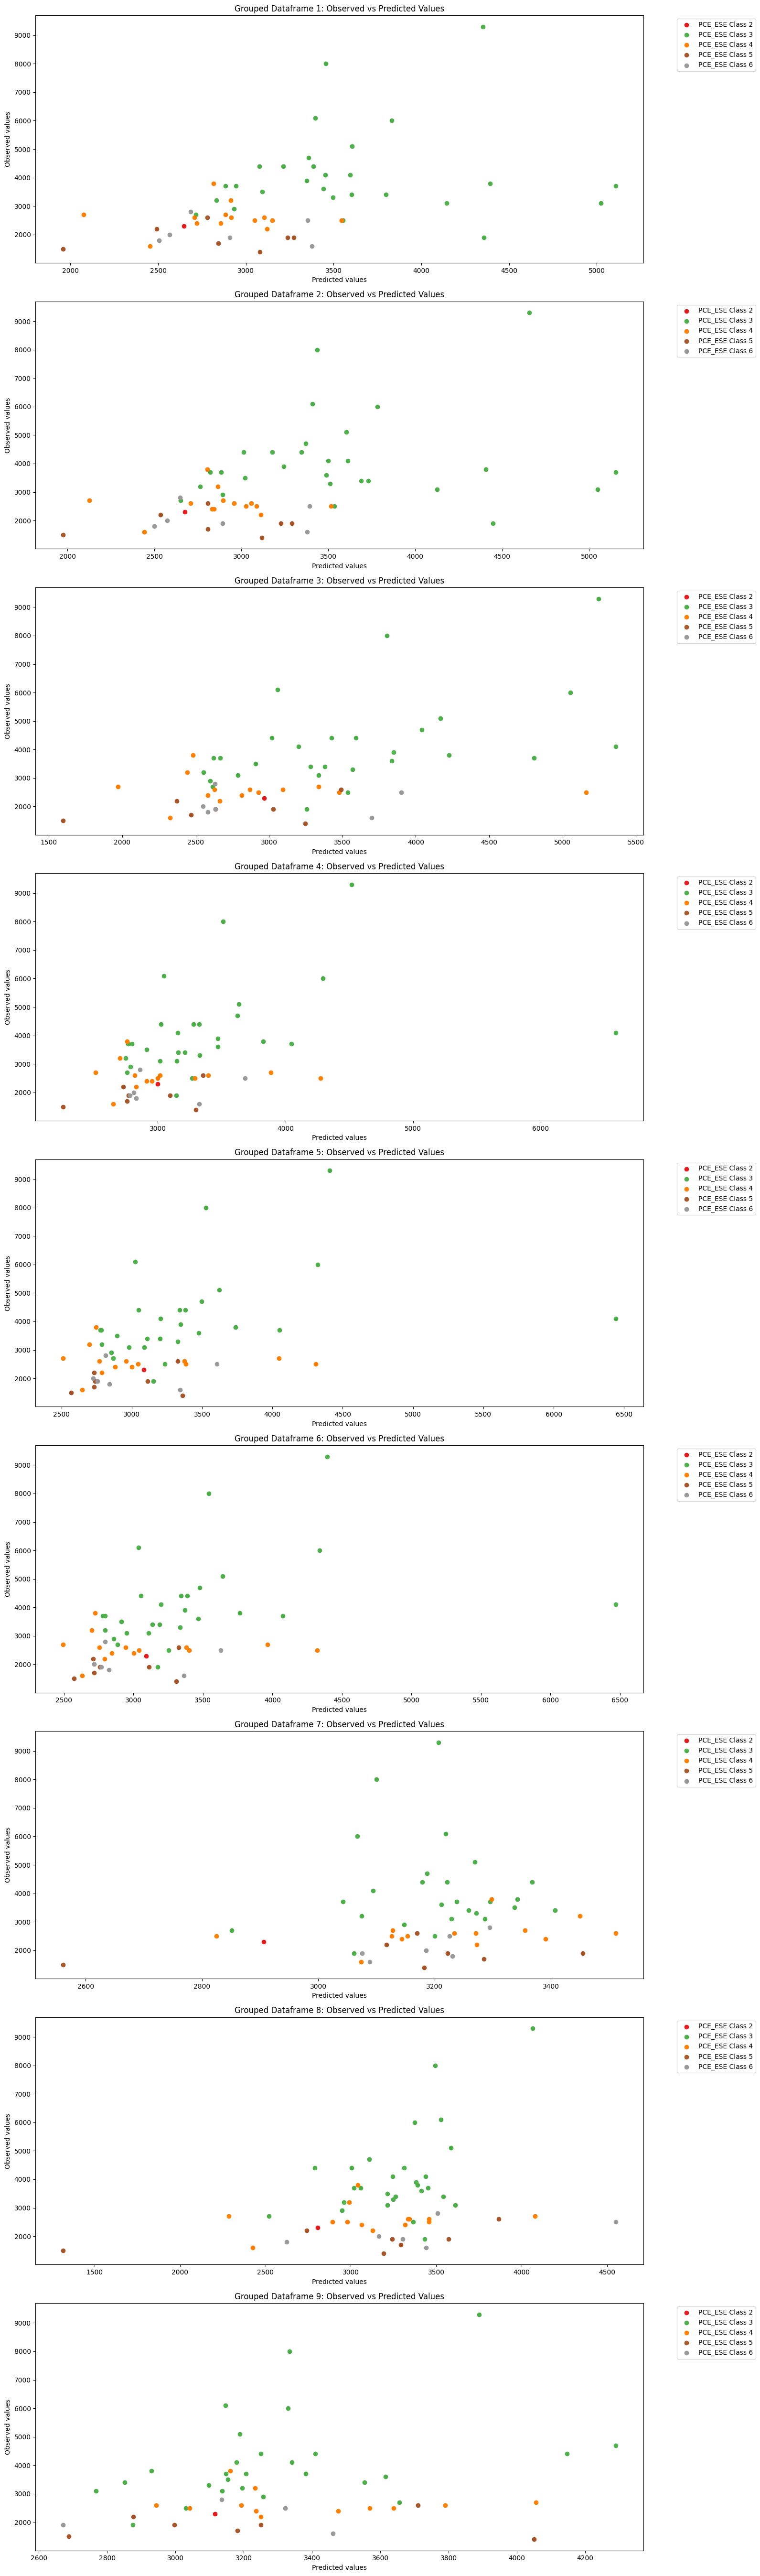

In [17]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

outcome = 'Salaire_moyen_en_EQTP'
predictors = ['0', '1', '2']

# Define a color map
color_map = {str(i): plt.cm.Set1((i-2) / 4.) for i in range(2, 7)}

# Get unique color categories
color_categories = np.unique(np.concatenate([df['PCS_ESE'].str[0].unique() for df in dfs]))

# Create a grid of plots
fig, axes = plt.subplots(len(dfs), 1, figsize=(16, 6*len(dfs)))

for i, df in enumerate(dfs):
    df['color'] = df['PCS_ESE'].str[0].astype(str)  # Ungrouped data
    grouped_df = df.groupby('PCS_ESE')[predictors + [outcome]].mean()  # Grouped data
    grouped_df['color'] = grouped_df.index.str[0].astype(str)
    
    # Fit an initial OLS model
    X = sm.add_constant(grouped_df[predictors])  # Adding the intercept term
    y = grouped_df[outcome]
    model = sm.OLS(y, X)
    results = model.fit()

    # Calculate predicted values
    grouped_df['predicted'] = results.fittedvalues

    # Plot observed vs predicted values
    ax = axes[i]
    for color in color_categories:
        ax.scatter(grouped_df.loc[grouped_df['color'] == color, 'predicted'], 
                   grouped_df.loc[grouped_df['color'] == color, outcome], 
                   color=color_map[color], label=f'PCE_ESE Class {color}')
    ax.set_xlabel('Predicted values')
    ax.set_ylabel('Observed values')
    
    # Add title only to the middle subplot in each row
    ax.set_title(f'Grouped Dataframe {i+1}: Observed vs Predicted Values')
    
    # Add legend only to the last subplot in each row
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

There is a linear relationship etween the residuals and the outcome variables. Tghis suggests that the model is misspecified. 

#### 2. Homoscedasticity - equal variance (Violated)

Homoscedasticity means that the error doesn’t doesn’t change across all the values of the independent variable.


In [19]:
help(sm.OLS)

Help on class OLS in module statsmodels.regression.linear_model:

class OLS(WLS)
 |  OLS(endog, exog=None, missing='none', hasconst=None, **kwargs)
 |  
 |  Ordinary Least Squares
 |  
 |  Parameters
 |  ----------
 |  endog : array_like
 |      A 1-d endogenous response variable. The dependent variable.
 |  exog : array_like
 |      A nobs x k array where `nobs` is the number of observations and `k`
 |      is the number of regressors. An intercept is not included by default
 |      and should be added by the user. See
 |      :func:`statsmodels.tools.add_constant`.
 |  missing : str
 |      Available options are 'none', 'drop', and 'raise'. If 'none', no nan
 |      checking is done. If 'drop', any observations with nans are dropped.
 |      If 'raise', an error is raised. Default is 'none'.
 |  hasconst : None or bool
 |      Indicates whether the RHS includes a user-supplied constant. If True,
 |      a constant is not checked for and k_constant is set to 1 and all
 |      result s

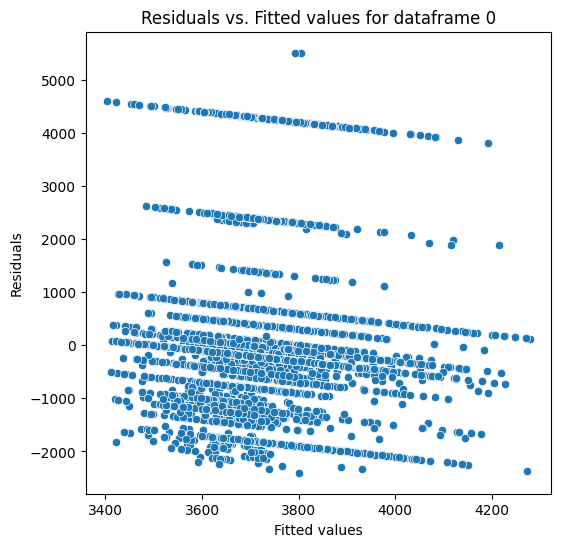

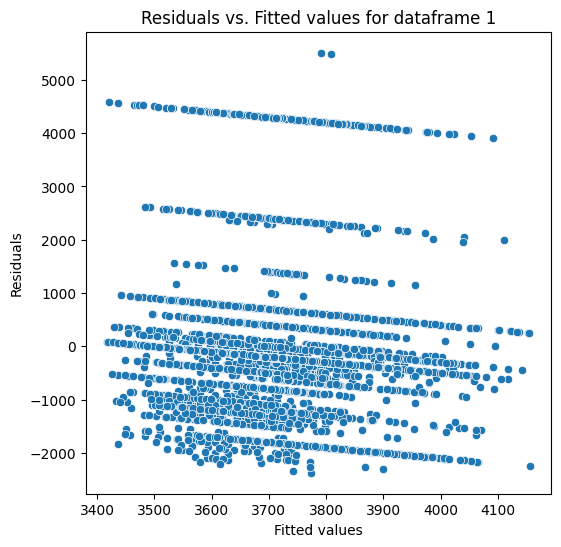

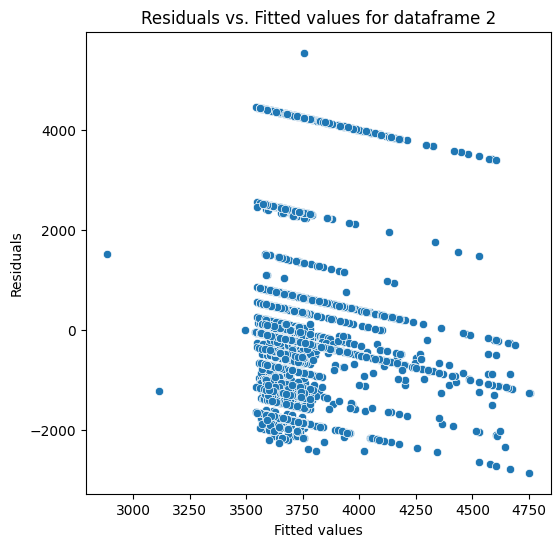

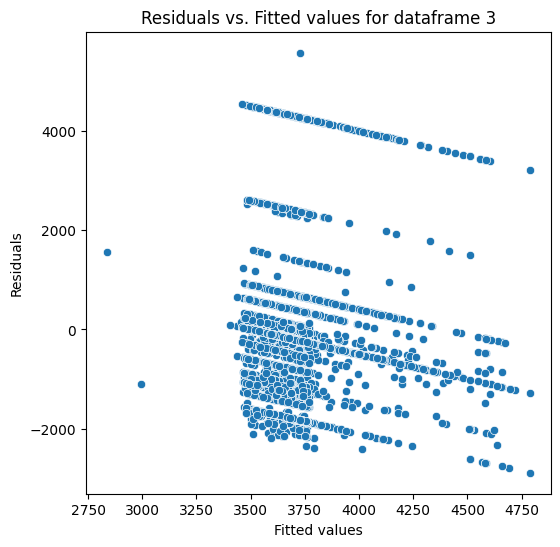

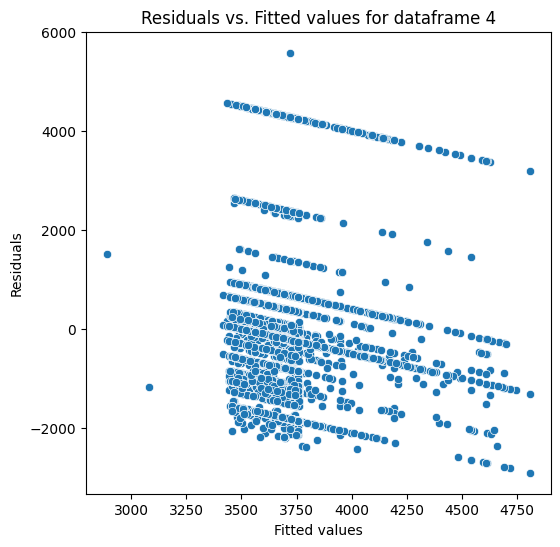

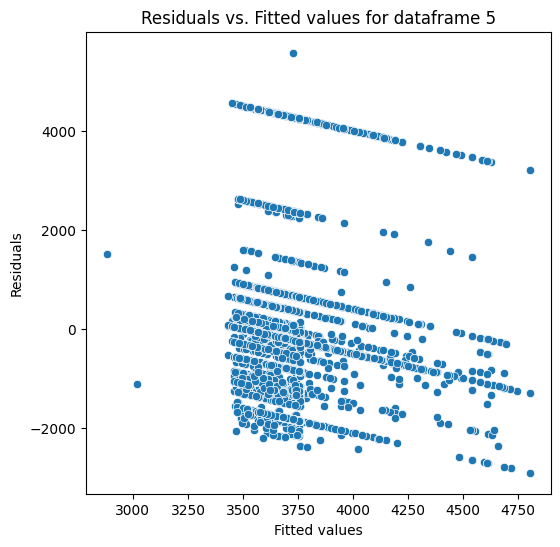

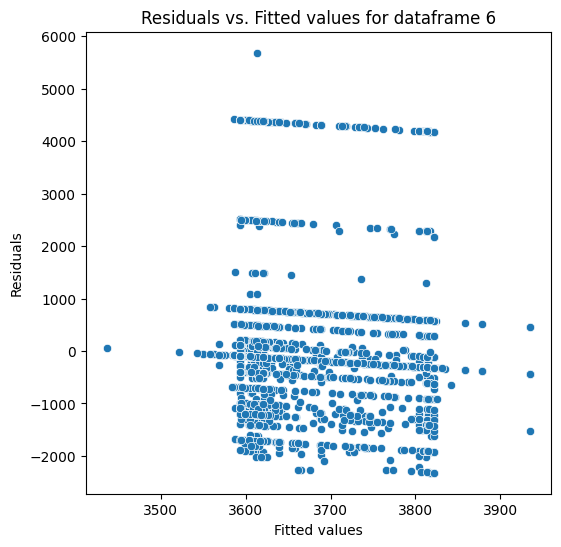

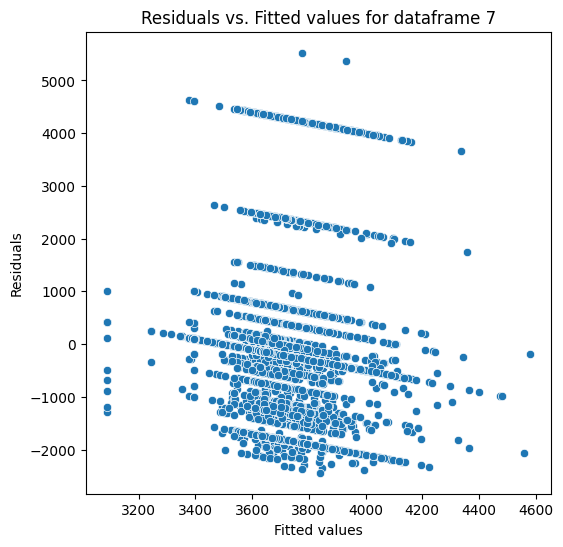

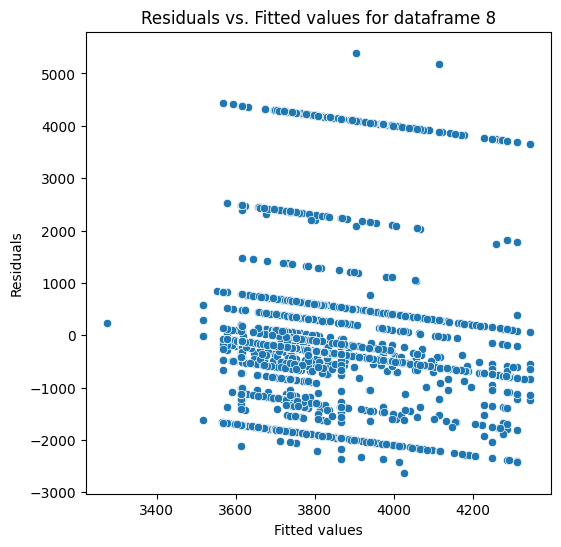

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

outcome = 'Salaire_moyen_en_EQTP'
predictors = ['0', '1', '2']

# Loop over all dataframes
for i, df in enumerate(dfs):
    # Define dependent and independent variables
    X = df[predictors]
    X = sm.add_constant(X)  # Adding the intercept term
    y = df[outcome]

    # Fit the model
    model = sm.OLS(y, X)
    results = model.fit()

    # Calculate predictions and residuals
    predictions = results.predict(X)
    residuals = y - predictions

    # Create the plot
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=predictions, y=residuals)
    plt.xlabel('Fitted values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs. Fitted values for dataframe {i}')
    plt.show()

The White test

In [122]:
#Importing Libraries
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white
from statsmodels.compat import lzip



# The outcome variable
y = 'Salaire_moyen_en_EQTP'

# The predictor variables
x = ['0', '1', '2']

# Loop over dataframes in dfs
for i, df in enumerate(dfs):
    # Fit the model
    model = sm.OLS(df[y], sm.add_constant(df[x])).fit()

    # Perform White's test
    white_test = het_white(model.resid, model.model.exog)

    # Print the results
    print(f"White's test results for dataframe {i+1}:")
    print(lzip(['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'], white_test))
    print()

White's test results for dataframe 1:
[('Lagrange multiplier statistic', 142.9356216736284), ('p-value', 2.553609841079466e-26), ('f-value', 16.064764491489953), ('f p-value', 1.7434778558574117e-26)]

White's test results for dataframe 2:
[('Lagrange multiplier statistic', 169.33524315303688), ('p-value', 8.487802103583439e-32), ('f-value', 19.07554007226158), ('f p-value', 4.901443820100754e-32)]

White's test results for dataframe 3:
[('Lagrange multiplier statistic', 86.53705872570015), ('p-value', 8.042584577684568e-15), ('f-value', 9.682921690859564), ('f p-value', 7.030667185721706e-15)]

White's test results for dataframe 4:
[('Lagrange multiplier statistic', 98.69427810324798), ('p-value', 2.889623766193296e-17), ('f-value', 11.057941323280629), ('f p-value', 2.400593494573087e-17)]

White's test results for dataframe 5:
[('Lagrange multiplier statistic', 107.08604618463896), ('p-value', 5.756433823896669e-19), ('f-value', 12.008320498559304), ('f p-value', 4.603397995825392e-

The White Test has the null hypothesis that the errors are have same variance or homoscedastic. Having a p-value ≤ 0.05 would indicate that the null hypothesis is rejected, hence Heteroscedasticity

Here, only model 7 meets the assumption with p being greater than .05.


Solutions to lack of homoscedasticity:

- Outlier removal
- Log transformation of x variables
- Polynomial regresion


Alternatively - drop OLS and instead use:
- Weighted Least Squares (WLS) 
- Generalized Least Squares (GLS) 

### 3) Errors are normally distributed (Violated)

<Figure size 800x600 with 0 Axes>

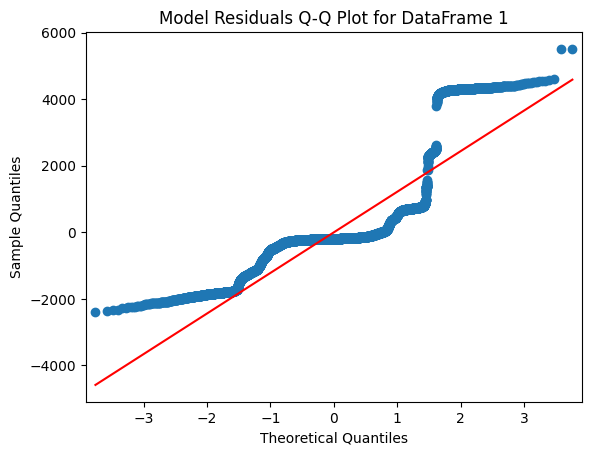

<Figure size 800x600 with 0 Axes>

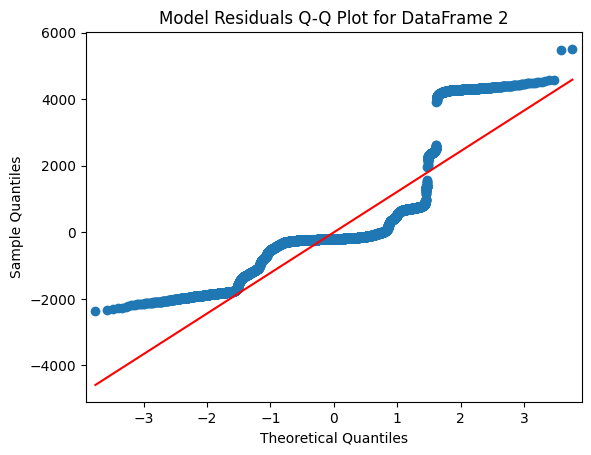

<Figure size 800x600 with 0 Axes>

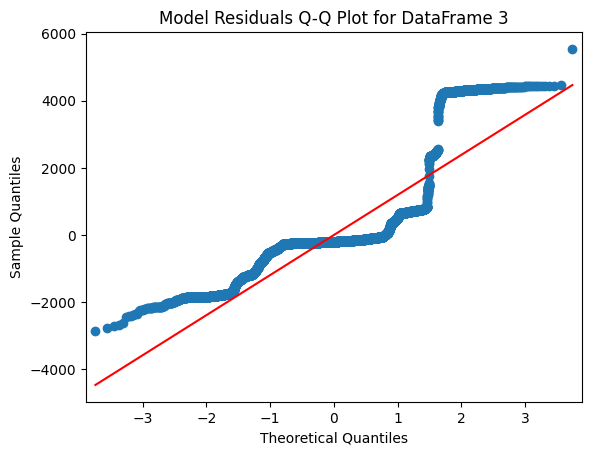

<Figure size 800x600 with 0 Axes>

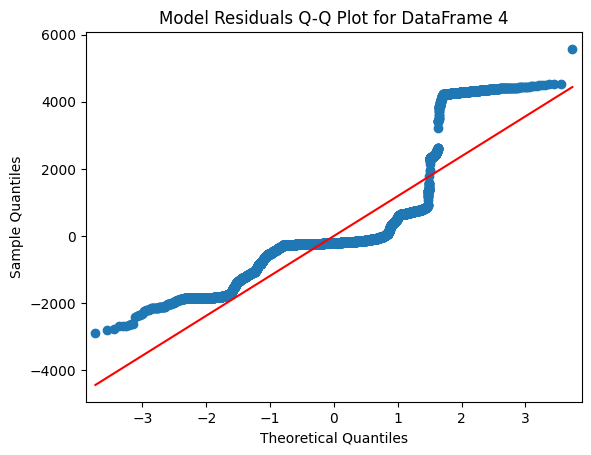

<Figure size 800x600 with 0 Axes>

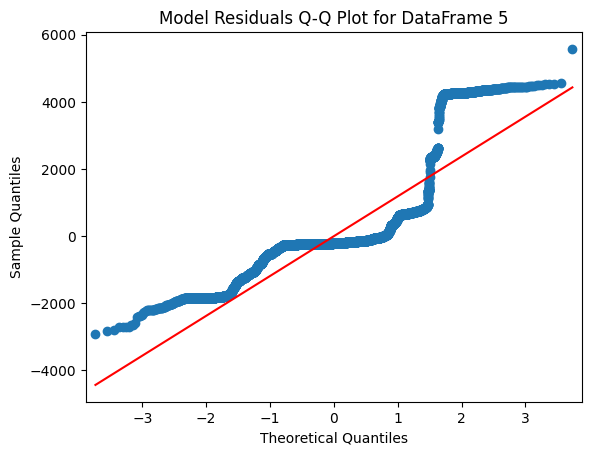

<Figure size 800x600 with 0 Axes>

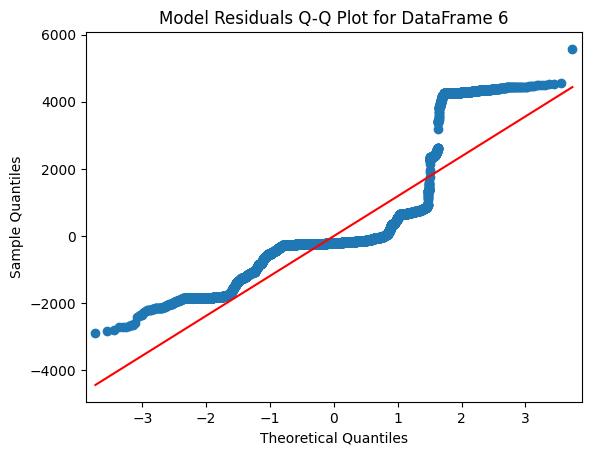

<Figure size 800x600 with 0 Axes>

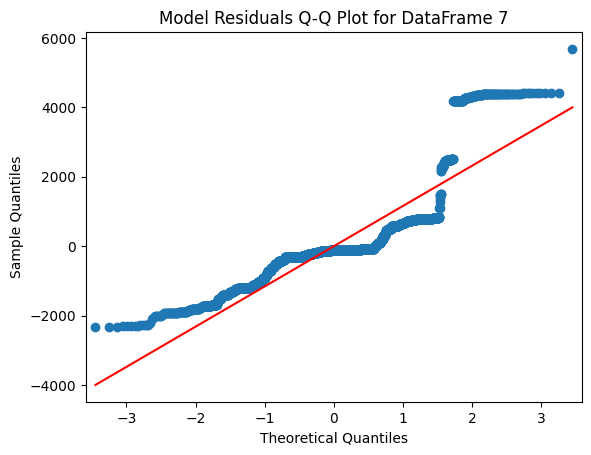

<Figure size 800x600 with 0 Axes>

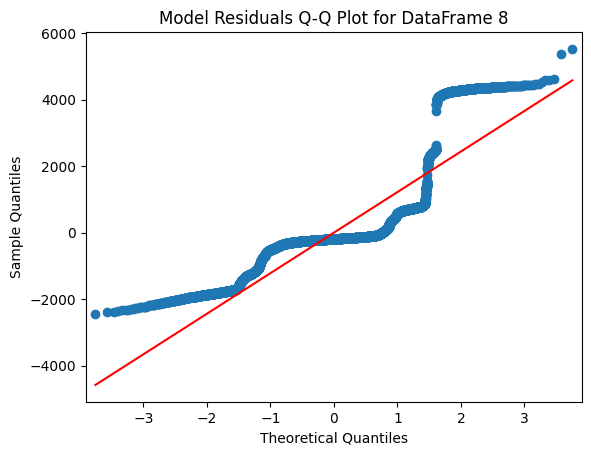

<Figure size 800x600 with 0 Axes>

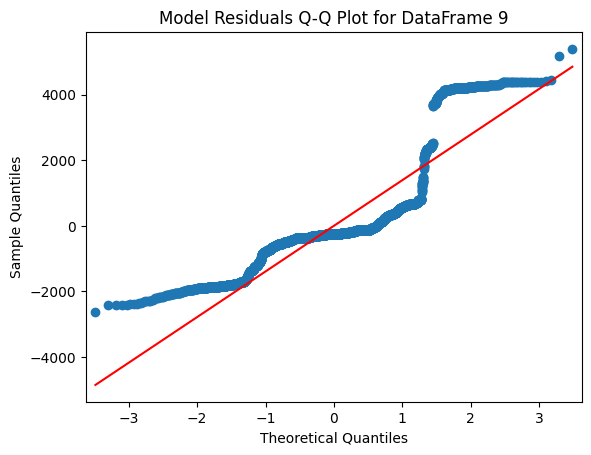

In [142]:
#Import library
from scipy import stats


outcome = 'Salaire_moyen_en_EQTP'
predictors = ['0', '1', '2']


for i, df in enumerate(dfs):
    # Fit a linear regression model
    X = sm.add_constant(df[predictors])  # Adding the intercept term
    y = df[outcome]
    model = sm.OLS(y, X)
    results = model.fit()

    # Create QQ plot
    plt.figure(figsize=(8, 6))  # Adjust the figure size
    sm.qqplot(results.resid, line='s')
    plt.title(f'Model Residuals Q-Q Plot for DataFrame {i+1}')
    plt.show()

### 4) Independent observations - no autocorrelatiions ***

Yes, because:
Being a factor analysis method spatialisation assures non linear dependence between spatialisation along CA dimensions. At least for the first N. That’s another why I think taking N=3 is a good bet.

### 5) No multicolinearity - Predictors are not correlated with each other ***

Below: Across all models, the predictors are not highly correlated.

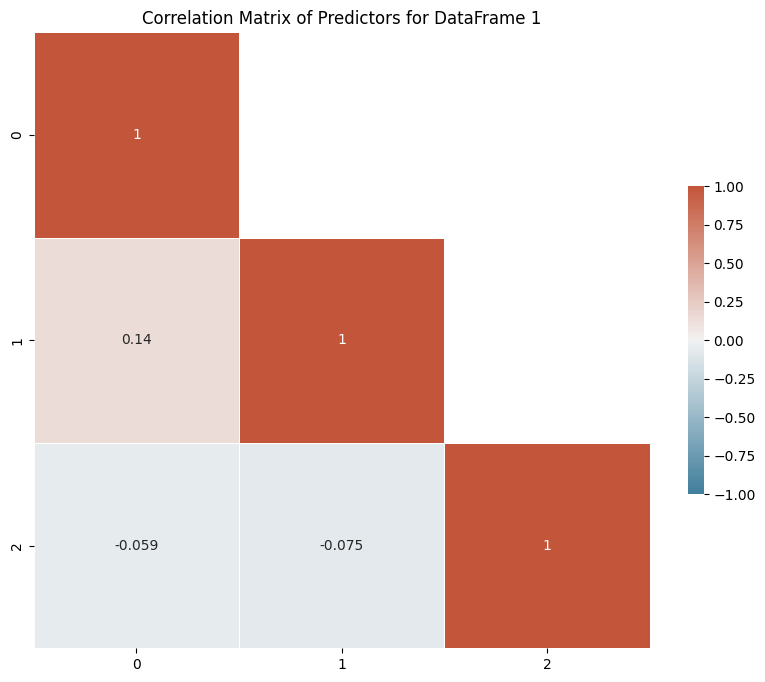

   VIF Factor features
0    1.051850        0
1    1.051903        1
2    1.000238        2
Model 1 does not have high multicollinearity


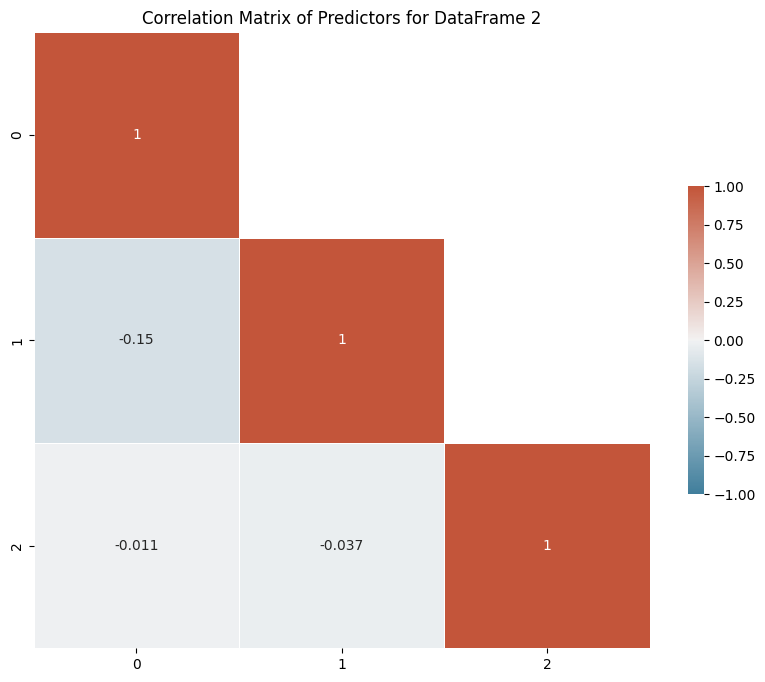

   VIF Factor features
0    1.077681        0
1    1.067753        1
2    1.032557        2
Model 2 does not have high multicollinearity


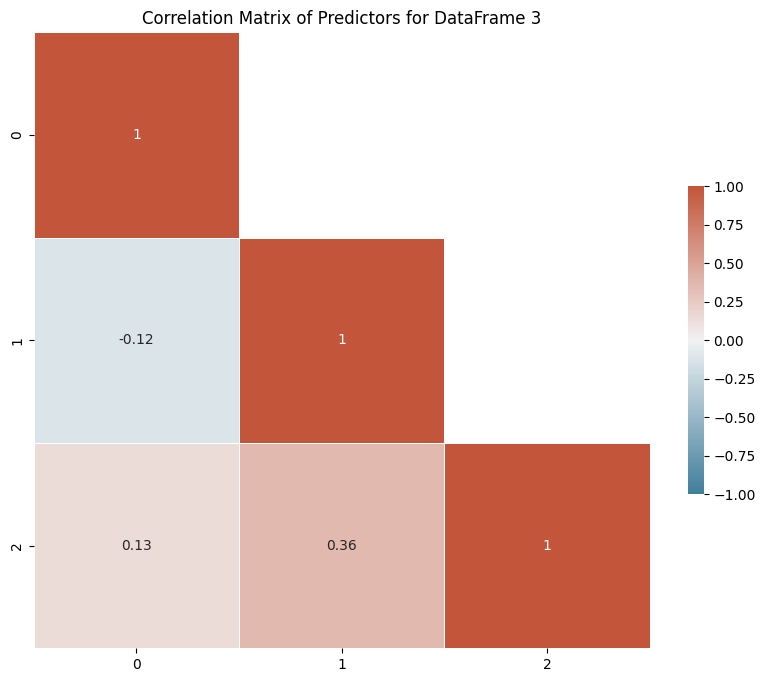

   VIF Factor features
0    1.156443        0
1    1.213515        1
2    1.198152        2
Model 3 does not have high multicollinearity


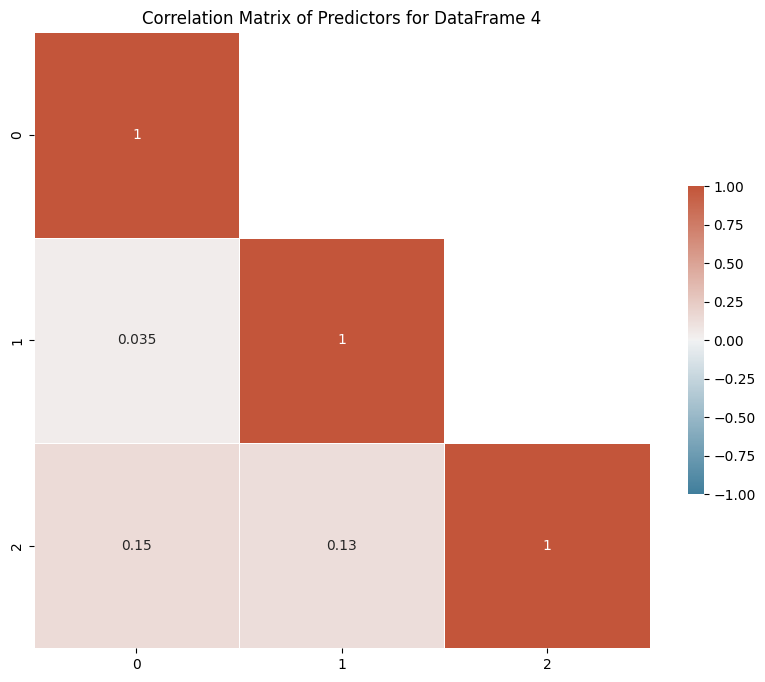

   VIF Factor features
0    1.158977        0
1    1.008447        1
2    1.162653        2
Model 4 does not have high multicollinearity


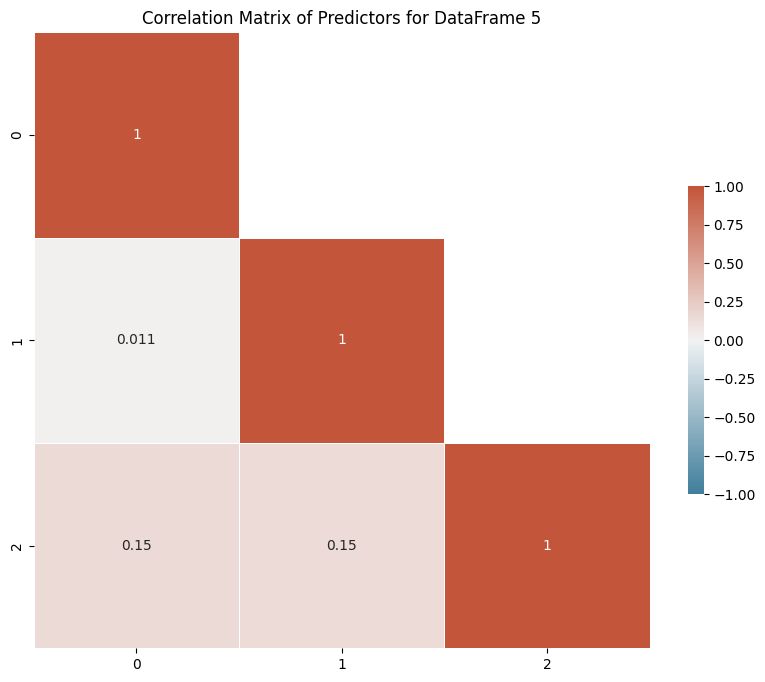

   VIF Factor features
0    1.186866        0
1    1.015264        1
2    1.182868        2
Model 5 does not have high multicollinearity


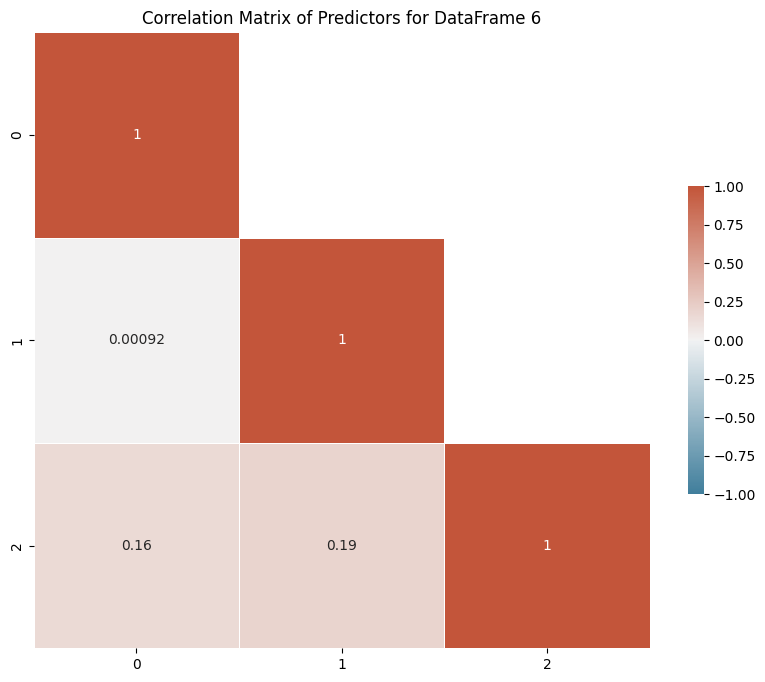

   VIF Factor features
0    1.197252        0
1    1.030261        1
2    1.189551        2
Model 6 does not have high multicollinearity


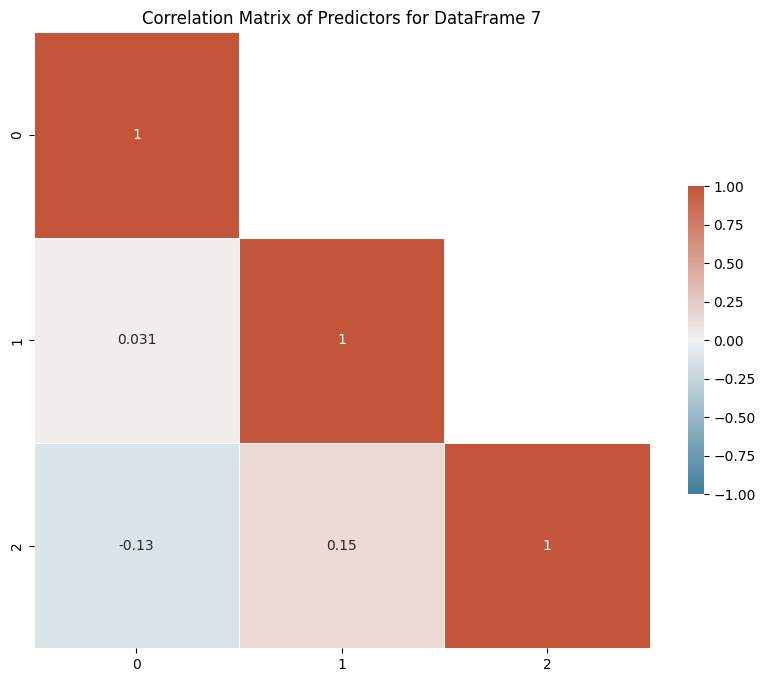

   VIF Factor features
0    1.013245        0
1    1.026275        1
2    1.036007        2
Model 7 does not have high multicollinearity


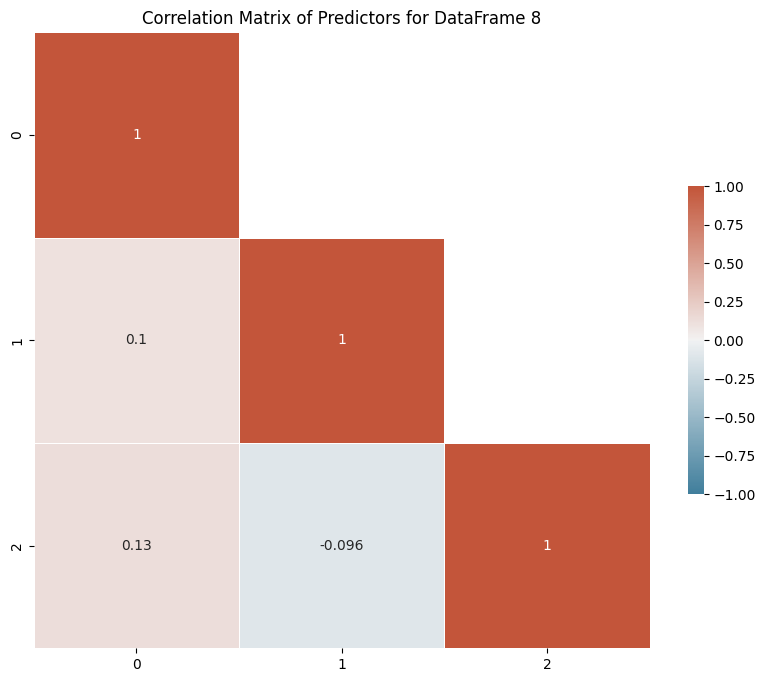

   VIF Factor features
0    1.039742        0
1    1.023754        1
2    1.046311        2
Model 8 does not have high multicollinearity


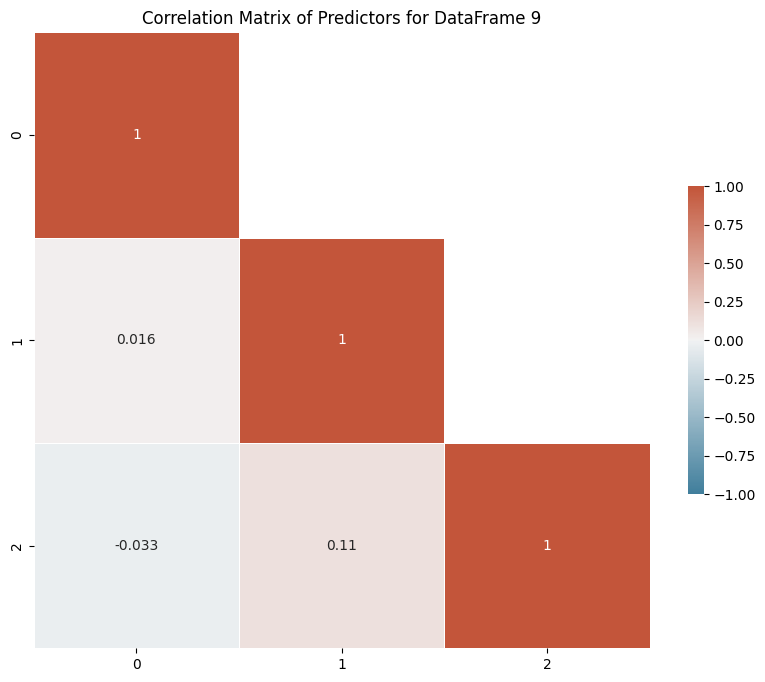

   VIF Factor features
0    1.001291        0
1    1.013552        1
2    1.014629        2
Model 9 does not have high multicollinearity


In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

outcome = 'Salaire_moyen_en_EQTP'
predictors = ['0', '1', '2']

# Loop over dataframes in dfs
for i, df in enumerate(dfs):
    # Calculate the correlation matrix
    corr_matrix = df[predictors].corr()

    # Create a mask to only show the lower triangle of the matrix (since it's mirrored around its 
    # top-left to bottom-right diagonal)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)  # k=1 keeps the main diagonal unmasked

    # Create a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmin=-1, vmax=1,  # Set color range from -1 to 1
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

    plt.title(f'Correlation Matrix of Predictors for DataFrame {i+1}')
    plt.show()

    # Calculate VIF for each predictor
    X = df[predictors]
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, j) for j in range(X.shape[1])]
    vif["features"] = X.columns

    print(vif)

    # Check if there's high multicollinearity
    if vif["VIF Factor"].max() > 5:
        print(f'Model {i+1} might have high multicollinearity')
    else:
        print(f'Model {i+1} does not have high multicollinearity')

Here, I am just checking correlations between aggregated coordinate values per job title, and the income. Also checking the correlation between occupational class and income.

### 7) Independence of residuals *** no significant autocorrelation

In [6]:
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm

outcome = 'Salaire_moyen_en_EQTP'
predictors = ['0', '1', '2']

for i, df in enumerate(dfs):
    # Fit a linear regression model
    X = sm.add_constant(df[predictors])  # Adding the intercept term
    y = df[outcome]
    model = sm.OLS(y, X)
    results = model.fit()

    # Calculate residuals
    residuals = y - results.predict(X)

    # Apply Durbin-Watson test
    dw = durbin_watson(residuals)

    print(f'Durbin-Watson statistic for dataframe {i}: {dw}')

Durbin-Watson statistic for dataframe 0: 1.9903018029976685
Durbin-Watson statistic for dataframe 1: 1.9898706651528912
Durbin-Watson statistic for dataframe 2: 1.9922987206689473
Durbin-Watson statistic for dataframe 3: 1.9957051436355844
Durbin-Watson statistic for dataframe 4: 1.9939558264687494
Durbin-Watson statistic for dataframe 5: 1.994691965525289
Durbin-Watson statistic for dataframe 6: 2.015929925478694
Durbin-Watson statistic for dataframe 7: 1.9895332703747142
Durbin-Watson statistic for dataframe 8: 2.0508776094400596


In [ ]:
from statsmodels.stats.stattools import durbin_watson
dw = durbin_watson(residuals)
print(f'Durbin-Watson statistic: {dw}')

### Assumptions Weighted Least Squares Regression
Weighted least squares (WLS), also known as weighted linear regression,[1][2] is a generalization of ordinary least squares and linear regression in which knowledge of the unequal variance of observations (heteroscedasticity) is incorporated into the regression. 

In a weighted fit, less weight is given to the
less precise measurements and more weight
to more precise measurements when
estimating the unknown parameters in the
model.
Using weights that are inversely proportional
to the variance at each level of the explanatory
variables yields the most precise parameter
estimates possible.

In [40]:
# Loop over all dataframes
for i, df in enumerate(dfs):
    # Calculate the mean values for each group
    grouped_means = df.groupby('PCS_ESE')[predictors + [outcome]].mean()
    
    # Calculate the correlation matrix
    correlation_matrix = grouped_means.corr()
    
    # Print the correlation matrix for each dataframe
    print(f"Correlation matrix for dataframe {i}:")
    print(correlation_matrix)
    print("\n")

Correlation matrix for dataframe 0:
                              0         1         2  Salaire_moyen_en_EQTP
0                      1.000000 -0.164887  0.376979              -0.350158
1                     -0.164887  1.000000 -0.208947               0.276866
2                      0.376979 -0.208947  1.000000              -0.188425
Salaire_moyen_en_EQTP -0.350158  0.276866 -0.188425               1.000000


Correlation matrix for dataframe 1:
                              0         1         2  Salaire_moyen_en_EQTP
0                      1.000000  0.216007 -0.448156               0.357874
1                      0.216007  1.000000 -0.282602               0.296153
2                     -0.448156 -0.282602  1.000000              -0.144116
Salaire_moyen_en_EQTP  0.357874  0.296153 -0.144116               1.000000


Correlation matrix for dataframe 2:
                              0         1         2  Salaire_moyen_en_EQTP
0                      1.000000 -0.345016  0.441525            

## 3 Model Comparison

Here, I am fitting multidimensional OLS to do model selection. 
The model that gives the best fit will be selected for durther inspection. 

In [38]:
# Loading CA job coord files
importlib.reload(utils2)

# Load the coordinate files for models 1 to 9
dfs = utils2.load_CA_model_files(9)

for i, df in enumerate(dfs):
    print(f"Shape of dataframe {i+1}: {df.shape}")

Used file path: /home/livtollanes/NewData/job_title_coordinates/m1_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m2_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m3_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m4_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m5_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m6_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m7_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m8_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m9_jobs_rowcoords.csv
Shape of dataframe 1: (11678, 14)
Shape of dataframe 2: (11677, 14)
Shape of dataframe 3: (10958, 14)
Shape of dataframe 4: (10681, 14)
Shape of dataframe 5: (10621, 14)
Shape of dataframe 6: (10626, 14)
Shape of dataframe 7: 

Below, I am performing a k-fold cross validation on a set of dfs using OLS and WLS regression. 
I identify the model with the lowes Root Mean Squared error. 


In [279]:
import importlib
import model_comparison

importlib.reload(model_comparison)
from model_comparison import CrossValidation

In [287]:

outcome = 'Salaire_moyen_en_EQTP'
predictors = ['0']


# Initialize GroupKFold
gkf = GroupKFold(n_splits=10)

# Create an instance of the class with required arguments
model_comp1 = CrossValidation(df_list_15, predictors, outcome)


# Call the fit method
model_comp1.fit()
model_comp1.calculate_correlations('PCS_ESE')

     DataFrame  Mean RMSE (CV)   R2 (CV)  R2 (Full)
0  DataFrame 1     1407.337894  0.833995   0.998894
1  DataFrame 2     1417.217647  0.863632   0.999922
2  DataFrame 3     1386.781262  0.779322   0.894016
3  DataFrame 4     1401.290505  0.805519   0.987053
4  DataFrame 5     1408.229529  0.849075   0.991828
5  DataFrame 6     1404.676479  0.781445   0.997061
6  DataFrame 7     1300.615490  0.470292   0.350599
7  DataFrame 8     1379.041501  0.286679   0.000458
8  DataFrame 9     1375.797498  0.037737   0.000329

Number of folds used in the group fold cross-validation: 10
     DataFrame Predictor  Correlation
0  DataFrame 1         0    -0.263672
1  DataFrame 2         0     0.279014
2  DataFrame 3         0     0.303124
3  DataFrame 4         0     0.295891
4  DataFrame 5         0     0.294247
5  DataFrame 6         0     0.281535
6  DataFrame 7         0     0.159233
7  DataFrame 8         0    -0.082301
8  DataFrame 9         0    -0.171337


/home/livtollanes/10.jan-thesis/Code/Validation/../Utility files/model_comparison.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Predicted'] = results_wls.predict(X)


In [290]:

outcome = 'Salaire_moyen_en_EQTP'
predictors = ['0', '1', '2']


# Initialize GroupKFold
gkf = GroupKFold(n_splits=10)

# Create an instance of the class with required arguments
model_comp3 = CrossValidation(dfs, predictors, outcome)


# Call the fit method
model_comp3.fit()
model_comp3.calculate_correlations('PCS_ESE')

     DataFrame  Mean RMSE (CV)   R2 (CV)  R2 (Full)
0  DataFrame 1     1438.970726  0.877553   0.997989
1  DataFrame 2     1451.391885  0.880866   0.993184
2  DataFrame 3     1409.298829  0.710566   0.866417
3  DataFrame 4     1433.001837  0.898672   0.986411
4  DataFrame 5     1425.372351  0.878926   0.918758
5  DataFrame 6     1426.434008  0.918591   0.957900
6  DataFrame 7     1316.693404  0.468981   0.278562
7  DataFrame 8     1420.011838  0.933102   0.975443
8  DataFrame 9     1435.581480  0.853042   0.782817

Number of folds used in the group fold cross-validation: 10
     DataFrame Predictor  Correlation
0  DataFrame 1         0    -0.356894
1  DataFrame 2         0     0.365378
2  DataFrame 3         0     0.207424
3  DataFrame 4         0     0.285323
4  DataFrame 5         0     0.261615
5  DataFrame 6         0     0.273760
6  DataFrame 7         2     0.189502
7  DataFrame 8         0    -0.251454
8  DataFrame 9         1     0.219192


In [69]:
model_comp.calculate_correlations(grouping_column='PCS_ESE')

     DataFrame Predictor  Correlation
0  DataFrame 1         0    -0.356894
1  DataFrame 2         0     0.365378
2  DataFrame 3         0     0.207424
3  DataFrame 4         0     0.285323
4  DataFrame 5         0     0.261615
5  DataFrame 6         0     0.273760
6  DataFrame 7         2     0.189502
7  DataFrame 8         0    -0.251454
8  DataFrame 9         1     0.219192


In [282]:
model_comp1.calculate_correlations(grouping_column='PCS_ESE')

     DataFrame Predictor  Correlation
0  DataFrame 1         0    -0.356894
1  DataFrame 2         0     0.365378
2  DataFrame 3         0     0.207424
3  DataFrame 4         0     0.285323
4  DataFrame 5         0     0.261615
5  DataFrame 6         0     0.273760
6  DataFrame 7         0     0.010723
7  DataFrame 8         0    -0.251454
8  DataFrame 9         0    -0.135013


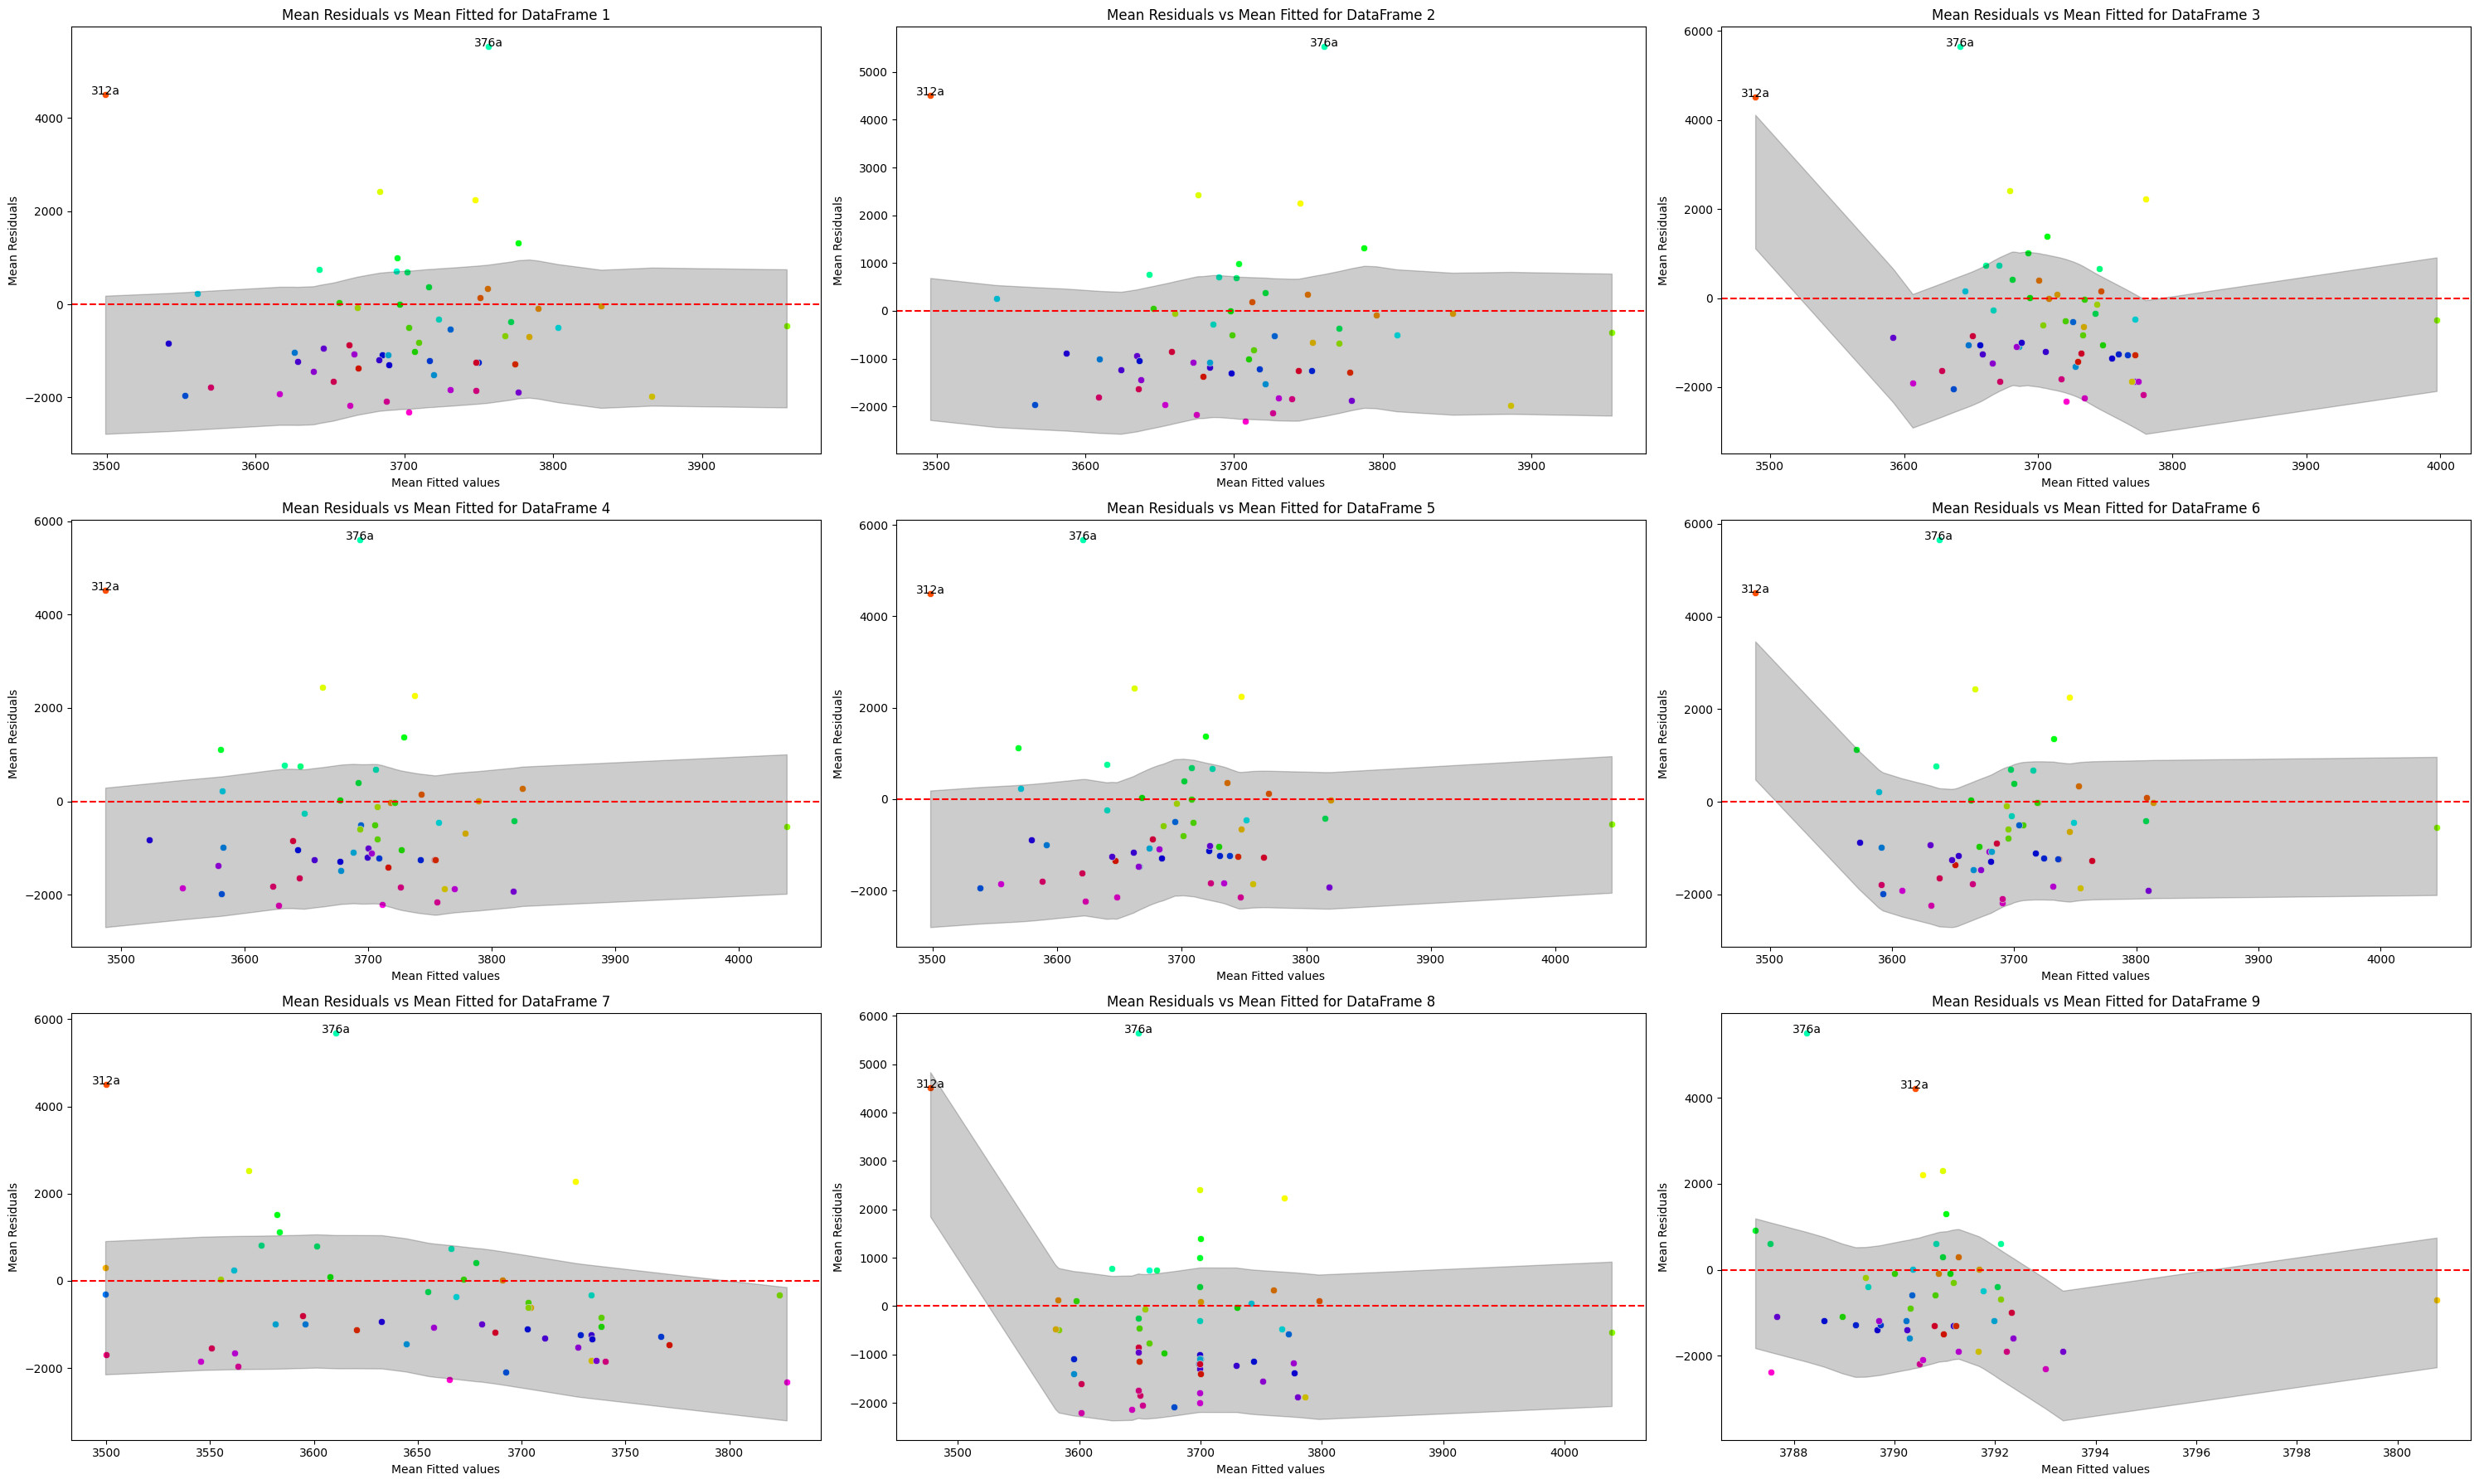

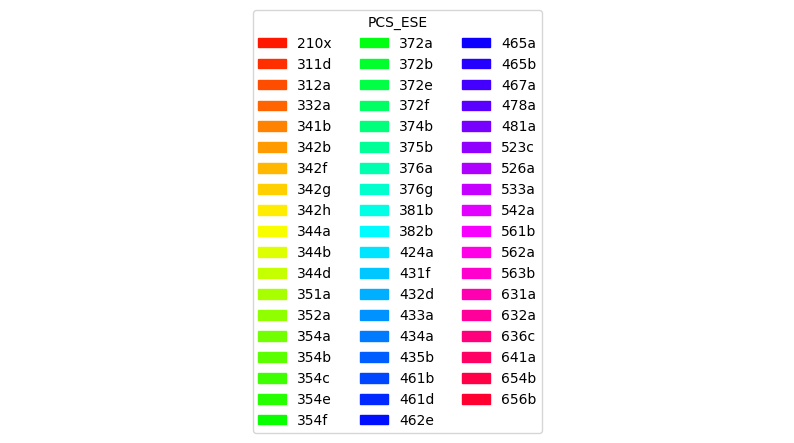

In [283]:
from statsmodels.nonparametric.smoothers_lowess import lowess

model_comp1.plot_grouped_residuals_vs_fitted()

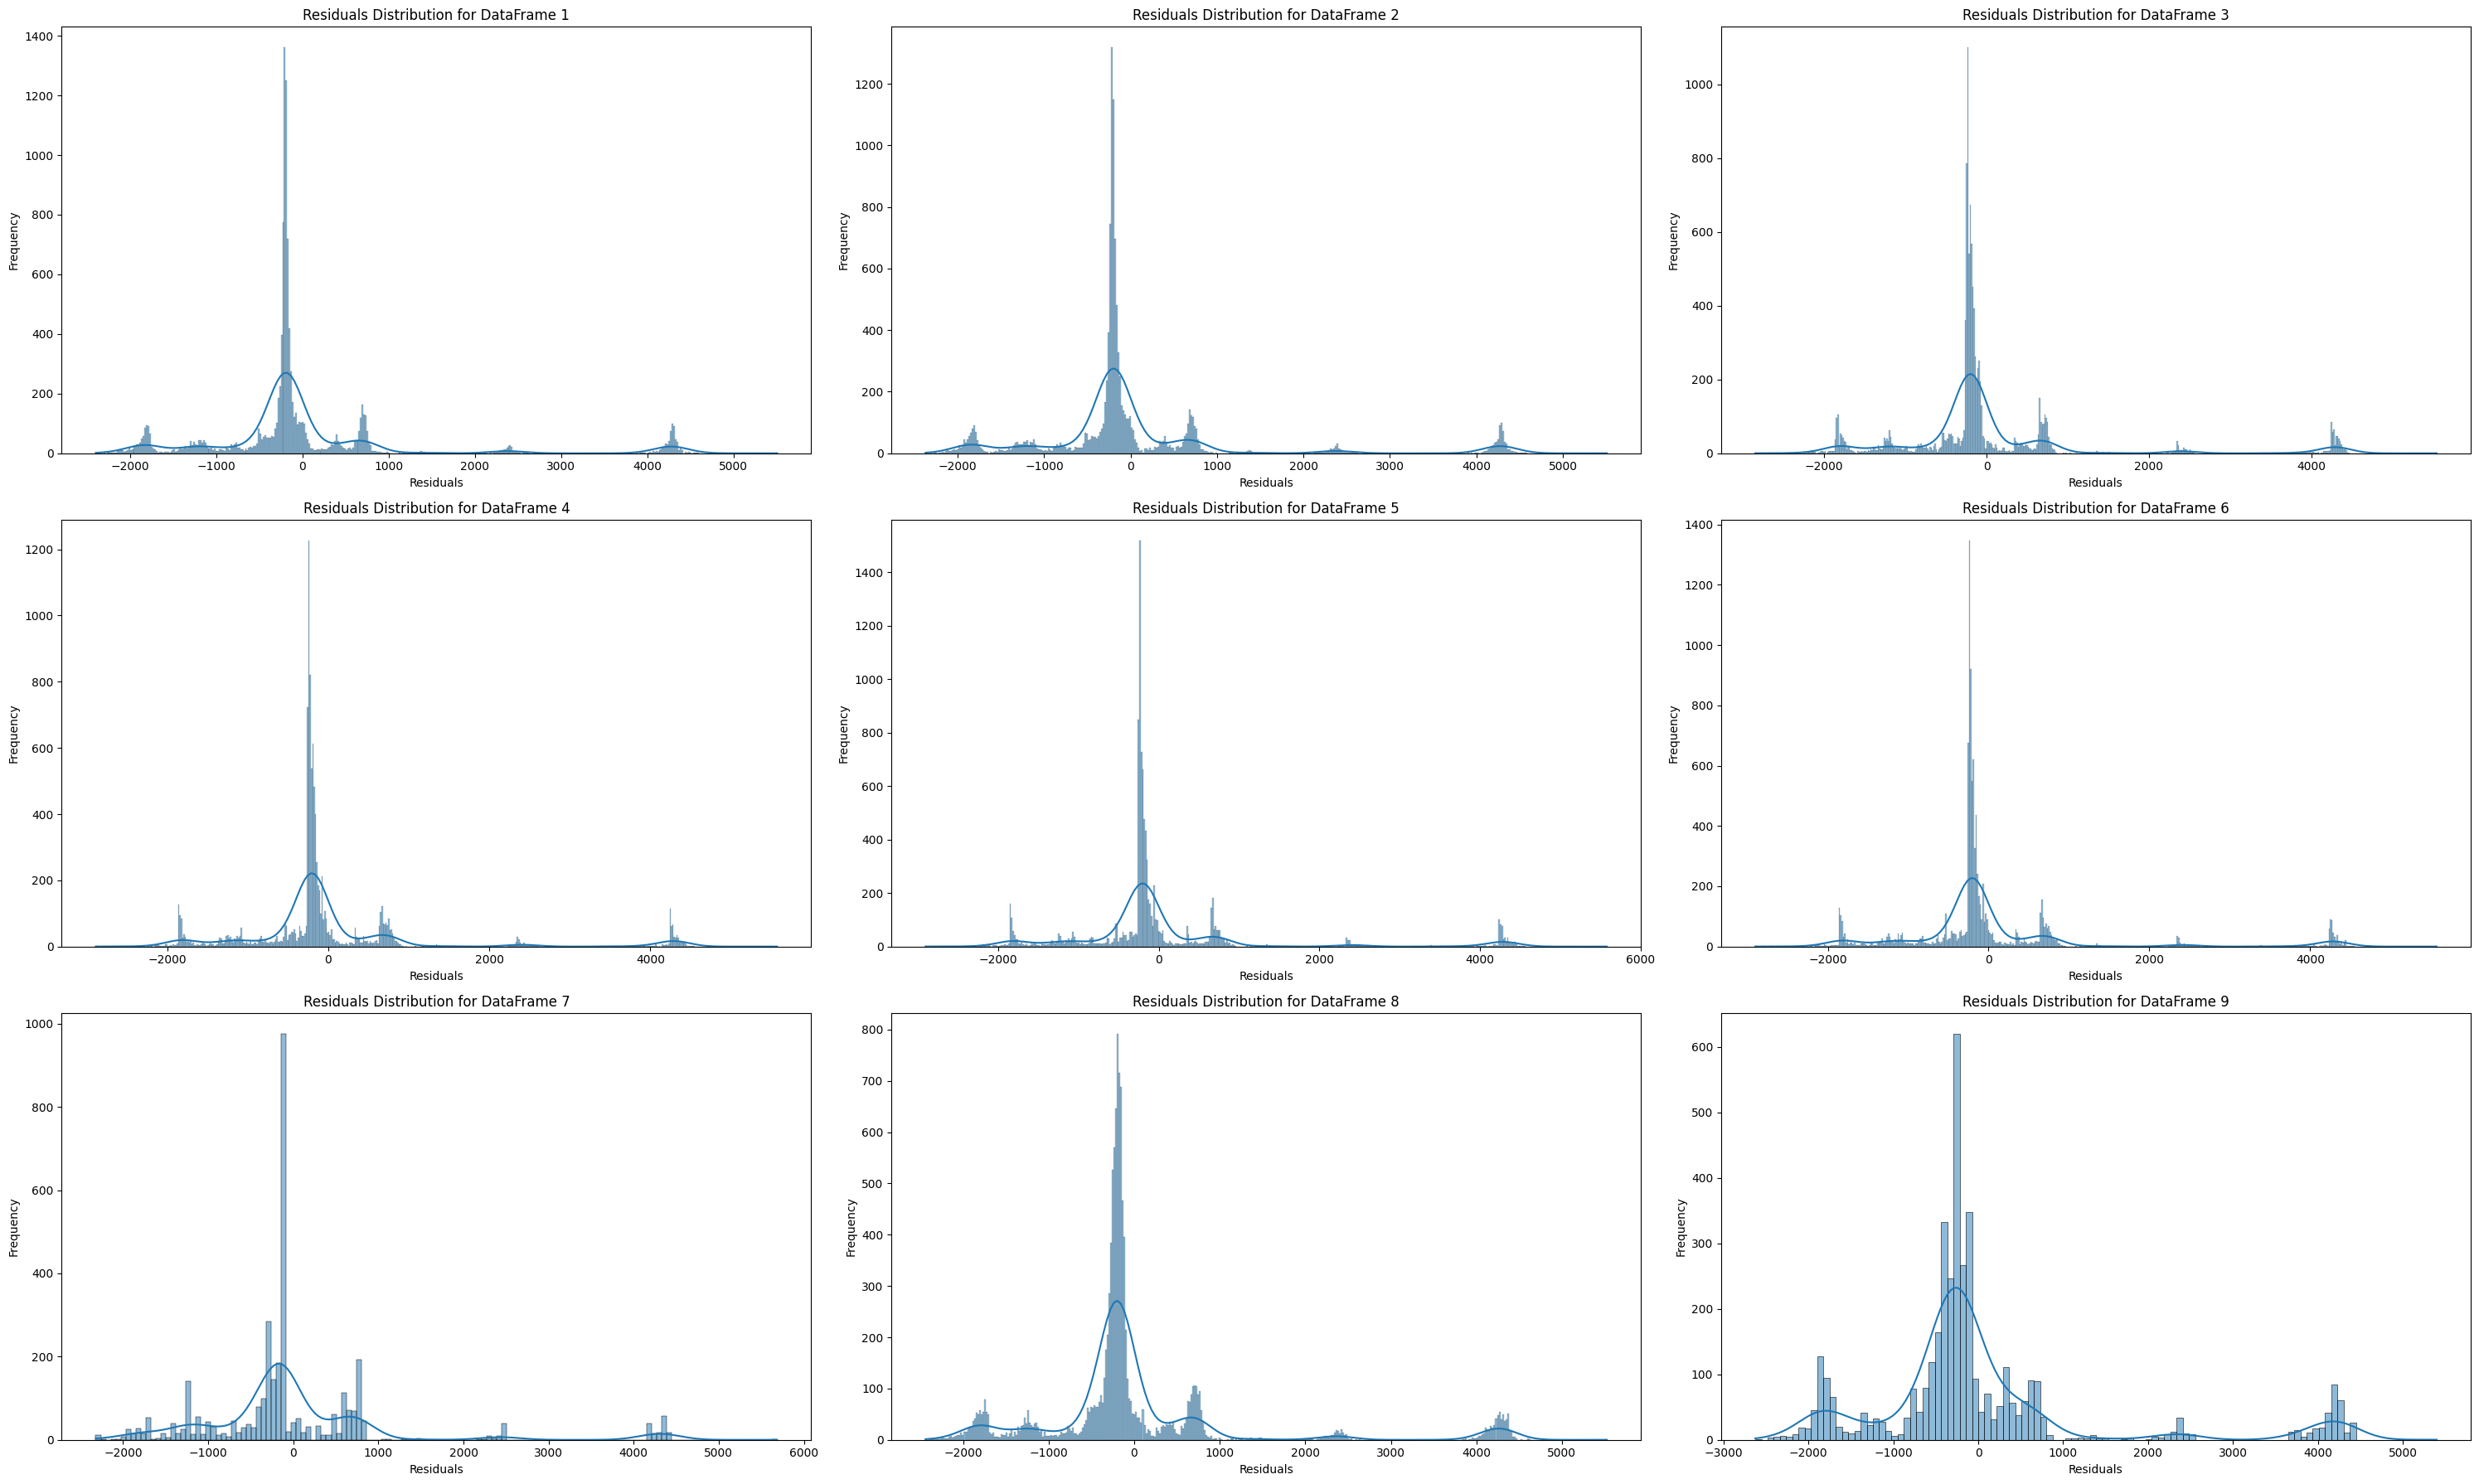

In [46]:
model_comp.plot_residuals()

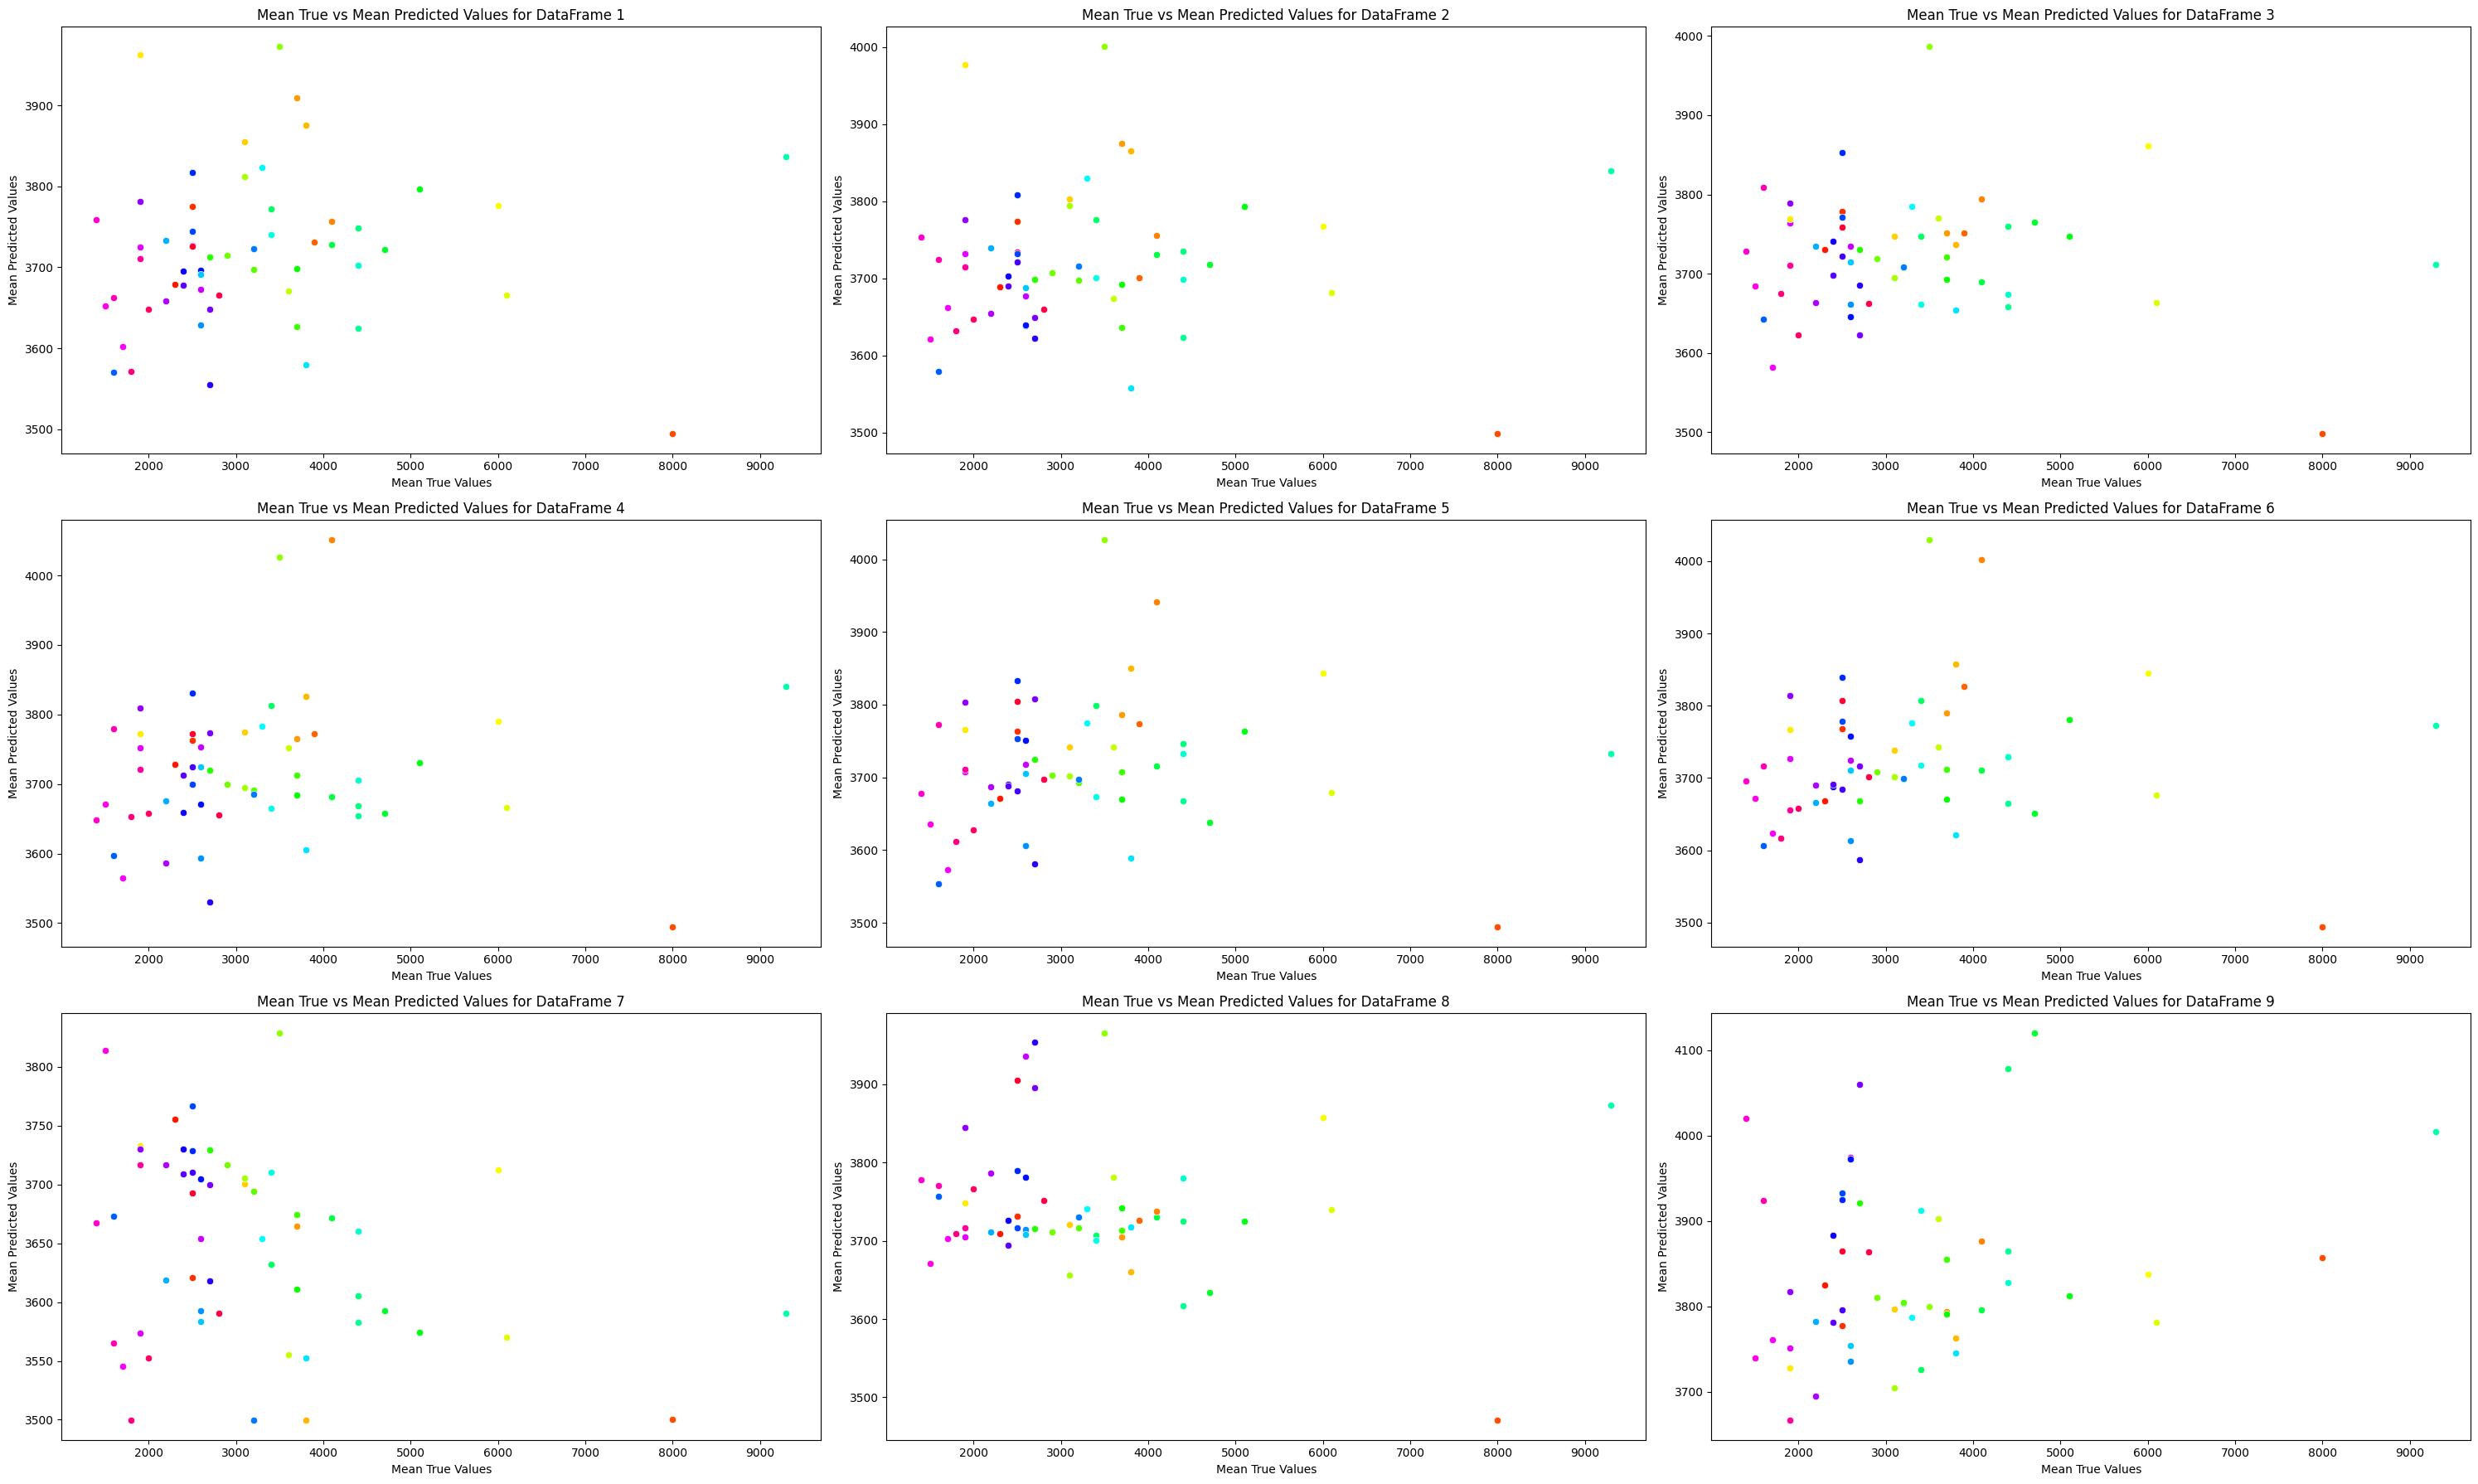

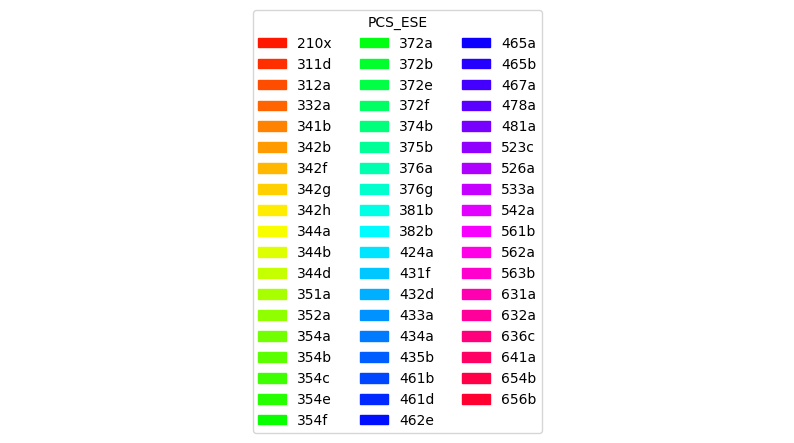

In [161]:
model_comp.plot_mean_true_vs_predicted()

In [ ]:
model_comp.plot_residuals_by_group()

In [71]:
unique_titles = dfs[6]['title'].unique()
print(unique_titles)

['pâtissier' 'développeur' 'médecin' 'rédacteur chef' 'journaliste'
 'designer graphique' 'responsable relations' 'infirmier'
 'responsable communication' 'animateur radio' 'artiste' 'pompier'
 'directeur communication' 'chroniqueur' 'ingénieur agriculture'
 'directrice communication' 'avocat' 'musicien' 'chargée communication'
 'comptable' 'juriste' 'coach sportif' 'responsable marketing' 'graphiste'
 'agrégé' 'doctorant' 'conseiller commercial'
 'auteur compositeur interprète' 'ostéopathe' 'psychologue'
 'directeur artistique' 'artisan' 'conseiller clientèle' 'boulanger'
 'marine' 'rappeur' 'maître conférences' 'compositeur'
 'conducteur train métro' 'comédien' 'pharmacien' 'illustrateur'
 'chanteur' 'chef projet communication' 'rédacteur web' 'adjoint maire'
 'reporter' 'rédacteur chef adjoint' 'assistant direction' 'chercheur'
 'danseur' 'ouvrier' 'cheffe bureau' 'responsable réseaux sociaux'
 'coiffeur' 'aide soignant' 'architecte' 'bibliothécaire' 'documentaliste'
 'agent commerc

In [106]:
unique_PCS_ESE_names = dfs[6]['PCS_ESE_name'].unique()
print(unique_PCS_ESE_names)

['Boulangers, pâtissiers (sauf activité industrielle)'
 "Techniciens d'étude et de développement  en informatique"
 'Médecins salariés non hospitaliers'
 'Journalistes (y c. rédacteurs en chef)'
 'Concepteurs et assistants techniques des  arts graphiques, de la mode et de la décoration'
 'Cadres des relations publiques et de  la communication'
 'Infirmiers en soins généraux, salariés'
 'Artistes du cirque et des spectacles divers' 'Artistes plasticiens'
 'Pompiers' 'Cadres des relations publiques et de la communication'
 "Ingénieurs et cadres d'étude et développement de l'agriculture,  la pêche, les eaux et forêts"
 'Avocats' 'Artistes de la musique et du chant'
 'Maîtrise et techniciens des services financiers ou comptables'
 'Juristes' 'Moniteurs et éducateurs sportifs, sportifs professionnels'
 'Chefs de produits, acheteurs du commerce et autres cadres de  la mercatique'
 'Professeurs et maîtres de conférences'
 'Allocataires de la recherche publique' 'Chargés de clientèle bancaire'

## 4) Results: Interpretation and Overview

In [7]:
importlib.reload(utils2)

<module 'utils2' from '/home/livtollanes/10.jan-thesis/Code/Validation/../Utility files/utils2.py'>

### General Overview

In [18]:
#Load all user coordinates
user_coords = utils2.load_all_row_coords_files(9)

Used file path: /home/livtollanes/NewData/coordinates/m1_coords/m1_row_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m2_coords/m2_row_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m3_coords/m3_row_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m4_coords/m4_row_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m5_coords/m5_row_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m6_coords/m6_row_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m7_coords/m7_row_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m8_coords/m8_row_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m9_coords/m9_row_coordinates.csv


In [27]:
# Load the coordinate files for models 1 to 9
job_coords = utils2.load_CA_model_files(9)


Used file path: /home/livtollanes/NewData/job_title_coordinates/m1_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m2_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m3_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m4_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m5_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m6_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m7_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m8_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m9_jobs_rowcoords.csv


In [11]:
#Load the marker coords
marker_coords = utils2.load_all_column_coords_files(9)

Used file path: /home/livtollanes/NewData/coordinates/m1_coords/m1_column_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m2_coords/m2_column_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m3_coords/m3_column_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m4_coords/m4_column_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m5_coords/m5_column_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m6_coords/m6_column_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m7_coords/m7_column_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m8_coords/m8_column_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m9_coords/m9_column_coordinates.csv


In [64]:
for i in range(2):
    min_val_user = user_coords[i]['0'].min()
    max_val_user = user_coords[i]['0'].max()
    min_val_marker = marker_coords[i]['0'].min()
    max_val_marker = marker_coords[i]['0'].max()

    print(f"For Df{i+1}:")
    print(f"Coordinate ranges in dim0 for Users: {min_val_user}, {max_val_user}")
    print(f"Coordinate ranges in dim0 for Markers: {min_val_marker}, {max_val_marker}")
    print("\n")

For Df1:
Coordinate ranges in dim0 for Users: -1.857363747620658, 2.373286995730377
Coordinate ranges in dim0 for Markers: -1.4740972213055, 1.8887795369498348


For Df2:
Coordinate ranges in dim0 for Users: -2.196695399016296, 2.0237896424507795
Coordinate ranges in dim0 for Markers: -1.7640850325575554, 1.588087699932512




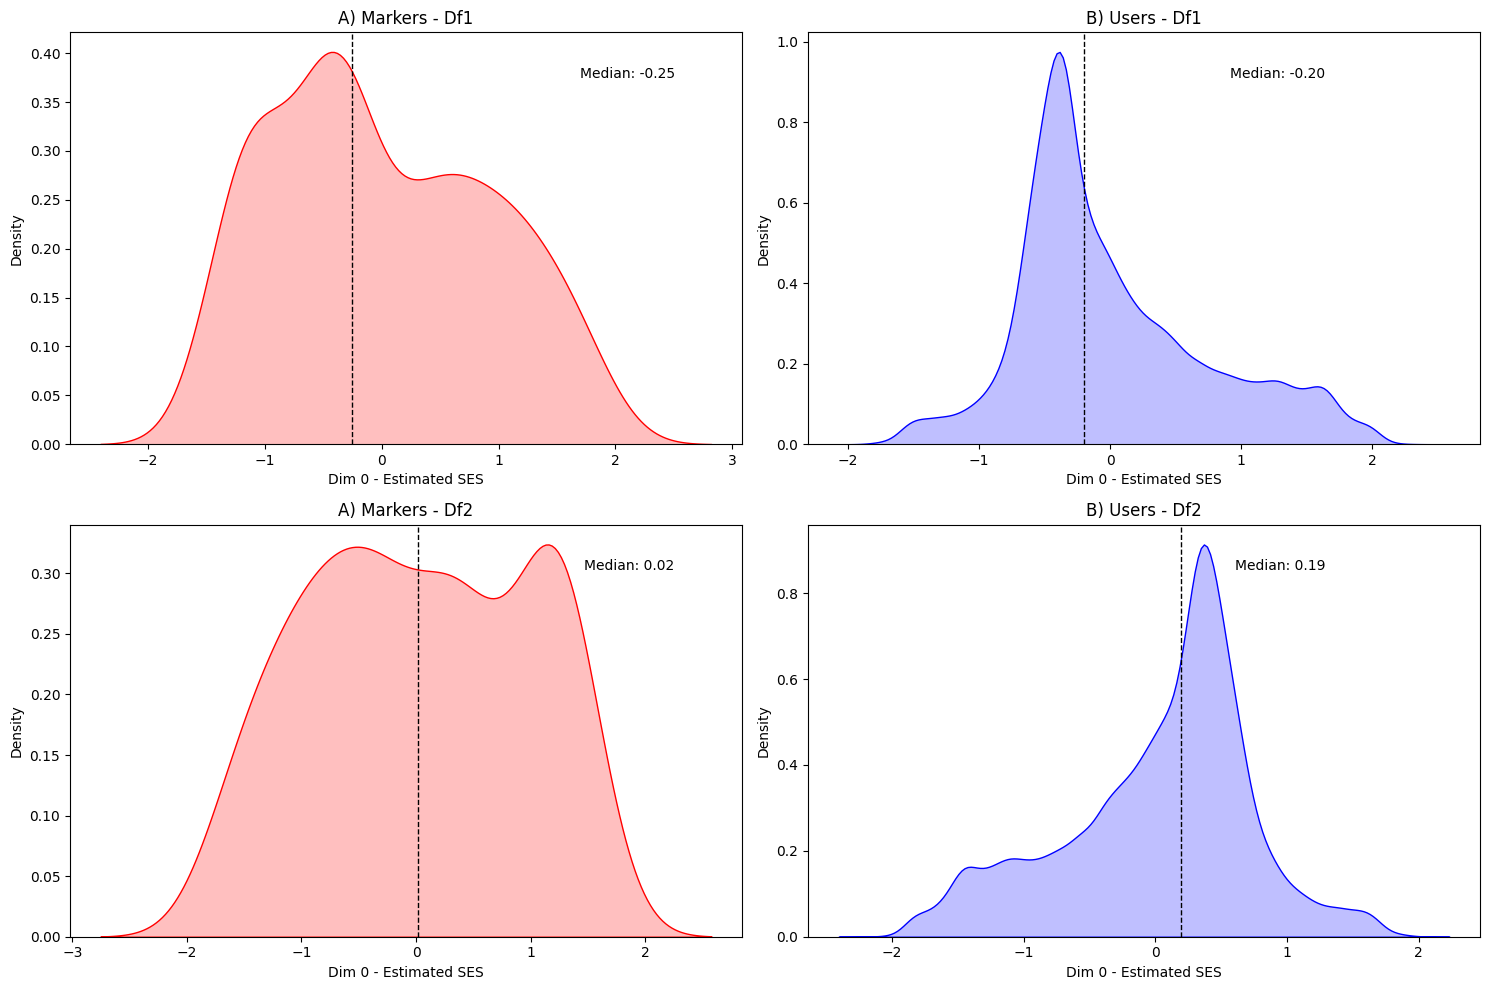

In [85]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#Kernal density estimate plot

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for i in range(2):
    # Plot the density of '0' for marker_coords[i]
    data = marker_coords[i]['0']
    sns.kdeplot(data, ax=axs[i, 0], color='red', fill=True)
    axs[i, 0].set_xlabel('Dim 0 - Estimated SES')
    axs[i, 0].set_ylabel('Density')
    axs[i, 0].set_title(f'A) Markers - Df{i + 1}')
    
    # Add a vertical line for the median of marker_coords[i]
    median_marker = np.median(data)
    axs[i, 0].axvline(median_marker, color='black', linestyle='dashed', linewidth=1)
    axs[i, 0].text(0.9, 0.9, f'Median: {median_marker:.2f}', horizontalalignment='right', verticalalignment='center', transform=axs[i, 0].transAxes)

    # Plot the density of '0' for user_coords[i]
    data = user_coords[i]['0']
    sns.kdeplot(data, ax=axs[i, 1], color='blue', fill=True)
    axs[i, 1].set_xlabel('Dim 0 - Estimated SES')
    axs[i, 1].set_ylabel('Density')
    axs[i, 1].set_title(f'B) Users - Df{i+1}')
    
    # Add a vertical line for the median of user_coords[i]
    median_user = np.median(data)
    axs[i, 1].axvline(median_user, color='black', linestyle='dashed', linewidth=1)
    axs[i, 1].text(0.77, 0.9, f'Median: {median_user:.2f}', horizontalalignment='right', verticalalignment='center', transform=axs[i, 1].transAxes)

plt.tight_layout()
plt.show()

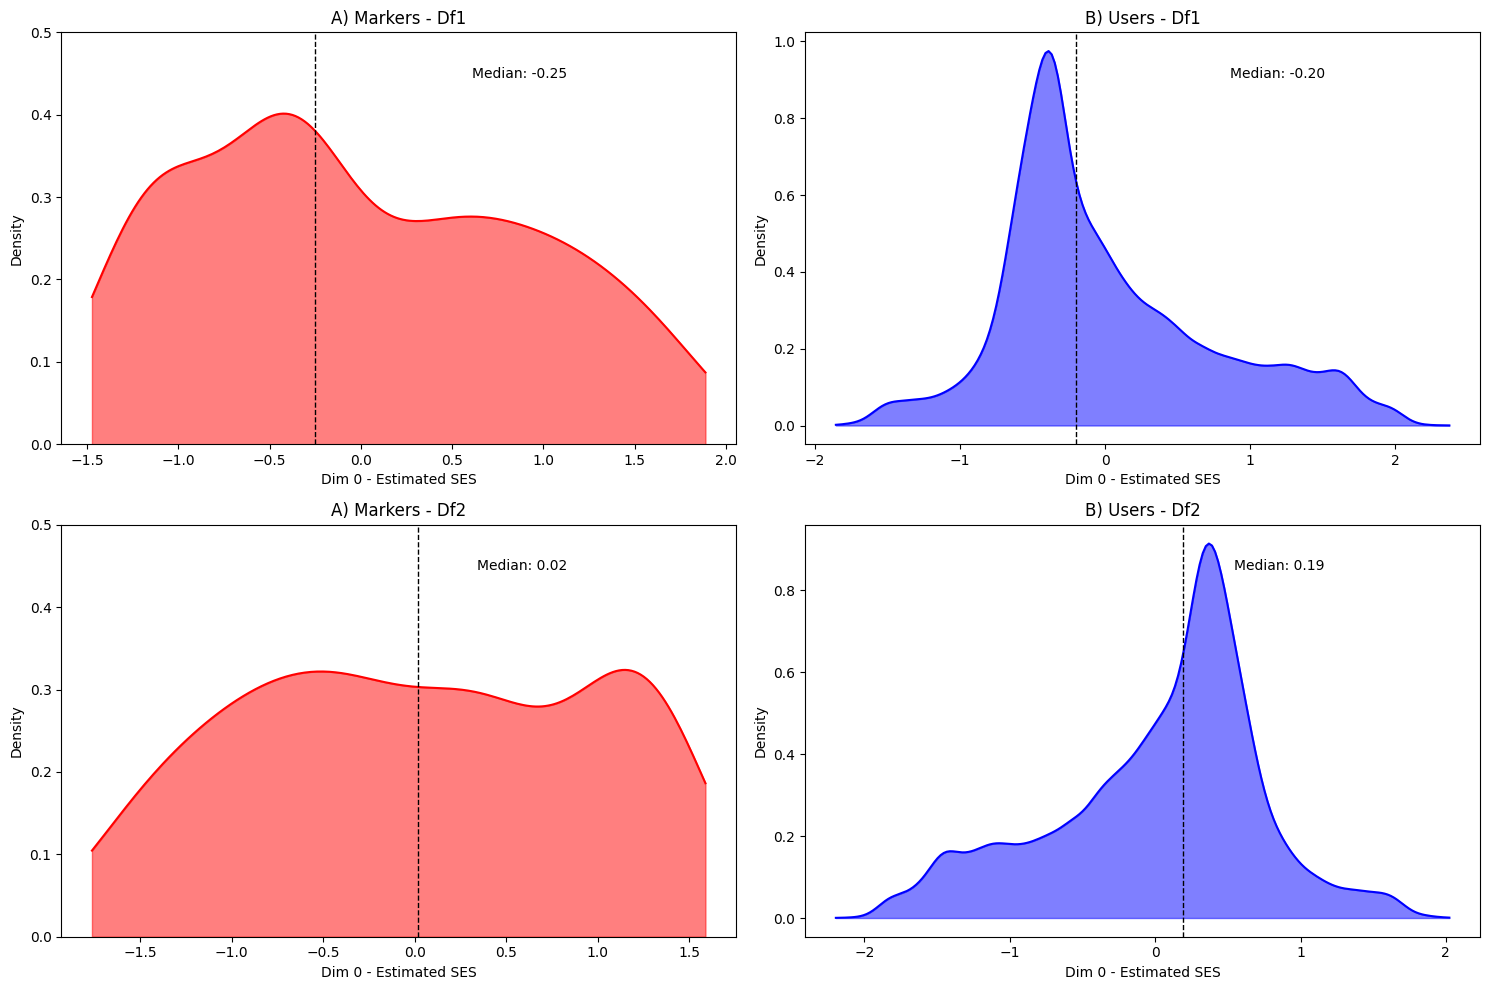

In [79]:
import numpy as np
from scipy.stats import gaussian_kde

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for i in range(2):
    # Plot the density of '0' for marker_coords[i]
    data = marker_coords[i]['0']
    density = gaussian_kde(data)
    xs = np.linspace(data.min(), data.max(), 200)
    axs[i, 0].plot(xs, density(xs), color='red')
    axs[i, 0].fill_between(xs, density(xs), color='red', alpha=0.5)
    axs[i, 0].set_xlabel('Dim 0 - Estimated SES')
    axs[i, 0].set_ylabel('Density')
    axs[i, 0].set_title(f'A) Markers - Df{i + 1}')
    axs[i, 0].set_ylim([0, 0.5])  # Set y limit
    
    # Add a vertical line for the median of marker_coords[i]
    median_marker = np.median(data)
    axs[i, 0].axvline(median_marker, color='black', linestyle='dashed', linewidth=1)
    axs[i, 0].text(0.75, 0.9, f'Median: {median_marker:.2f}', horizontalalignment='right', verticalalignment='center', transform=axs[i, 0].transAxes)

    # Plot the density of '0' for user_coords[i]
    data = user_coords[i]['0']
    density = gaussian_kde(data)
    xs = np.linspace(data.min(), data.max(), 200)
    axs[i, 1].plot(xs, density(xs), color='blue')
    axs[i, 1].fill_between(xs, density(xs), color='blue', alpha=0.5)
    axs[i, 1].set_xlabel('Dim 0 - Estimated SES')
    axs[i, 1].set_ylabel('Density')
    axs[i, 1].set_title(f'B) Users - Df{i+1}')
    
    # Add a vertical line for the median of user_coords[i]
    median_user = np.median(data)
    axs[i, 1].axvline(median_user, color='black', linestyle='dashed', linewidth=1)
    axs[i, 1].text(0.77, 0.9, f'Median: {median_user:.2f}', horizontalalignment='right', verticalalignment='center', transform=axs[i, 1].transAxes)

plt.tight_layout()
plt.show()

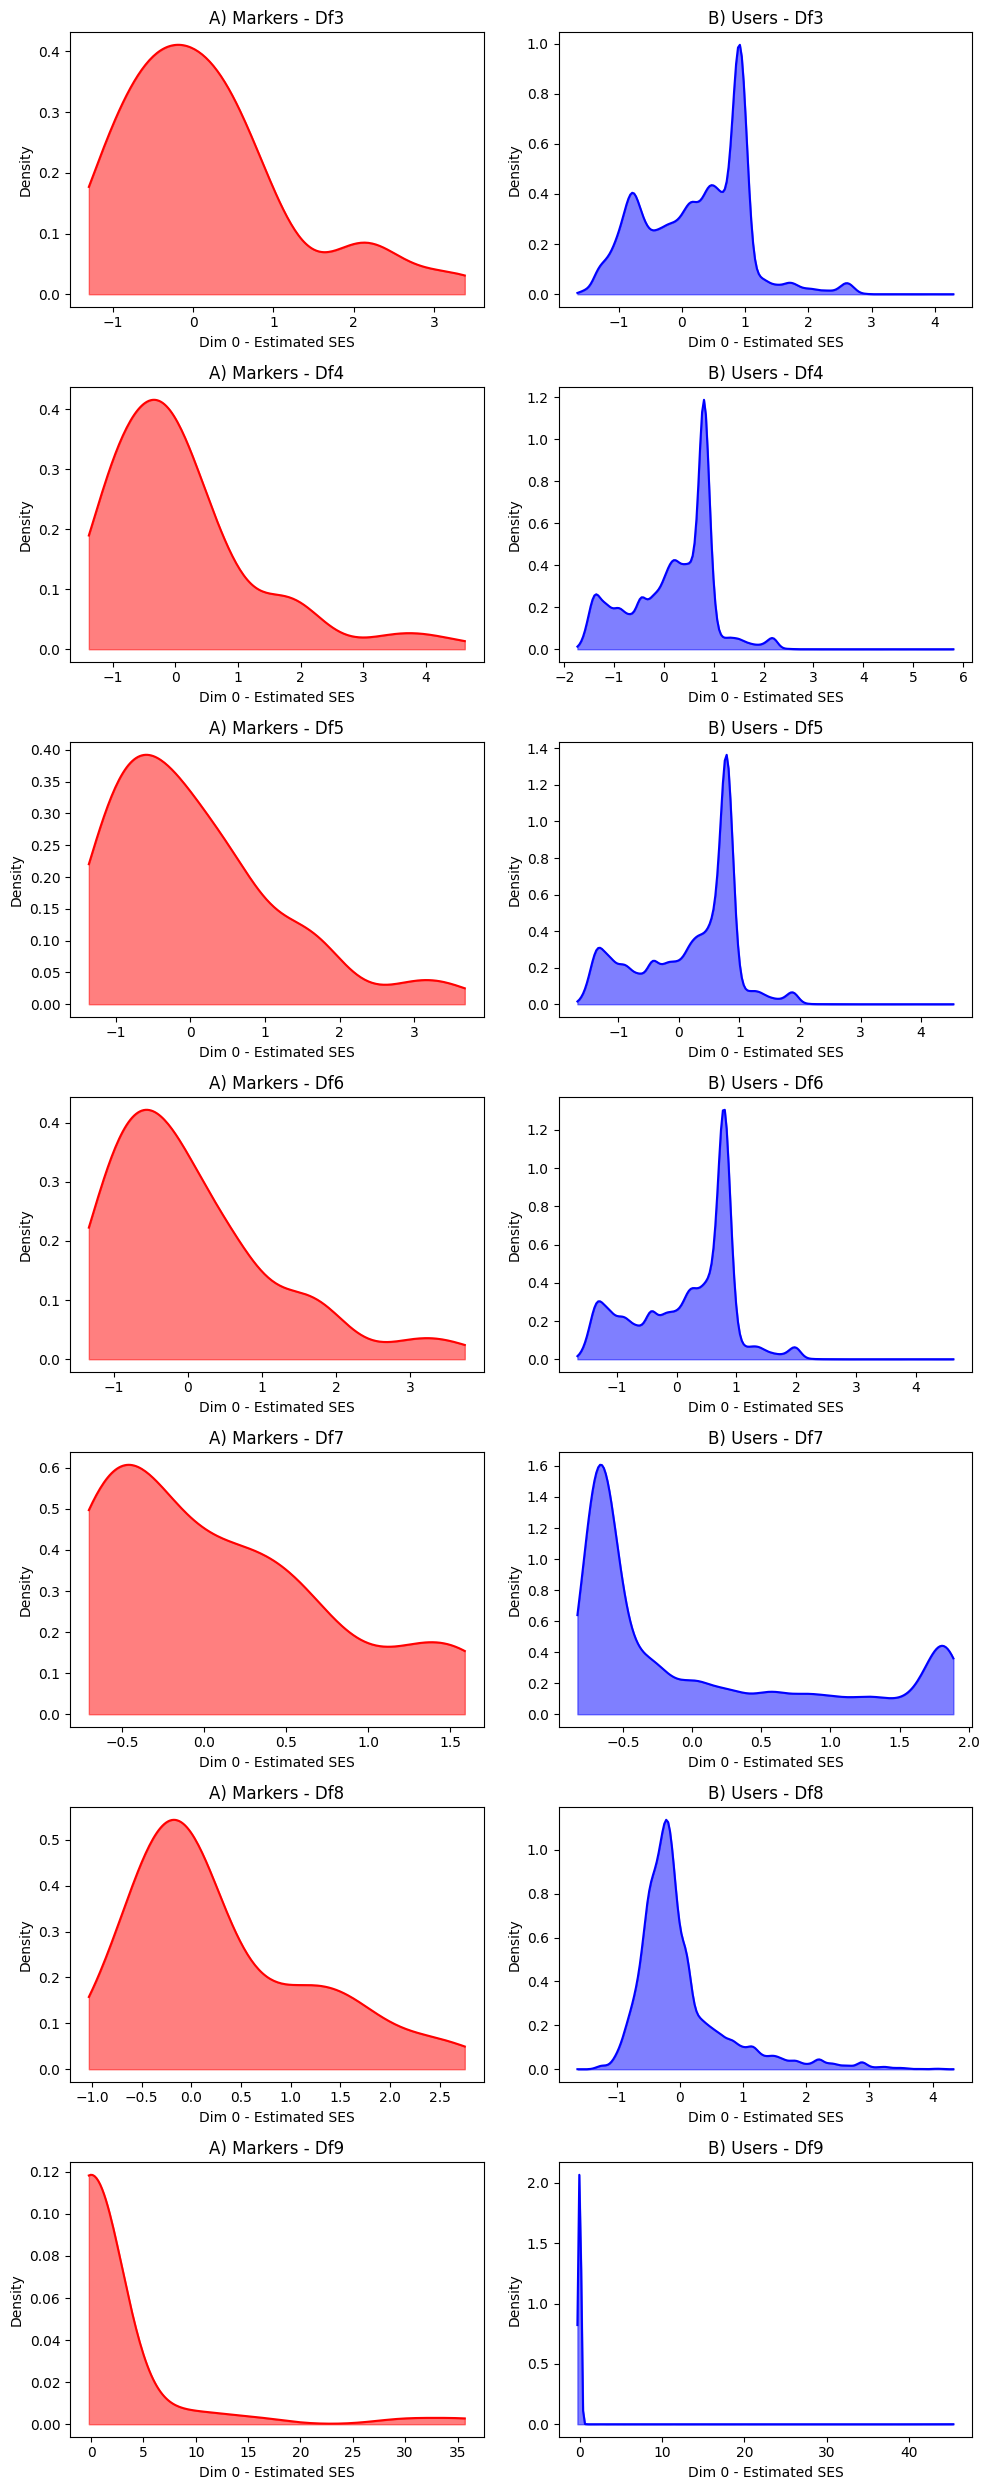

In [67]:
import numpy as np
from scipy.stats import gaussian_kde

fig, axs = plt.subplots(7, 2, figsize=(10, 25))

for i in range(2, 9):
    # Plot the density of '0' for marker_coords[i]
    data = marker_coords[i]['0']
    density = gaussian_kde(data)
    xs = np.linspace(data.min(), data.max(), 200)
    axs[i-2, 0].plot(xs, density(xs), color='red')
    axs[i-2, 0].fill_between(xs, density(xs), color='red', alpha=0.5)
    axs[i-2, 0].set_xlabel('Dim 0 - Estimated SES')
    axs[i-2, 0].set_ylabel('Density')
    axs[i-2, 0].set_title(f'A) Markers - Df{i + 1}')

    # Plot the density of '0' for user_coords[i]
    data = user_coords[i]['0']
    density = gaussian_kde(data)
    xs = np.linspace(data.min(), data.max(), 200)
    axs[i-2, 1].plot(xs, density(xs), color='blue')
    axs[i-2, 1].fill_between(xs, density(xs), color='blue', alpha=0.5)
    axs[i-2, 1].set_xlabel('Dim 0 - Estimated SES')
    axs[i-2, 1].set_ylabel('Density')
    axs[i-2, 1].set_title(f'B) Users - Df{i+1}')

plt.tight_layout()
plt.show()

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_title_distributions(df, *titles, alpha=0.5):
    colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown']  # Add more colors if needed

    for i, title in enumerate(titles):
        # Filter the dataframe for rows where 'title' is the current title
        df_title = df[df['title'] == title]

        # Plot the distribution of '0' for the current title
        sns.kdeplot(df_title['0'], color=colors[i % len(colors)], label=title, fill=True, alpha=alpha)

    plt.xlabel('0')
    plt.ylabel('Density')
    plt.title('Coordinate comparison for different job titles')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

In [169]:
def plot_PCS_ESE_name_distributions(df, PCS_ESE_code_to_name, *PCS_ESE_codes, alpha=0.5):
    # Get a color palette with as many colors as there are PCS_ESE_codes
    colors = sns.color_palette('hsv', n_colors=len(PCS_ESE_codes))

    for i, PCS_ESE_code in enumerate(PCS_ESE_codes):
        # Filter the dataframe for rows where 'PCS_ESE' is the current PCS_ESE_code
        df_PCS_ESE = df[df['PCS_ESE'] == PCS_ESE_code]

        # Get the corresponding name for the current PCS_ESE_code
        PCS_ESE_name = PCS_ESE_code_to_name[PCS_ESE_code]

        # Plot the distribution of '0' for the current PCS_ESE_code
        sns.kdeplot(df_PCS_ESE['0'], color=colors[i], label=PCS_ESE_name, fill=True, alpha=alpha)

    plt.xlabel('0')
    plt.ylabel('Density')
    plt.title('Coordinate comparison for different PCS_ESEs')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

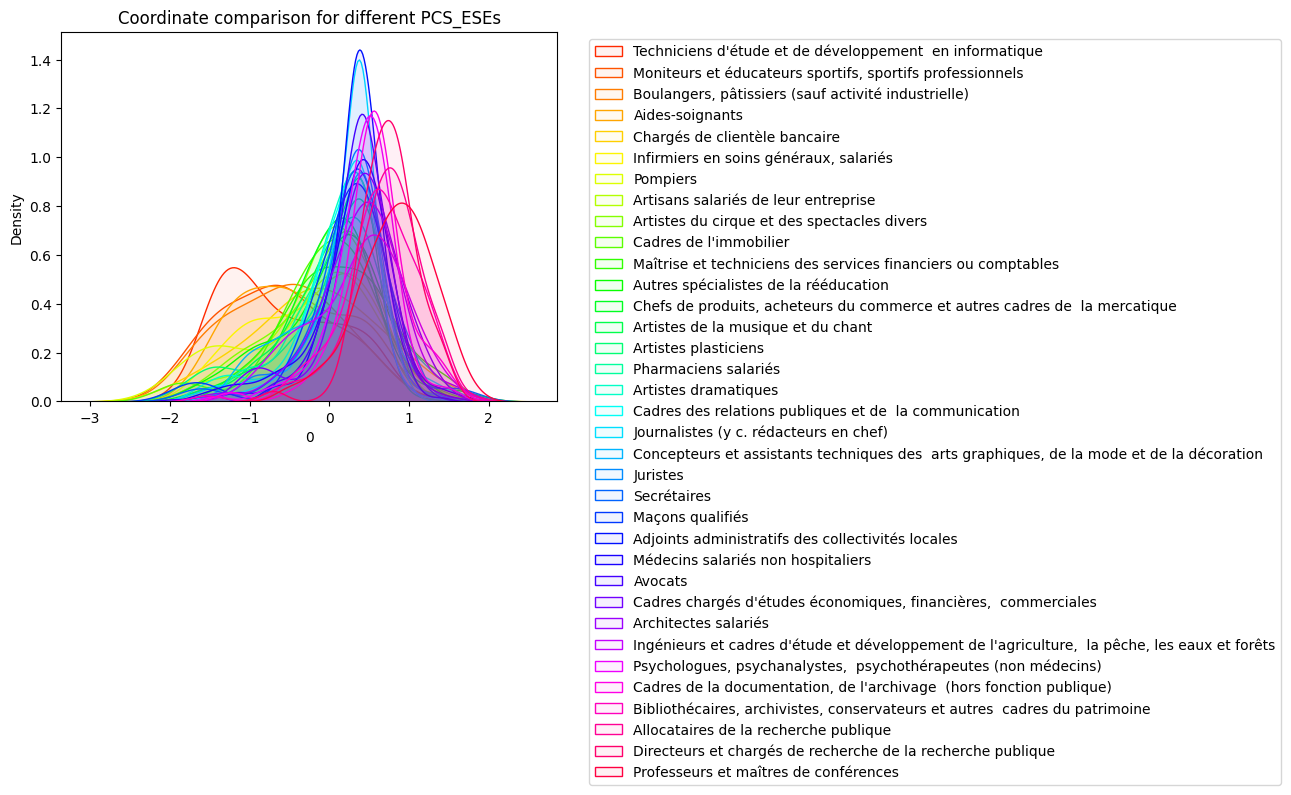

In [150]:
# Create a dictionary mapping PCS_ESE codes to names
PCS_ESE_code_to_name = dict(zip(job_coords[1]['PCS_ESE'], job_coords[1]['PCS_ESE_name']))

# Call the function with the PCS_ESE codes
plot_PCS_ESE_name_distributions(job_coords[1], PCS_ESE_code_to_name, '478a', '424a', '636c', '526a', '467a', '431f', '533a', '210x', '354f', '376g', '461d', '432d', '374b', '354b', '354a', '344d', '354c', '375b', '352a', '465a', '372e', '542a', '632a', '523c', '344b', '312a', '372a', '382b', '381b', '311d', '372f', '351a', '342h', '342f', '342b', alpha=0.06)

In [111]:
job_coords[1].columns

Index(['follower_id', '0', '1', '2', '3', 'screen_name', 'key_word',
       'description_cleantext', 'PCS_ESE', 'PCS_ESE_name', 'titles', 'label',
       'Salaire_moyen_en_EQTP', 'title'],
      dtype='object')

In [146]:
# Group by 'PCS_ESE' and filter groups with more than 30 users
filtered_df = job_coords[1].groupby('PCS_ESE').filter(lambda x: len(x) > 20)

# Calculate the median for each PCS_ESE in the filtered dataframe
medians = filtered_df.groupby('PCS_ESE')['0'].median()

# Sort the PCS_ESEs by median
sorted_medians = medians.sort_values()

# Get the sorted list of PCS_ESEs
sorted_PCS_ESEs = sorted_medians.index.tolist()

print("PCS_ESE groups with more than 30 users, sorted by median of '0':")
print(sorted_PCS_ESEs)

PCS_ESE groups with more than 30 users, sorted by median of '0':
['478a', '424a', '636c', '526a', '467a', '431f', '533a', '210x', '354f', '376g', '461d', '432d', '374b', '354b', '354a', '344d', '354c', '375b', '352a', '465a', '372e', '542a', '632a', '523c', '344b', '312a', '372a', '382b', '381b', '311d', '372f', '351a', '342h', '342f', '342b']


In [181]:
# Get the counts of each PCS_ESE code in the original dataframe
counts = df['PCS_ESE'].value_counts()

# Create a boolean mask for codes with more than 20 users
mask = counts > 20

# Filter the medians dataframe using the mask
medians = medians[mask]

# Create an empty list to store the top pairs
top_pairs = []

# Loop 5 times to get the top 5 pairs
for _ in range(5):
    # Calculate the pairwise differences between the medians
    differences = pd.DataFrame(np.abs(medians.values[:, None] - medians.values), 
                               index=medians.index, 
                               columns=medians.index)

    # Unstack the differences dataframe and sort by the differences
    sorted_differences = differences.unstack().sort_values(ascending=False)

    # Remove pairs with the same PCS_ESE (the difference is 0)
    sorted_differences = sorted_differences[sorted_differences.index.get_level_values(0) != sorted_differences.index.get_level_values(1)]

    # Only consider pairs where the first PCS_ESE is less than the second
    sorted_differences = sorted_differences[sorted_differences.index.get_level_values(0) < sorted_differences.index.get_level_values(1)]

    # Get the top pair
    top_pair = sorted_differences.idxmax()

    # Add the top pair to the list
    top_pairs.append(top_pair)

    # Remove the codes in the top pair from the medians series
    medians = medians.drop(list(top_pair))

print("Top 5 pairs of PCS_ESE groups with the largest differences in medians:")
for pair in top_pairs:
    print(pair)

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

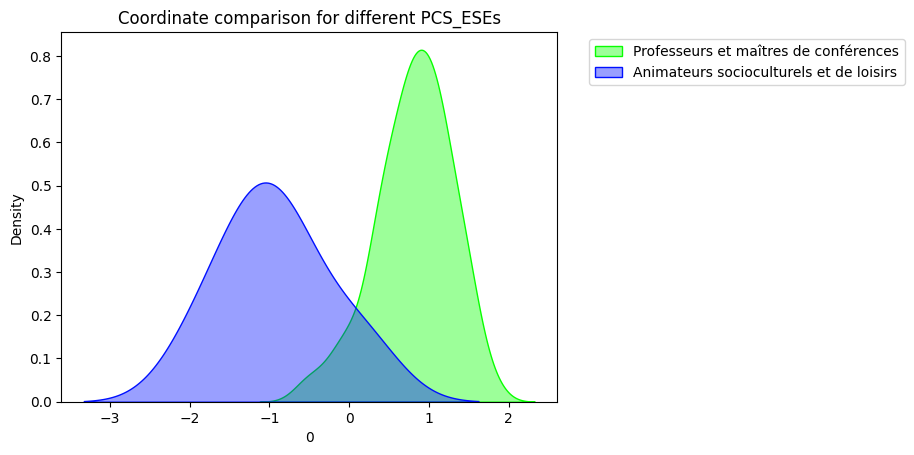

/tmp/ipykernel_2018876/2504346057.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df_PCS_ESE['0'], color=colors[i], label=PCS_ESE_name, fill=True, alpha=alpha)


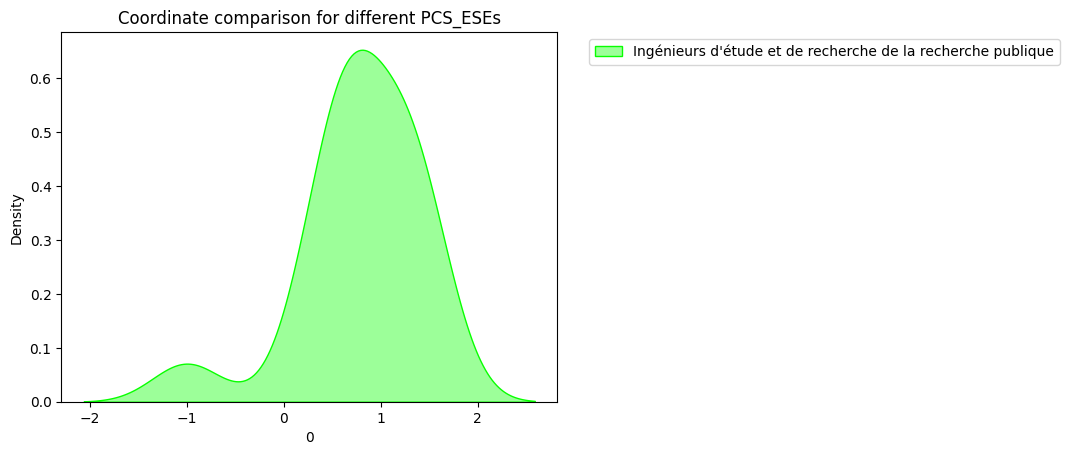

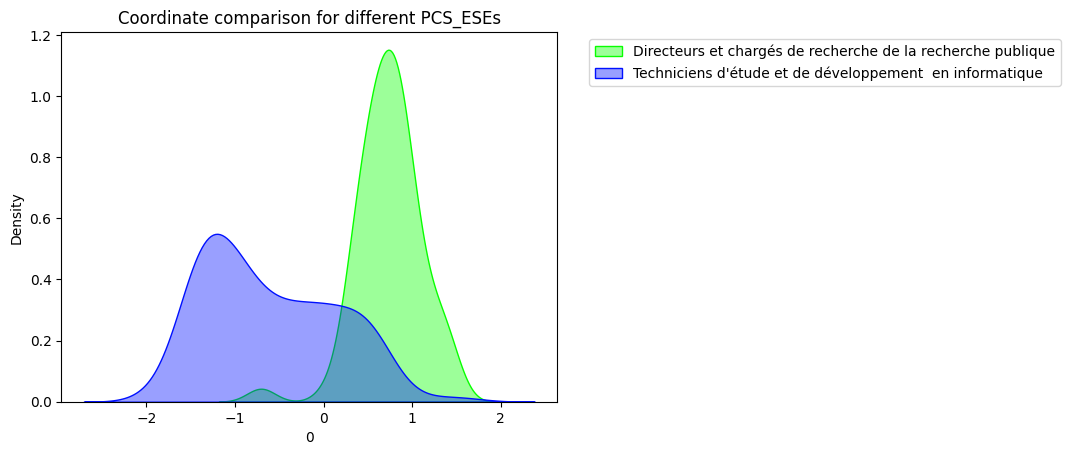

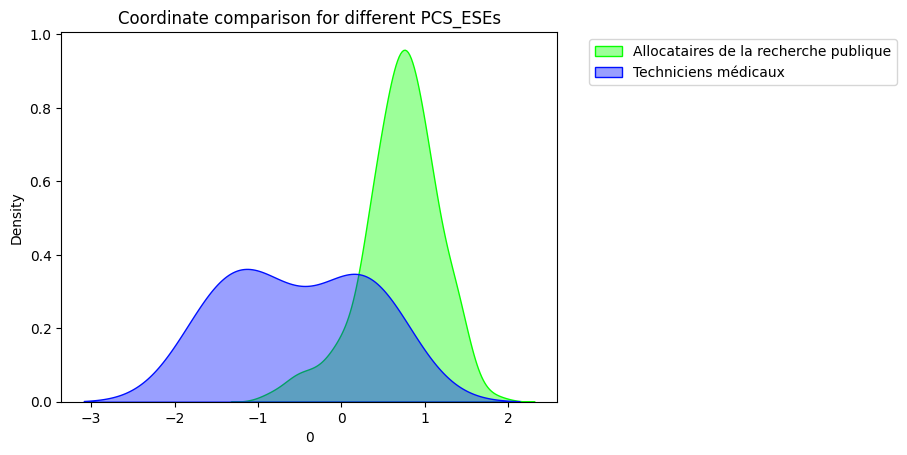

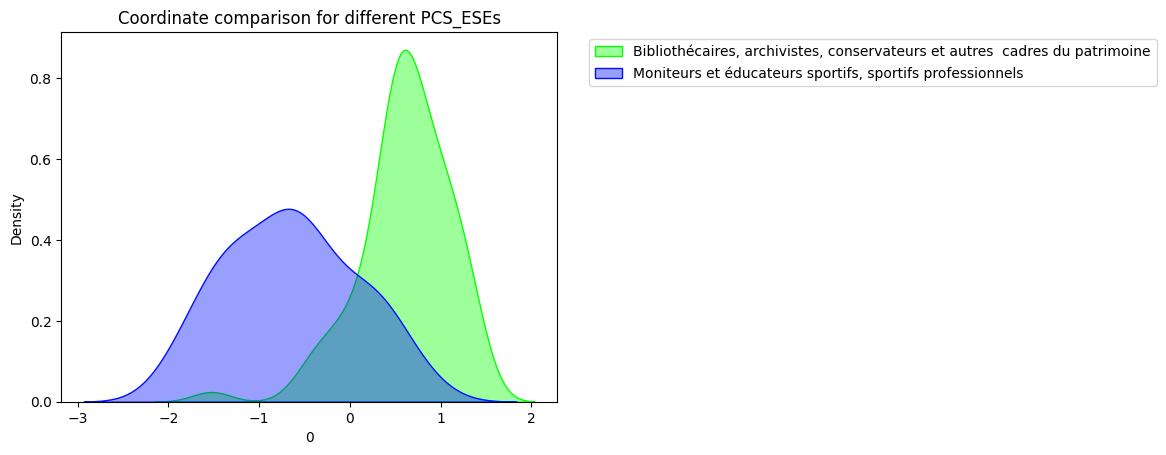

In [179]:
# Top 5 pairs of PCS_ESE groups with the largest differences in medians
top_5_pairs = [('342b', '435b'), ('342g', '465b'), ('342f', '478a'), ('342h', '433a'), ('351a', '424a')]

# Loop over the pairs
for pair in top_5_pairs:
    # Call the function with the PCS_ESE codes
    plot_PCS_ESE_name_distributions(job_coords[1], PCS_ESE_code_to_name, pair[0], pair[1], alpha=0.4)

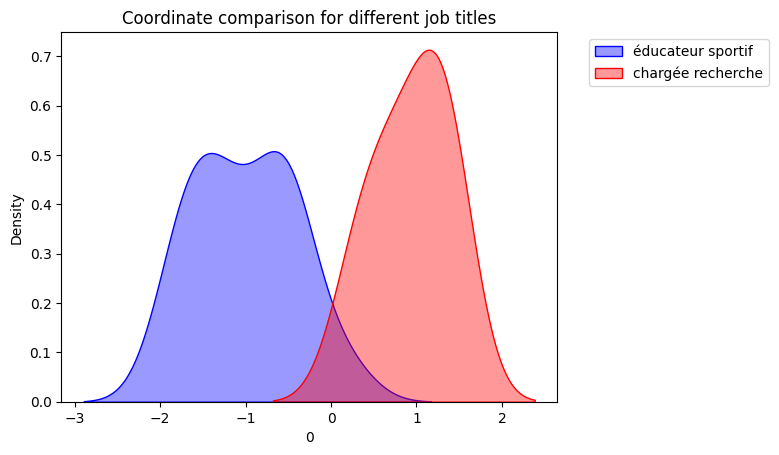

In [137]:

# Call the function with the titles you want to plot
plot_title_distributions(job_coords[1], 'éducateur sportif', 'chargée recherche', alpha=0.4)

In [104]:
# Calculate the median for each title
medians = job_coords[1].groupby('title')['0'].median()

# Sort the titles by median
sorted_medians = medians.sort_values()

# Get the sorted list of titles
sorted_titles = sorted_medians.index.tolist()

print("Titles sorted by median of '0':")
print(sorted_titles)

Titles sorted by median of '0':
['auditeur interne', 'éducateur sportif', 'animateur socioculturel', 'technicien laboratoire', 'développeur', 'assistant régisseur', 'conseiller commercial', 'pâtissier', 'conducteur routier', 'coach sportif', 'aide soignant', 'coiffeur', 'ingénieur agriculture', 'rappeur', 'maquilleuse', 'conducteur train métro', 'psychomotricien', 'esthéticienne', 'conducteur travaux', 'radiologue', 'developer', 'conseiller clientèle', 'barista', 'barman', 'analyste financier', 'artiste', 'danseur', 'chef produit', 'humoriste', 'infirmier', 'manucure', 'ostéopathe', 'aide domicile', 'pompier', 'boulanger', 'animateur radio', 'chef projet communication', 'chanteur', 'responsable réseaux sociaux', 'directeur artistique', 'graphiste', 'agent immobilier', 'guitariste', 'rédacteur web', 'artisan', 'directeur école', 'comptable', 'agent commercial', 'designer graphique', 'musicien', 'auteur compositeur interprète', 'chroniqueur', 'acteur', 'assistant direction', 'chargée com

In [ ]:
# Calculate the mean and count for each title
stats = dfs[6].groupby('title')['0'].agg(['mean', 'count'])

# Filter out titles with a count of 1
filtered_stats = stats[stats['count'] > 1]

# Calculate the mean absolute deviation for each title
mad = dfs[6].groupby('title')['0'].apply(lambda x: abs(x - x.mean()).mean())

# Sort the titles by mean absolute deviation
sorted_mad = mad.sort_values()

# Get the titles with the smallest mean absolute deviation (most precise)
most_precise_titles = sorted_mad.head(5)

# Get the titles with the largest mean absolute deviation (least precise)
least_precise_titles = sorted_mad.tail(5)

print("Titles with the most precision in '0' (accounting for sample size):")
print(most_precise_titles)

print("\nTitles with the least precision in '0' (accounting for sample size):")
print(least_precise_titles)

### Type overview

In [4]:
#Load the marker coords
marker_coords = utils2.load_all_column_coords_files(2)
df1 = marker_coords[0]
df2 = marker_coords[1]

Used file path: /home/livtollanes/NewData/coordinates/m1_coords/m1_column_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m2_coords/m2_column_coordinates.csv


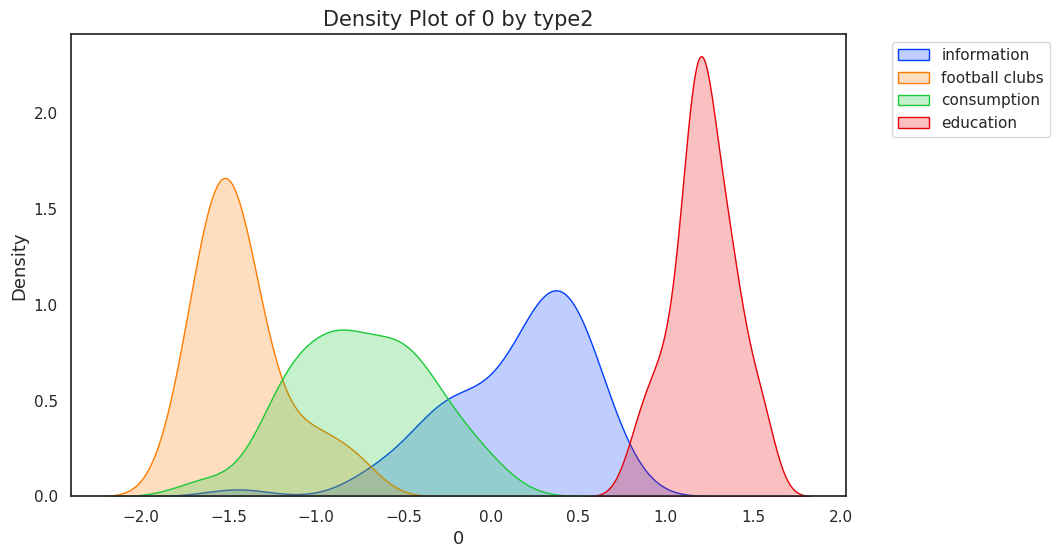

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style and color palette of the plot
sns.set(style="white")
sns.set_palette('bright')

# Create a new figure
plt.figure(figsize=(10, 6))

# Loop over each type2
for type2 in df2['type2'].unique():
    # Subset to the type2
    subset = df2[df2['type2'] == type2]
    # Draw the density plot
    sns.kdeplot(subset['0'], label = type2, fill = True)

# Place the legend outside the figure/plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Updated line

# Set the labels and title
plt.xlabel('0', size=13)
plt.ylabel('Density', size=13)
plt.title('Density Plot of 0 by type2', size=15)

# Show the plot
plt.show()

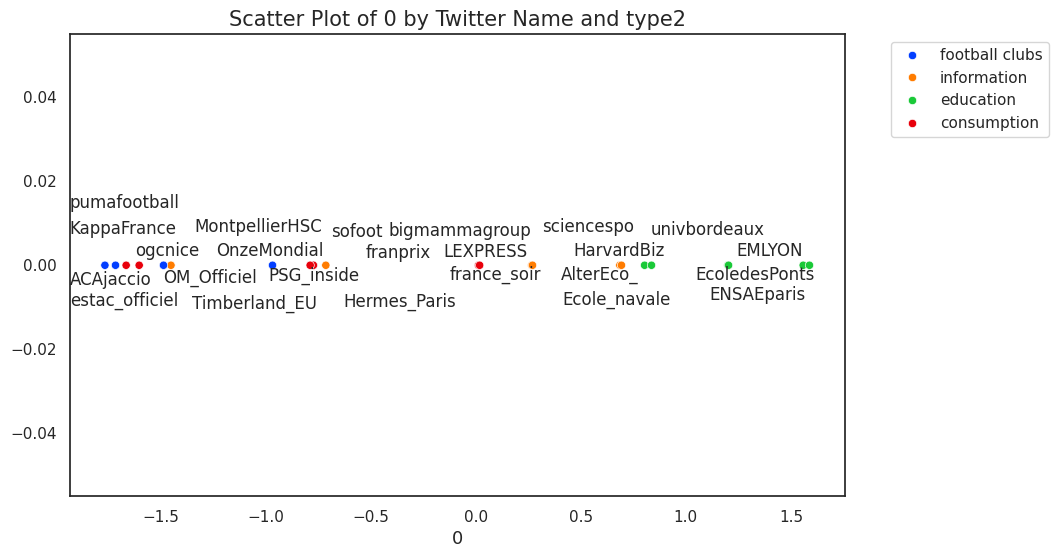

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from adjustText import adjust_text  # Import adjust_text

# Set the style and color palette of the plot
sns.set(style="white")
sns.set_palette('bright')  # Set color palette to 'bright'

# Initialize an empty DataFrame to store the selected 'twitter_name'
df2_selected = pd.DataFrame()

# For each 'type2', select the two 'twitter_name' with the lowest, middle, and highest '0'
for type2 in df2['type2'].unique():
    subset = df2[df2['type2'] == type2]
    sorted_subset = subset.sort_values('0')
    lower = sorted_subset.head(2)
    middle = sorted_subset.iloc[sorted_subset.shape[0]//2 - 1 : sorted_subset.shape[0]//2 + 1]
    upper = sorted_subset.tail(2)
    df2_selected = pd.concat([df2_selected, lower, middle, upper])

# Filter the DataFrame to include only the selected 'twitter_name'
df2_filtered = df2[df2['twitter_name'].isin(df2_selected['twitter_name'])]

# Create a new figure
plt.figure(figsize=(10, 6))

# Create a scatter plot with points colored by 'type2'
ax = sns.scatterplot(x='0', y=np.zeros_like(df2_filtered['0']), hue='type2', data=df2_filtered)

# Initialize a list to store the texts
texts = []

# Annotate each point with the 'twitter_name'
for i in range(df2_filtered.shape[0]):
    texts.append(ax.text(df2_filtered['0'].iloc[i], 0, df2_filtered['twitter_name'].iloc[i]))

# Adjust the position of the texts to minimize overlaps
adjust_text(texts, expand_points=(1.5, 1.5), arrowstyle=dict(arrowstyle='->', color='black', alpha=0.5))

# Set the labels and title
plt.xlabel('0', size=13)
plt.title('Scatter Plot of 0 by Twitter Name and type2', size=15)

# Place the legend outside the figure/plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

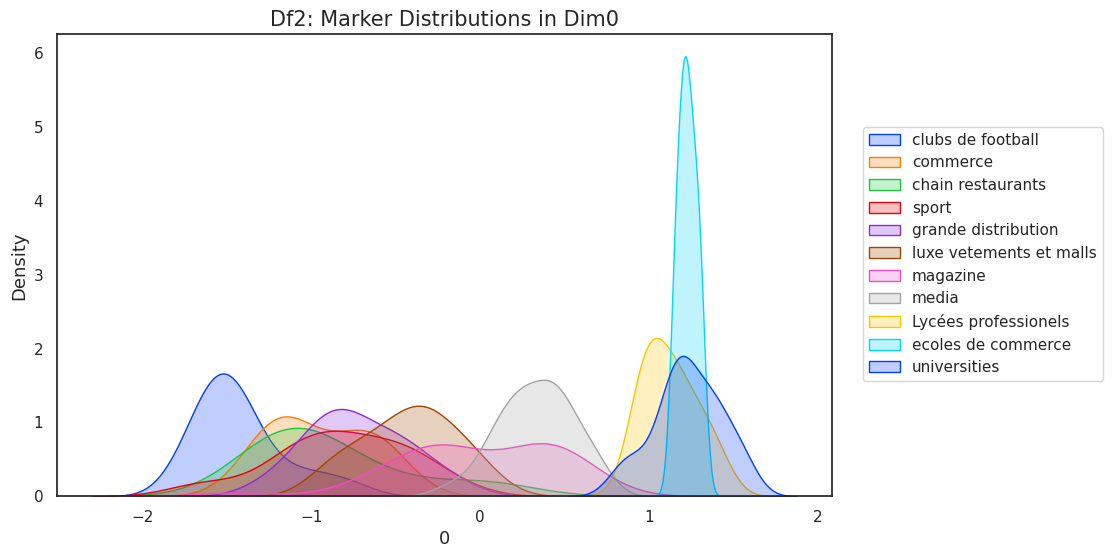

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style and color palette of the plot
sns.set(style="white")
sns.set_palette('bright')

# Create a new figure
plt.figure(figsize=(10, 6))

# Create a list of types sorted by their mean '0' value
types_sorted = df2.groupby('type')['0'].mean().sort_values().index

# Loop over each type in the sorted list
for type_ in types_sorted:
    # Subset to the type
    subset = df2[df2['type'] == type_]
    # Draw the density plot
    sns.kdeplot(subset['0'], label = type_, fill = True)

# Place the legend outside the figure/plot
plt.legend(bbox_to_anchor=(1.35, 0.8),borderaxespad=0)

# Set the labels and title
plt.xlabel('0', size=13)
plt.ylabel('Density', size=13)
plt.title('Df2: Marker Distributions in Dim0', size=15)

# Show the plot
plt.show()

/tmp/ipykernel_2028386/1787752038.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_filtered['twitter_name'] = pd.Categorical(df2_filtered['twitter_name'], categories=twitter_names_sorted, ordered=True)


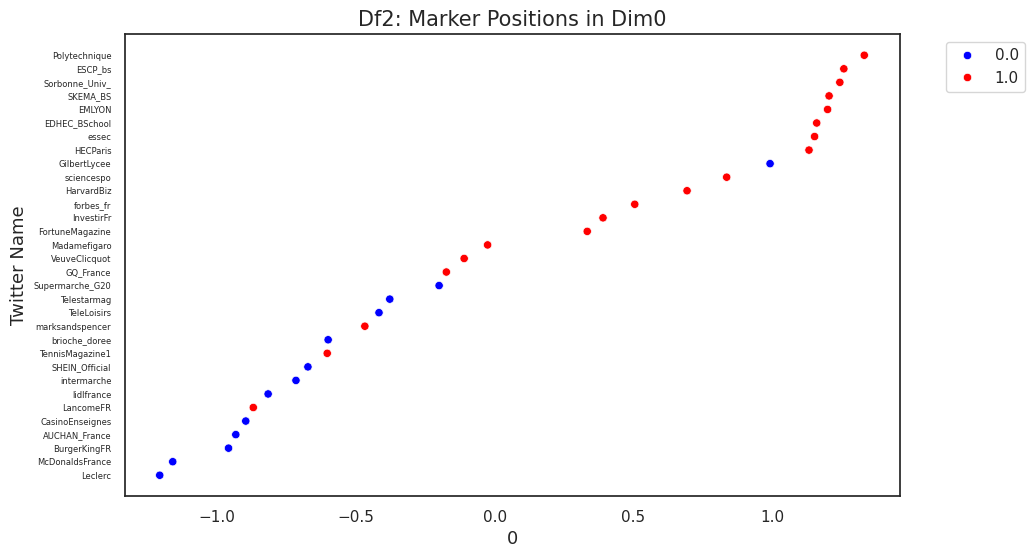

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Set the style of the plot
sns.set(style="white")


# Filter the DataFrame to include only the rows with label 0 or 1
df2_filtered = df2[df2['label'].isin([0, 1])]

# Create a list of twitter_name values sorted by their mean '0' value
twitter_names_sorted = df2_filtered.groupby('twitter_name')['0'].mean().sort_values(ascending=False).index

# Convert the 'twitter_name' column to a categorical type with the sorted order
df2_filtered['twitter_name'] = pd.Categorical(df2_filtered['twitter_name'], categories=twitter_names_sorted, ordered=True)

# Create a new figure
plt.figure(figsize=(10, 6))

# Create a scatter plot with points colored by 'label'
ax = sns.scatterplot(x='0', y='twitter_name', hue='label', data=df2_filtered, palette={0: 'blue', 1: 'red'})  # Save the Axes object returned by scatterplot

# Set the labels and title
plt.xlabel('0', size=13)
plt.ylabel('Twitter Name', size=13)
plt.title('Df2: Marker Positions in Dim0', size=15)

# Change the size of the y-axis labels
ax.tick_params(axis='y', labelsize=6)  # Change 'large' to any valid size string or number

# Place the legend outside the figure/plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

### Job bios descriptions

In [29]:
job_coords = utils2.load_CA_model_files(2)
job1 = job_coords[0]
job2 = job_coords[1]

Used file path: /home/livtollanes/NewData/job_title_coordinates/m1_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m2_jobs_rowcoords.csv


In [40]:
user_coords = utils2.load_all_row_coords_files(2)
user1 = user_coords[0]
user2 = user_coords[1]

Used file path: /home/livtollanes/NewData/coordinates/m1_coords/m1_row_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m2_coords/m2_row_coordinates.csv


In [43]:
user2.columns

Index(['follower_id', '0', '1', '2', '3'], dtype='object')

In [63]:
# Sort the DataFrame by the '0' column
sorted = full2.sort_values(by='0')

# Select the columns to display
columns_to_display = ['0', 'screen_name', 'description_cleantext']

# Get the 20 rows with the lowest '0' values and assign to a new DataFrame
low_df = sorted[columns_to_display].head(20)

# Get the 20 rows in the middle and assign to a new DataFrame
middle_index = sorted.shape[0] // 2
mid_df = sorted[columns_to_display].iloc[middle_index - 10 : middle_index + 10]

# Get the 20 rows with the highest '0' values and assign to a new DataFrame
high_df = sorted[columns_to_display].tail(20)

In [67]:
pd.set_option('display.max_colwidth', None)  # Display full column width
low_df

0      screen_name  \
3387   -2.196695        Skunkinh0   
94386  -2.178731        romgooner   
96442  -2.166543      masterdiete   
14396  -2.138740    Oxygene_tango   
111566 -2.136415      bit_georges   
21522  -2.130742      JulieDfco21   
62713  -2.109358    SportsValeurs   
46226  -2.095396  Seb10500harmand   
89319  -2.088521        lampe_led   
100686 -2.080142     NathJonchere   
33874  -2.068423          FCRouen   
53444  -2.067748     remiclement_   
101355 -2.065134   LaurentASM1975   
25276  -2.053361       CamaRennes   
22393  -2.050506      PaulGandner   
53849  -2.038767    Bourges18_off   
80685  -2.038614         ghighi89   
69130  -2.036843      antoinecaup   
63173  -2.034918  MijeAssociation   
114842 -2.034348        ActuSRFC_   

                                                                                                                                                       description_cleantext  
3387                                                                                             L'humilié c'est le charme d'un homme La timidité c'est le chame d'une femme  
94386                                                Arsenal fcCome on you gunners #KroenkeOutRock; Bière artisanale.Entrepreneur indépendant en immobilier (IAD) dans le 77  
96442                   le cheat meal le meilleur des reconfort apres une semaine de diete strict .je vais tenter de creer un vaste choix de pizza fole,unique et delicieuse  
14396   WebRadio officielle  du @stadelavallois // http://www.stade-lavallois.com/o-fm-tango // 90.1 FM à Laval // http://rhasl.creacast.com sur smartphone // #OxygeneTango  
111566                           DSIManagement et stratégie d'entrepriseLogistique et transport.Passionné du numériqueÉmergence juvénile Africaine.http://www.inix-group.com  
21522                                                                                                                           Fan du rc Lens et du Dfco CM: @100_DFCO_NEWS  
62713                                                                    Partageons les bonnes pratiques du sports ! Suivez nos articles sur http://www.sportsetvaleurs.com/  
46226                                                                                                                                      RAF à @GrandGeneveFC (#N3 & #D2F)  
89319                                                                                           Vente de produits d'éclairage à Led de qualité Professionnelle à petit prix.  
100686                                                                                          Chef d'équipements/ingénieur vision @M6  Écologiste.   Codir @allonsenfants_  
33874                                           Parce que Rouen, c'est NOUS !    http://instagram.com/fcrouen1899   http://tiktok.com/@fcrouen1899#TeamFCR #Rouen #Normandie  
53444                                                                                                                                        Je suis journaliste @Challenges  
101355                passionné de Football, surtout l’AS Monaco  depuis toujours et Manceau depuis 2018, donc attaché au Mans FC , ce peuple et ce stade mérite la ligue 1.  
25276                                                                                                                                                   Fan du Stade Rennais  
22393                                                                                                                                          Toulouse ma ville @toulousefc  
53849                                                                          Bienvenue sur le compte officiel du Bourges 18, club de football évoluant en National 3. #B18  
80685                  Le sport c'est génial pour s'investir, prendre plaisir; se donner et acquérir des valeurs. un média pour rebondir sur certains traumatismes de la vie  
69130                                                                                  

In [68]:
mid_df

0      screen_name  \
15177   0.190474   FranceMadinina   
31994   0.190493         CMattout   
18549   0.190493  MathieuQuentin4   
75665   0.190502     fredpetenian   
35072   0.190509  bullesjosephine   
8819    0.190516      TrangMarie1   
5703    0.190530      Lingerie_et   
50772   0.190570          krysstl   
77857   0.190577   nathalielopes3   
28133   0.190603  viple_cath63763   
43175   0.190611      tommyhubert   
6862    0.190611       InfosParis   
88649   0.190641       vmilchberg   
16992   0.190647      lau_patrice   
90693   0.190657     JulieTadduni   
79946   0.190659     VincentAutin   
106221  0.190669  valentinleboss3   
7203    0.190725        linaGuers   
5331    0.190729  DjovanyMICHEL01   
24965   0.190729           tuenis   

                                                                                                                                                  description_cleantext  
15177                                                                                                                                        Fallait pas voter Macron !  
31994                                              Journaliste @bfmtv / Podcast « 11 septembre l’enquête » @franceinter / Passée par @TF1, @franceinfo et @F2Washington  
18549               Conseiller alimentation @Agri_Gouv #agriculture #alimentation #économie #marchés Membre du @Le_Demeter, professeur @ihedrea @isaralyon @ParisSaclay  
75665                              @ARBE_RegionSud #biodiversité #environnement #transitionecologique #ecologiescientifique #amenagement #devdurable #europe #biodivalp  
35072                                                                                              Etudiante en LEA - Blogueuse Culinaire Bordelaise - #cuisine - #LBDJ  
8819                                                                                                Attachée de presse / Flammarion Littérature Générale @Ed_Flammarion  
5703          #entrepreneur #LesFemmes #morphologie #soutienauxcreateursdelingerie #promotelingeriedesigners suivez-nous sur Insta,Facebook et Pinterest : @Lingerie_et  
50772   Journaliste France Télévision Guadeloupe 1ère/France Ô/ auparavant Equipe 24/24 Passionnée de Sports...rêve de jouer en NBA avec Wade...ben quoi? Twitter perso  
77857        la liberté d'expression n'autorise pas à dire n'importe quoi. Mon expression n''engage que moi. Au service politique de @franceculture et @francemusique..  
28133                     Ex puéricultrice hospitalière maintenant à la retraite.. Éclairée depuis ces dernières années j'ai toujours pris soin de ma santéVégétarienne  
43175                                                                                                                                                 Attaché de presse  
6862                                                                          Interview people, théâtre, concerts, expos, bons plans, critique ciné et resto... à Paris  
88649                  Élève avocat 2022 (CRFPA 2021). Former A&R Manager (naïve / Wagram / Universal). Fondateur de @lapsrl. Porteño à Paris, Parisien à Buenos Aires.  
16992                                           Adjointe à la maire de @Paris #mémoire #mondecombattant / Élue #Paris10 chargée #culture / Membre Conseil National #PCF  
90693                                                 Journaliste chez @iFSaintEtienne.  Ex @courriercadres @Rebondir_mag et ex parisienne. Passée par @Leprogresloire.  
79946                    Défenseur des droits humains #HumanRights - Chroniqueur @jtmetc @France2TV rubrique #Friendly #LGBTQI - 1er marié #homo #France fier & honoré   
106221          Journaliste @76actu / ex @Eureinfodepeche @eveilponto @OuestFrance @paris_normandie @MensueldeRennes @TelegStBrieuc / Formé au master JRE @Sc_Po_Rennes  
7203                                                                Attaché d'administration Hospitalière actuellement Responsable unité accompagnement et suivi public  
5331   

In [69]:
high_df

0      screen_name  \
50828   1.916106          upstifr   
99989   1.918851       AptiSkills   
109316  1.923650      PontsAlumni   
114939  1.940355     MathieuJouve   
105624  1.944159         tekkitIo   
23316   1.971429      StephetFred   
103058  1.971429       Integrerlx   
91712   1.971429     MelvynBoukli   
48661   1.971429    GroupeIngerop   
90754   1.971429     RemiFerrand_   
49235   1.971429    benextcompany   
60632   1.971429    natalielust69   
64711   1.971429  BigDataAristote   
48576   1.971429   g_lechevallier   
77595   1.971429   Smartmechanics   
109734  1.971429  degust_harmonie   
7058    1.971429      LaurentIIHE   
81563   1.977211   delphine_tweet   
19948   1.983604  ObjectifDataSci   
106017  2.023790         batiactu   

                                                                                                                                                  description_cleantext  
50828      Union des Professeurs de Sciences et Techniques Industrielles. 700 profs de Sciences de l’Ingénieur & Informatique notamment en classe prépa  scientifiques.  
99989     AptiSkills est une société de #conseil en #ingénierie spécialisée dans le #BTP, #Industrie & l'#IT disposant de 5 agences à Lyon, Paris, Marseille & Bordeaux  
109316                                                        Association des #diplômés de @EcoleDesPonts, école d'ingénieurs depuis 1747 !#réseau #animation #carrière  
114939                                                                                   Responsable du Pôle Talent Acquisition IDF Sud @Thales #Rungis #Massy #Limours  
105624      #Tekkit est le premier #RéseauSocial professionnel pour les métiers de la #Tech, de l'#IT et de l'#Ingénierie. Rejoignez la communauté : https://tekkit.io/  
23316                                               HPE Education Services France vous propose des formations sur les technologies HPE mais aussi Microsoft, VMware....  
103058                                                  Méthodes et astuces en prépa scientifique pour réussir les concours des plus prestigieuses écoles d'ingénieurs.  
91712                                                                                     Directeur Général (CEO) de @EasywaFR           contact pro : melvyn@easywa.fr  
48661          Groupe français d'#ingénierie, Ingérop est spécialisé en #infrastructures #bâtiment #ville #mobilité #transports #eau #environnement #industrie #énergie  
90754                                                                   Dg @talentsdunum, #lobbying @cinovnumerique @federationcinov et encore un peu @syntecnumerique.  
49235                                 BENEXT devient OCTO Technology, une société de conseil spécialisée dans le développement logiciel et la transformation numérique.  
60632       Actrice porno et nympho  Si tu veux me rencontrer pour un plan coquin, Je réponds UNIQUEMENT ici :  http://bit.ly/Natalie_Privé  (Me déplace sur la France)  
64711                                      Ce compte est inactif depuis le 22 décembre 2016, merci de suivre le @AristoteAsso pour ne rien manquer de notre actualité !  
48576                               Directeur d'Unité @mc2iGroupe,  #Conseil en Système d'Information et organisation (#SI). Sponsor de l'offre sectorielle #Transport.  
77595                           La mécanique pour l'Industrie du futur. Le réseau SmartMeca distribue et vous aide à mieux utiliser vos outils #cao #simulation #essais  
109734                              Consultant, formateur et animateur en oenologiechez Dégustation et Harmonie"Mieux analyser le vin pour laisser parler vos émotions"  
7058        Pour partager sur des sujets qui me tiennent à cœur. En vrac fun/pédagogie/tech/société/musique. Dans tous les cas c'est personnel et ça n'engage que moi !  
81563                                                                  HR Development #RH #Recrutement #Formation #Communication #MarqueEmployeur #Digital Fan de rugby  
19948  

In [54]:
#Load the income + job title data
path= '/home/livtollanes/NewData/french/'
file = 'french1_updated.csv'
bios = pd.read_csv(path + file, dtype={'follower_id': str})

In [55]:
bios.head()

follower_id      screen_name  \
0          2419429508         Max_Mth_   
1  902419434358403072       Hellodie41   
2            44372703  julienmielcarek   
3          1640041946         QDebrand   
4          3118973117  jeanluc_bouchet   

                                         description  timestamp_utc  \
0  Radio, web, magazine - culture, société, vie a...   1.396208e+09   
1  Ma thérapie : raconter ma vie a des gens qui n...   1.503989e+09   
2  Directeur des rédactions digitales BFM-RMC / C...   1.244040e+09   
3                      Directeur Adjoint @LDLC_Arena   1.375435e+09   
4  cadre informatique secteur hospitalier\nIntérê...   1.427383e+09   

         location                              description_cleantext language  \
0   paris, france  Radio, web, magazine - culture, société, vie a...       fr   
1   blois, france  Ma thérapie : raconter ma vie a des gens qui n...       fr   
2           paris  Directeur des rédactions digitales BFM-RMC / C...       fr   
3    lyon, france                      Directeur Adjoint @LDLC_Arena       fr   
4  betton, france  cadre informatique secteur hospitalierIntérêt ...       fr   

  country  
0  France  
1  France  
2  France  
3  France  
4  France

In [60]:
importlib.reload(utils2)


# Loop over file numbers 1 through 9
for file_number in range(1, 10):
    # Call the function with file_number and bios
    merged_df = utils2.merge_bio_coords(file_number, bios)
    print(f"Merged DataFrame for file number {file_number} created.")


Used file path: /home/livtollanes/NewData/coordinates/m1_coords/m1_row_coordinates.csv
Merged DataFrame for file number 1 created.
Used file path: /home/livtollanes/NewData/coordinates/m2_coords/m2_row_coordinates.csv
Merged DataFrame for file number 2 created.
Used file path: /home/livtollanes/NewData/coordinates/m3_coords/m3_row_coordinates.csv
Merged DataFrame for file number 3 created.
Used file path: /home/livtollanes/NewData/coordinates/m4_coords/m4_row_coordinates.csv
Merged DataFrame for file number 4 created.
Used file path: /home/livtollanes/NewData/coordinates/m5_coords/m5_row_coordinates.csv
Merged DataFrame for file number 5 created.
Used file path: /home/livtollanes/NewData/coordinates/m6_coords/m6_row_coordinates.csv
Merged DataFrame for file number 6 created.
Used file path: /home/livtollanes/NewData/coordinates/m7_coords/m7_row_coordinates.csv
Merged DataFrame for file number 7 created.
Used file path: /home/livtollanes/NewData/coordinates/m8_coords/m8_row_coordinates.

In [61]:
#Load the full coordinate files
importlib.reload(utils2)

#Load the income + job title data
path= '/home/livtollanes/NewData/coordinates/m2_coords/'
file = 'm2_row_full.csv'
full2 = pd.read_csv(path + file, dtype={'follower_id': str})


In [62]:
full2.head()

follower_id         0         1         2         3  \
0  1000000204685312001 -1.652096  1.273551 -1.160495  0.922321   
1  1000005920372518912 -1.077101  0.183351  0.908358 -1.325611   
2  1000009184577015809  0.603576 -0.261662 -0.528012 -0.275787   
3  1000010098448715776  0.339198 -0.482888 -0.323377 -0.020338   
4  1000010843931774977 -1.186518  0.279857  0.885428 -1.362265   

                               description_cleantext language country  \
0                                             Lille        fr  France   
1  Jsp quoi mettre vu que c'est un second compte ...       fr  France   
2  L3 Droit public -  -  adhérent @HorizonsLePart...       fr  France   
3  Acteur de la #TransitionEnergétique. Obligé du...       fr  France   
4                      Pâtissier   19ans      21•10        fr  France   

       screen_name  
0      r0maindrst_  
1      Mewthree000  
2  VincentGosseli9  
3  CapitalEnergyKE  
4         AlexDhck